<a href="https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/mechanics/class-notes/Mugas_Classical_Mechanics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook prepared by D. H. S. Maithripala of the Dept. of Mechanical Engineering, of the University of Peradniya, Sri Lanka as a learning resource for the 'Classical Mechanics' part of the courses, CE1010 Engineering Mechanics, ME211 Mechanics of Machines, ME320 Dynamics of Mechanical Systems and ME518 Rigid Body Mechanics. Please email smaithri at eng.pdn.ac.lk of any mistakes, errata and or suggestions for improvements.

# Setting Up

## Importing Python Packages

In [12]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
init_vprinting(pretty_print=True)

import plotly.graph_objects as go

## Python Rigidbody Class Definition

In [13]:
import numpy as np
import plotly.graph_objects as go
import math

class MugasRigidBodyFunctions:

    def __init__(self):
        pass

    def simulate_dy_system(self, dynamic_system_model, t_max, dt, x0, sys_para, fig_title, x_label, y_label):
        t = np.linspace(0, t_max, int(t_max/dt+1))
        sol = odeint(dynamic_system_model, x0, t, args=(sys_para,))

        fig = go.Figure()
        for sol_col in sol.T:
            fig.add_trace(go.Scatter(x=t, y=sol_col, mode='lines+markers'))

        fig.update_layout(title=fig_title, xaxis=dict(title=x_label), yaxis=dict(title=y_label))
        fig.show()
        return t, sol, fig

    def hat_matrix(self, x):
        return np.array([[0., -x[2], x[1]],[x[2], 0., -x[0]],[-x[1], x[0], 0.]])

    def q_from_axis_angles(self, theta, unit_axis):
        return np.concatenate(([np.cos(theta/2)], np.sin(theta/2) * np.array(unit_axis)))

    def r_from_quaternions(self, q):
        q0, w = q[0], q[1:]
        return np.identity(3) + 2*q0*self.hat_matrix(w) + 2*self.hat_matrix(w) @ self.hat_matrix(w)

    def rotation_matrix_2_euler_angles(self, R):
        # Handle unique solutions and default cases
        if R[2, 2] < 1:
            if R[2, 2] > -1:
                return np.pi - math.atan2(R[0, 2], R[1, 2]), math.acos(R[2, 2]), np.pi - math.atan2(R[2, 0], -R[2, 1])
            return -math.atan2(R[0, 1], -R[0, 0]), np.pi, 0
        return math.atan2(R[0, 1], R[0, 0]), 0, 0

    def re3_equals_gamma(self, gamma):
        theta = math.acos(gamma[2])
        n = [-gamma[1]/np.sin(theta), gamma[0]/np.sin(theta), 0]
        return self.r_from_quaternions(self.q_from_axis_angles(theta, n))

    def rotate_and_translate(self, object_vertices, R, o):
        return np.array([[o[0], o[1], o[2]]]).T + R @ object_vertices

    def add_orth_norm_frame(self, fig, o, R, axis_range, axis_color):
        e = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])]
        b = [R @ ei for ei in e]

        for bi in b:
            fig.add_trace(go.Scatter3d(
                x=[o[0], o[0] + bi[0]],
                y=[o[1], o[1] + bi[1]],
                z=[o[2], o[2] + bi[2]],
                hoverinfo='x+y+z',
                mode='lines',
                line=dict(width=8, color=axis_color)
            ))

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(range=axis_range[0], autorange=False),
                yaxis=dict(range=axis_range[1], autorange=False),
                zaxis=dict(range=axis_range[2], autorange=False),
                aspectratio=dict(x=1, y=1, z=1)
            )
        )
        return fig

    def animate_particle_motion(self, xx, axis_range, fig_title):
        x_vals, y_vals, z_vals = zip(*xx)

        trace_particle = go.Scatter3d(
            x=[x_vals[0]], y=[y_vals[0]], z=[z_vals[0]],
            mode="markers",
            marker=dict(color="red", size=10)
        )

        trace_path = go.Scatter3d(
            x=x_vals, y=y_vals, z=z_vals,
            mode="lines",
            line=dict(color="blue", width=2),
            name='Path'
        )

        layout = go.Layout(
            title_text=fig_title,
            hovermode="closest",
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(
                    label="Play",
                    method="animate",
                    args=[None]
                )]
            )],
            scene=dict(
                xaxis=dict(range=axis_range[0], autorange=False),
                yaxis=dict(range=axis_range[1], autorange=False),
                zaxis=dict(range=axis_range[2], autorange=False),
                aspectratio=dict(x=1, y=1, z=1)
            )
        )

        frames = [go.Frame(
            data=[go.Scatter3d(
                x=[point[0]], y=[point[1]], z=[point[2]],
                mode="markers",
                marker=dict(color="red", size=10),
                name='Particle'
            )]) for point in xx]

        fig = go.Figure(data=[trace_particle, trace_path], layout=layout, frames=frames)
        fig.show()
        return fig



    def cube_vertices(self, cube_dimensions):
        l, w, h = cube_dimensions['l'], cube_dimensions['w'], cube_dimensions['h']
        xp, yp, zp = cube_dimensions['xp'], cube_dimensions['yp'], cube_dimensions['zp']

        X = [-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]
        Y = [-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]
        Z = [-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]

        return [X, Y, Z]

    def animated_cube_flat_shading(self, cubeVertices,figTitle):
        fig = go.Figure(
            frames=[go.Frame(data=[
            go.Mesh3d(
                # 8 vertices of a cube
                x=xx[0][0],
                y=xx[0][1],
                z=xx[0][2],
                # i, j and k give the vertices of triangles
                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                name='y',
                opacity=0.6,
                color='#DC143C',
                flatshading = True)]) for xx in cubeVertices])

        fig.add_trace(go.Mesh3d(
                # 8 vertices of a cube
                x=cubeVertices[0][0][0],
                y=cubeVertices[0][0][1],
                z=cubeVertices[0][0][2],
                # i, j and k give the vertices of triangles
                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                name='y',
                opacity=0.6,
                color='#DC143C',
                flatshading = True)
            )

        duration=10;
        fig.update_layout(
            title=figTitle,width=600,height=600,
            scene=dict(xaxis=dict(range=[-5., 5.], autorange=False),yaxis=dict(range=[-5., 5.], autorange=False),zaxis=dict(range=[-5., 5.], autorange=False),aspectratio=dict(x=1, y=1, z=1),),
            updatemenus=[dict(type="buttons",
                                buttons=[dict(label="Play",
                                                method="animate",
                                                args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                                )])])
        len(fig.frames)
        fig.show()
        return fig


    def eulers_method(self, dt, Tmax, parameters, ICs):
        M, II = parameters['M'], parameters['II']
        invII = np.linalg.inv(II)
        timeSteps = np.arange(0, Tmax+dt, dt)
        R, o, omega, doto, Xc = ICs[0][0], ICs[0][1], ICs[1], ICs[2], ICs[3]
        spi = R @ II @ R.T @ omega
        p = M * doto
        Xout = [ICs]

        for t in timeSteps:
            taue, fe = externalForceModel(self, parameters, X)
            taua, fa = actuator(self, parameters, t, X, taue, fe)

            dspi = taue + taua
            dp = fe + fa

            if np.linalg.norm(omega) >= 0.0001:
                nomega = omega / np.linalg.norm(omega)
                thetaomegat = dt * np.linalg.norm(omega)
                qomegat = np.concatenate(([np.cos(thetaomegat/2)], np.sin(thetaomegat/2) * nomega))
                R = self.r_from_quaternionsns(qomegat) @ R

            o += dt * doto
            spi += dt * dspi
            p += dt * dp
            doto = p / M
            omega = R @ invII @ R.T @ spi
            X = [[R, o], omega, doto, Xc]
            Xout.append(X)

        return Xout

    def runga_kutta_method(self, dt, Tmax, parameters, ICs):
        M, II = parameters['M'], parameters['II']
        invII = np.linalg.inv(II)
        timeSteps = np.arange(0, Tmax+dt, dt)
        X=ICs;
        Xout=[X];

        for t in timeSteps:
            Y1 = self.rk4_function(0.5*dt, X, t, X, parameters)
            Y2 = self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters)
            Y3 = self.rk4_function(dt, X, t+0.5*dt, Y2, parameters)

            values = [self.rigid_body_system(parameters, t+i*dt, X_j) for i, X_j in enumerate([X, Y1, Y2, Y3])]
            thetas, n_omegas, dotos, dps, dspis, dXcs = zip(*values)

            omegak = (dt/6.0) * sum(t * n for t, n in zip(thetas, n_omegas))
            nomegak = omegak/np.linalg.norm(omegak) if np.linalg.norm(omegak) >= 0.0001 else np.array([0, 0, 0])
            qomegak = np.concatenate(([np.cos(np.linalg.norm(omegak)/2)], np.sin(np.linalg.norm(omegak)/2) * nomegak))
            Rk = self.r_from_quaternions(qomegak) @ X[0][0]

            ok = X[0][1] + dt * np.mean(dotos)
            pk = X[2] + dt * np.mean(dps)
            spik = X[0][0] @ II @ X[0][0].T @ X[1] + dt * np.mean(dspis)
            Xck = X[3] + dt * np.mean(dXcs)

            omegak = Rk @ invII @ Rk.T @ spik
            X = [[Rk, ok], omegak, pk, Xck]
            Xout.append(X)

        return Xout

    def rk4_function(self, dtk, X, tk, Xk, parameters):
        M, II = parameters['M'], parameters['II']
        thetaomega1, nomega1, doto1, dp1, dspi1, dXc1 = self.rigid_body_system(parameters, tk, Xk)
        qomega1 = np.concatenate(([np.cos(dtk*thetaomega1/2)], np.sin(dtk*thetaomega1/2) * nomega1))
        R1 = self.r_from_quaternions(qomega1) @ X[0][0]
        p1 = X[2] + dtk * dp1
        spi1 = X[0][0] @ II @ X[0][0].T @ X[1] + dtk * dspi1
        omega1 = R1 @ np.linalg.inv(II) @ R1.T @ spi1
        X1 = [[R1, X[0][1] + dtk * doto1], omega1, p1, X[3] + dtk * dXc1]
        return X1


    def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
        XX=self.cube_vertices(cubeDimensions);

        #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
        Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);
        ICR=ICs[0][0];
        XX0=ICR @ XX;

        rotatedVertices=[[XX0]]
        for X in Xs:
        #print(X[0])
            R=X[0][0];
            o=X[0][1];
            XXi=self.rotate_and_translate(XX,R,o);
            XX0=XXi;
            rotatedVertices+=[[XX0]];
        return rotatedVertices


    def rigid_body_system(self, parameters, t, X):
        barX, M = parameters['CM'], parameters['M']
        R, omega, p = X[0][0], X[1], X[2]

        taue, fe = externalForceModel(self, parameters, X)
        taua, fa = actuator(self, parameters, t, X, taue, fe)

        doto = p / M
        dp = fe + fa
        dspi = taue + taua
        dXc = np.array([0., 0., 0.])  # External Dynamics #controller_dynamics(self, t, X, taue, fe, parameters)

        if np.linalg.norm(omega) >= 0.0001:
            nomega = omega / np.linalg.norm(omega)
            thetaomega = np.linalg.norm(omega)
        else:
            nomega = np.array([0, 0, 0])
            thetaomega = 0

        return [thetaomega, nomega, doto, dp, dspi, dXc]

    def animate_2D_scatter_plot(self, x, YY, xlabel, ylabel, title):
        layout = go.Layout(
            xaxis={'title': xlabel},
            yaxis={'title': ylabel, 'range': [1.1 * YY.min(), 1.1 * YY.max()]},
            title={'text': title, 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
            scene=dict(aspectratio=dict(x=1, y=1)),
            hovermode="closest",
            updatemenus=[dict(type="buttons",
                            buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]
        )

        frames = [go.Frame(data=[go.Scatter(x=x, y=y)]) for y in YY]

        fig = go.Figure(data=[go.Scatter(x=x, y=YY[0, :])], layout=layout, frames=frames)

        # fig.show()
        return fig


In [14]:
def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

In [15]:
mr=MugasRigidBodyFunctions()

# Class Notes and Video Lectures

## Class Note - PDF Version



[Lecture notes on Mechanics from a Geometric Point of View by D. H. S. Maithripala](https://github.com/mugalan/lessons/blob/main/mechanics/class-notes/Classical-Mechanics-DHSM_25_09_2021.pdf)

## Video Lectures


https://youtu.be/MDL5OeEADf4

https://youtu.be/1EeM5w8bToo

https://youtu.be/rrYxvf3Xa9A

https://youtu.be/tAwWLTFNXKA

https://youtu.be/mxwcdg9YuM8

https://youtu.be/m_ALylIoXwk




# Intersting Videos

* Newtons Cradle -- https://youtu.be/7qPvmYbfM6I

* Conservation of Linear Momentum in the ISS -- https://youtu.be/4IYDb6K5UF8

* Water Bubbles in Space -- https://youtu.be/bKk_7NIKY3Y

* Gyroscopically Stabilized CD Player in Outer Space -- https://youtu.be/gdAmEEAiJWo

* Dancing T-Handle in Outer Space -- https://youtu.be/1n-HMSCDYtM

* Dynamics of a Free Rigid Body -- https://youtu.be/ei79Y_aqrm0

* Motion of Free Rigid Body -- https://youtu.be/iTRbeQpXJfE

* Rotational Inertia and Tumbling -- https://youtu.be/fZYfX9VvN8M

* Gyroscopes in Space -- https://youtu.be/FGc5xb23XFQ

* Gimbal Lock -- https://youtu.be/zc8b2Jo7mno

* Euler Angles -- https://youtu.be/q0jgqeS_ACM

* 3-1-3 Euler Angles -- https://youtu.be/tmtGEHTBSdQ

* Quaternions -- https://youtu.be/BXajpAy5-UI

* Rotating Unit Vector -- https://demonstrations.wolfram.com/RotatingAUnitVectorIn3DUsingQuaternions/

* Paul Dirac's Belt Trick -- https://vimeo.com/62228139

* Paul Dirac's Belt Trick -- http://www.gregegan.net/APPLETS/21/21.html

* Orientation Entanglement -- https://en.wikipedia.org/wiki/Orientation_entanglement

# Inertial Observers

## Fundametal Hypothesis of Galilean Mechanics - The existance of an inertial observer

In classical mechanics, the concept of **inertial observers** is fundamental for describing the nature of space and time. Inertial observers are characterized by the class of observers who have a common agreement on several key properties of time and space:

1. **Time is Independent of Space:**
   Inertial observers agree that time flows uniformly and independently of spatial coordinates. This means that the passage of time does not vary from one location to another within their frame of reference. In other words, if two events occur simultaneously at different points in space, they are considered to be simultaneous by all inertial observers.

2. **Properties of Time:**
   - **One Dimensional:** Time is represented as a single continuous sequence of events. There is only one temporal coordinate needed to describe when an event occurs.
   - **Continuous:** Time flows without any interruptions or jumps. Every moment in time is connected without interruption to the next.
   - **Isotropic:** Time is the same in all directions. There is no preferred direction in time, ensuring uniformity.
   - **Homogeneous:** The properties of time are the same throughout the entire universe. There are no variations in the nature of time from one place to another.
   - **Uniform Passage:** The difference in time between any two particular instants is always the same, regardless of the location or circumstances. This implies a consistent rate of time progression.

3. **Properties of Space:**
   - **Three Dimensional:** Space is described using three coordinates corresponding to its three dimensions.
   - **Continuous:** Space is smooth and unbroken. There are no gaps or discontinuities in the spatial fabric.
   - **Isotropic:** Space is uniform in all directions. No direction in space is inherently different from any other, ensuring directional uniformity.
   - **Homogeneous:** The properties of space do not change from one location to another. Every region of space is equivalent in its fundamental properties.
   - **Uniform Distance:** The distance between any two points in space remains consistent, meaning that the measurement of space does not depend on the observer.



Understanding these principles is essential for studying the motion of objects in an unambigous consistant manner. This consistency is a cornerstone of classical mechanics, for that matter in science in general, and is crucial for the formulation of physical laws in a universally applicable way.

We summarize these ideas formally in the following fundamental assumption of **Galilean Space-Time**

### Galilean Space-Time Assumptions

There exists a class of observers called **inertial observers** who agree that

* time is independent of space,

* time is one dimensional, continuous, isotropic, homogeneous, and the difference in time between any two particular `instants' is the same,

* space is three dimensional, continuous, isotropic, homogeneous, and the distance between any two particular `points' in space is the same.


## Implications of Galilean Space-Time Assumptions

Galilean mechanics, the foundation of classical mechanics, relies on the above assumptions about space and time. These assumptions hold true as long as the conditions they describe remain valid.

Notice that the fundamental assumptions about classical space-time are inherently linked to the measuring systems used by observers and are intrinsically rooted in our sensory experience of the world.

These assumptions have significant implications for how we describe and measure time and space:

1. **Universal Clock:**
   The independence of time from space implies the existence of inertial observer-independent units for measuring time. In other words, a *universal clock* exists, providing a consistent measure of time for all inertial observers.

2. **Euclidean Space:**
   The properties of space imply that the notion of distance is inertial observer-independent. Consequently, straight lines, parallel lines, and perpendicular lines can be defined consistently across different inertial frames. A space where these notions hold is referred to as *Euclidean space*, where Euclidean geometry applies.

**Thus, the above axiom posits that there are observers, referred to as inertial observers, who perceive time as universal and the space we live in as Euclidean.**

This framework is essential for the formulation of physical laws in classical mechanics, ensuring they are universally applicable.


### A mathematical model of Galilean Space-Time

It is interesting to note that there exists well defined mathematical objects that also pocess the properties assumed in postulates of Galilean space-time.

For instance the set of all real numbers denoted by $\mathbb{R}$ pocesses all the properties described in property 2 above about time while the set of all ordered tripple of real numbers denoted by $\mathbb{R}^3$ pocess all the properties described in property 3 above about space.

Thus basically what Galilean space-time assumptions imply is that time is like $\mathbb{R}$ and space is like $\mathbb{R}^3$.

What property 1 assumes is essentially that time and space can be considered independently. Which in this mathmatical formulation would then mean that Galilean space-time is like $\mathbb{R} \times \mathbb{R}^3\equiv \mathbb{R}^4$.

What is missing in this identification at this moment is a well defined notion of distance between points and angle between lines. Below we see how this obstacle can be systematically addressed.


### Orthonormal Frames and Euclidean Geometry

Below we will explore further the consequences of this assumption.
Let $\mathbf{e}$ denote an inertial observer. The observer $\mathbf{e}$ can describe a point $P$ in the 3D space that we live in by picking a point $O$ in space and setting three mutually perpendicular unit length axis  at $O$. The basic assumption that space is isotropic and homogeneous allows us to pick any arbitrary point and any such mutually perpendicular axis. Such a set of axis is called an *ortho-normal frame of reference*. Labelling the axis $\mathbf{e}_1, \mathbf{e}_2, \mathbf{e}_3$ to give a right handed orientation we can symbolically represent the frame as a row matrix
$\mathbf{e}=[\mathbf{e}_1\:\:\: \mathbf{e}_2\:\:\: \mathbf{e}_3]$ where the $\mathbf{e}_1,\mathbf{e}_2$ and $\mathbf{e}_3$ are to be taken as symbols and nothing more. In this note we will always assume that the orthonormal frames are right hand oriented. Notice that with abuse of notation we have used $\mathbf{e}$ to denote the frame that corresponds to the observer $\mathbf{e}$.
Using such a frame,  any point $P$ in 3D-Euclidean space can be uniquely described using only the three measurements (numbers) $x_1,x_2$ and $x_3$.  These three numbers
describe respectively the distance to the point along the $\mathbf{e}_1,\mathbf{e}_2,$ and $\mathbf{e}_3$ directions as shown in the figure below.


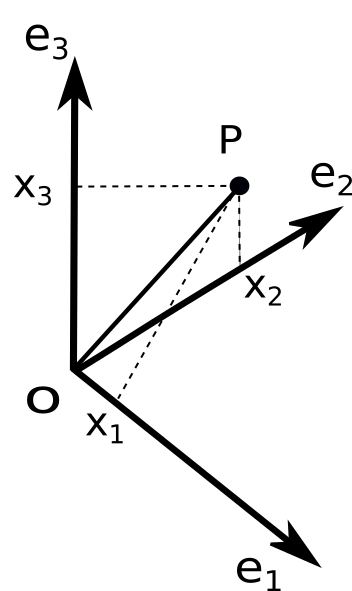

Conversely the assumption that 3D-Euclidean space is continuous implies that any ordered triple of real numbers
$(x_1,x_2,x_3)\in \mathbb{R}^3$ can be used to represent a unique point in 3D-Euclidean space.
Symbolically we describe this identification as
\begin{align*}
OP \triangleq  x_1\mathbf{e}_1+x_2\mathbf{e}_2+x_3\mathbf{e}_3=\underbrace{\left[ \begin{array}{ccc}\mathbf{e}_1 & \mathbf{e}_2 & \mathbf{e}_3 \end{array} \right]}_{\mathbf{e}} \,\underbrace{\left[ \begin{array}{c} x_1\\x_2\\x_3 \end{array} \right]}_x =\mathbf{e}\,x.
\end{align*}

In these notes the matrix
\begin{align*}
x=\left[ \begin{matrix} x_1\\x_2\\x_3 \end{matrix} \right],
\end{align*}
will be referred to as the Euclidean *representation* matrix, or simply the representation, of the position of the point $P$ with respect to the frame $\mathbf{e}$. The components $ (x_1,x_2,x_3)\in \mathbb{R}^3$
will be referred to as the position components of $P$, or the *Euclidean coordinates* of $P$  with respect to $\mathbf{e}$. Again with a bit of abuse of notation we will also denote this ordered triple by the same symbol, $x$, that denotes it matrix counterpart given above. Note that this construction also demosntrates in a constructive way how we can simply look at $\mathbb{R}^3$ as a model for the space we live in.



**In this note we will use the terms measurement system, frame, coordinates, and observer to mean the same thing.**

### Distance and angles

Consider two points $P$ and $Q$ in 3D-Euclidean space with Euclidean coordinates
$x\triangleq (x_1,x_2,x_3)\in \mathbb{R}^3$ and $y\triangleq (y_1,y_2,y_3)\in \mathbb{R}^3$ respectively with respect to some frame $\mathbf{e}$.
Recall that the standard *inner product* in $\mathbb{R}^3$ is defined by
\begin{align*}
<<x\,,\,y>>\triangleq x_1y_1+x_2y_2+x_3y_3.
\end{align*}
Then, by virtue of the Pythagorean theorem for 3D-Euclidean space, one sees that the measured distance between the two points $P$ and $Q$, in 3D-Euclidean space is equal to
\begin{align*}
d(P,Q)&\triangleq ||x-y|| = \sqrt{<<(x-y)\,,\,(x-y)>>}=\sqrt{(x_1-y_1)^2+(x_2-y_2)^2+(x_3-y_3)^2}.
\end{align*}
Using the inner product we can also  define the angle between the lines $OP$ and $OQ$ by the relationship
\begin{align*}
\theta \triangleq \cos^{-1}\left(\frac{<<x\,,\,y>>}{||x||\cdot ||y||}\right).
\end{align*}

*Thus we see that the fundamental assumptions of classical space-time imply that an inertial observer can construct an orthonormal frame in space and use it as its measurement system to define distances between points in space in such a way that all inertial observers will agree upon this measurement. In other words for every inertial observer there exists a globally defined coordinate system for space such that the distance between any two points with coordinates, $x\triangleq (x_1,x_2,x_3)\in \mathbb{R}^3$ and $y\triangleq (y_1,y_2,y_3)\in \mathbb{R}^3$, is given by $d(P,Q)$.*

Thus the standard Euclidean innerproduct on $\mathbb{R}^3$
\begin{align*}
<<\cdot\,,\,\cdot>>\: :\: \mathbb{R}^3\times \mathbb{R}^3 \mapsto \mathbb{R}
\end{align*}
fills in the missing part of distance and angle measurements and completes the picture of identifying Galilean space-time with $\mathbb{R}\times \mathbb{R}^3\equiv \mathbb{R}^4$.

###### Example: Distance Between Two Points and Angle Between Lines

In [ ]:
P=[1,1,1]; Q=[1,1,0]; O=[0,0,0];
PQ=np.array(P)-np.array(Q)
lengthPQ=linalg.norm(PQ)
anglePQ=np.arccos(np.array(P).dot(np.array(Q))/(linalg.norm(P)*linalg.norm(Q)))
print(['length='+str(lengthPQ), 'angle='+str(180*anglePQ/np.pi)])

['length=1.0', 'angle=35.26438968275467']


In [ ]:
#Adding a Frame
fig = go.Figure()
fig=mr.add_orth_norm_frame(fig,O,np.array([[1,0,0],[0,1,0],[0,0,1]]),[[-2,2],[-2,2],[-2,2]],'blue')
fig.show()

In [ ]:
#Adding the Points
fig.add_trace(go.Scatter3d(x=[O[0],P[0]], y=[O[1],P[1]], z=[O[2],P[2]], hoverinfo='x+y+z', mode='lines', line=dict(width=8)))
fig.add_trace(go.Scatter3d(x=[O[0],Q[0]], y=[O[1],Q[1]], z=[O[2],Q[2]], hoverinfo='x+y+z', mode='lines', line=dict(width=8)))

## The formal relationship between two inertial observers



As demonstarted previously the construction of the orthonormal frame and the use of the clock allows an observer $\mathbf{e}$ to assign the ordered quadruple $(t,x)\in \mathbb{R}^4$ where $t\in \mathbb{R}$ and  $x\in \mathbb{R}^3$ to a space-time event in a unique way. A different measurement system, $\mathbf{e}'$ may provide a different identification  $(\tau,\xi)\in \mathbb{R}^4$ where $\tau\in \mathbb{R}$ and  $\xi\in \mathbb{R}^3$ for space time events.

Let $A$ be some some such space-time event. Let the quadruple $(t,x)\in \mathbb{R}^4$ be the representation of the space-time event $A$ in $\mathbf{e}$ while let  $(\tau,\xi)\in \mathbb{R}^4$ be the representation of the space-time event $A$ in $\mathbf{e}'$.

When comparing the motion described in the two frames we need to know how the two representations (coordinates) are related to each other. Specifically we will provide a sketch of a proof that inertial observers must necessarily be translating at constant velocity with respect to each other without rotations. We do this by showing the following:

* The assumption that time is homogeneous and that all intervals of time are inertial observer invariant means that necessarily $\tau=t+a$ where $a$ is a constant.

* Homogeneity of space implies that necessarily  $\xi=\beta t+R x$ where $\beta$ is a constant $3\times 1$ matrix and $R$ is a constant $3\times 3$ matrix.

* The assumption that space intervals are inertial observer independent implies that $R$ is an orthonormal constant transformation (that is $R^TR=RR^T=I$).

* Let $O'$ be the origin of the orthonormal frame used by $\mathbf{e}'$ to make spatial measurements. If the space-time event $O'$ has the representation $(t,o)$ according to the observer $\mathbf{e}$ then since $v=\dot{o}=-R^{T}\beta=\mathrm{constant}$ we see that the velocity of the $\mathbf{e}'$ frame with respect to the $\mathbf{e}$ given by $v=\dot{o}$ must be a constant.  If both clocks of $\mathbf{e}$ and $\mathbf{e}'$ are synchronized (that is $a=0$) and if a certain space-time event $A$ has the representation $(t,x)$ according to $\mathbf{e}$ then the space-time event $A$ has the representation $(t,R(x-vt))$ according to $\mathbf{e}'$.


###A rough justification of the above claims

When comparing the motion described by the two observers we need to know how the two representations (coordinates) are related to each other.  That is we must find the functions $\tau(t,x)$ and $\xi(t,x)$.
The homogeneity assumption of space-time implies that
\begin{align*}
\tau(t_1+T,x_1+a)-\tau(t_2+T,x_2+a)&=\tau(t_1,x_1)-\tau(t_2,x_2)\\
\xi(t_1+T,x_1+a)-\xi(t_2+T,x_2+a)&=\xi(t_1,x_1)-\xi(t_2,x_2)
\end{align*}
for all $a, T$ and $t_1,t_2,x_1,x_2$. This necessarily implies that
\begin{align*}
\tau&=a+b t+c x,\\
\xi&=\gamma+\beta t+R x
\end{align*}
where $a,b,c,\gamma, \beta, R$ are all constant. Here $a,b\in \mathbb{R}$ and $c,\gamma, \beta\in \mathbb{R}^3$ and $R$ is a $3\times 3$ matrix.


The assumption that time is independent of space implies that $c=0$ and the assumption that all inertial observers see the same intervals of time means that necessarily  $b=1$ and hence that $\tau=t+a$. Hence all inertial observers measure time up to an ambiguity of an additive constant and thus  without loss of generality we may assume that all observers have synchronized their clocks and hence that $a=0$. This also implies that a *universal clock* exists.


The assumption that space intervals are inertial observer independent implies that, $||\xi(t,x_1)-\xi(t,x_2)||=||x_1-x_2||$. Thus $||R (x_1-x_2)||=||x_1-x_2||$ for all $x_1, x_2$. Thus necessarily $R$ must be an orthogonal\footnote{A matrix that satisfies the properties $R^TR=RR^T=I$ is called an orthogonal transformation.} constant transformation.

Since the space is observed to be homogeneous by all inertial observers without loss of generality we may choose $\gamma=0$ (note that choosing $\gamma=0$ amounts to assuming that the origin of the spatial frames of both observers coincide at the time instant $t=0$ and does not sacrifice any generality since the space is homogeneous we can parallel translate the frames until they coincide at the time instant $t=0$).  Thus we see that the representation of the same space-time event by two different inertial observers are related by
\begin{align*}
(\tau,\xi)=(t,\beta t+Rx).
\end{align*}

Since in the following sections we will see that the orthonormal frames are related to each by such an orthogonal transformation it follows from $\xi=Rx$ that the frame used by $\mathbf{e}'$ to make spatial measurements is also an orthonormal frame.
Let $O'$ be the origin of the orthonormal frame used by $\mathbf{e}'$. If the space-time event $O'$ has the representation $(t,o)$ according to the observer $\mathbf{e}$, it has the representation $(t,\beta t+ Ro)=(t,0)$ according to the observer $\mathbf{e}'$. Thus we have that $\beta=-R\dot{o}=-Rv$ where $v=\dot{o}$ and hence that the velocity of the origin of the $\mathbf{e}'$ frame with respect to the $\mathbf{e}$ frame, given by $v=\dot{o}=-R^T\beta$, must be a constant. **That is we see that all inertial observers must necessarily be translate at constant velocity with respect to each other without rotation.**

This also shows that the representation of a space-time event denoted by $(t,x)$ according to $\mathbf{e}$ must necessarily have the representation $\left(t,R(x-vt)\right)$ for some constant $v\in \mathbb{R}^3$ according to any other inertial frame $\mathbf{e}'$. **Space appears to be homogeneous only for such observers.** In particular we can see that this is not the case for observers rotating with respect to an inertial observer $\mathbf{e}$. That is a rotating observer will not observe space to be homogeneous (Show that this is true.).

Since $R$ is a constant, without loss of generality, one can always pick the orthonormal frame used by $\mathbf{e}'$ to be parallel to the one used by $\mathbf{e}$ so that $R=I_{3\times 3}$. Then we see that $\xi(t)=x(t)-vt$ in parallel translating inertial frames. **It is traditional to refer to parallel frames that translate at constant velocities with respect to each other as inertial frames.**

### Is any straight line motion inertial observer invariant?

Let $\mathbf{e}$ and $\mathbf{e}'$ represent two inertial observers with $\mathbf{e}'$ moving  parallel to $\mathbf{e}$ at a constant velocity $v=[v_1\:\:\:v_2\:\:\:v_3]^T$.

If $(t,x)$ is a representation of a point $P$ in $\mathbf{e}$ then this same point has the representation $\left(t,(x-vt)\right)$ in the $\mathbf{e}'$ frame.

If the point $P$ is seen to be moving in a straight line by $\mathbf{e}$ (without loss of generality say a straight line through the origin) then $x(t)=f(t)\,a$ where $a=[a_1\:\:\:a_2\:\:\:a_3]$ is a constant and $f(\cdot)$ is some function of time. Then this point has the representation $\left(t,(f(t)\,a-vt)\right)$ in the $\mathbf{e}'$ frame.

#### Constant velocity straight line motion

If $P$ is observed in $\mathbf{e}$ to move in a straight line at a constant velocity then $f(t)\equiv c\,t$ where $c\in \mathbb{R}$ is a constant and then in the $\mathbf{e}'$ frame this point has the representation $\left(t,t(c\,a-v)\right)$.  Thus it is observed to be moving in a straight line in $\mathbf{e}'$ as well (since $(c\,a-v)$ is a constant).

##### Simulation experiment - Motion in the $\mathbf{e}$ frame

In [ ]:
a=np.array([1,0,0]);
tt=np.linspace(0,2,11)
zeta=np.zeros((len(tt),3));
for i,t in enumerate(tt):
  zeta[i,:]=t*a;
fig=mr.animate_particle_motion(zeta,[[-3,3],[-3,3],[-3,3]],"$\mathrm{Motion\:\:\: in \:\:\:the} \:\:\:\mathbf{e}-\mathrm{frame}$")

##### Simulation experiment - Motion in the $\mathbf{e}'$ frame

In [ ]:
a=np.array([1,0,0]);
v=np.array([0,0,1])
tt=np.linspace(0,2,11)
zeta=np.zeros((len(tt),3));
for i,t in enumerate(tt):
  zeta[i,:]=t*(a-v);
fig=mr.animate_particle_motion(zeta,[[-3,3],[-3,3],[-3,3]],"$\mathrm{Motion\:\:\: in \:\:\:the} \:\:\:\mathbf{e}'-\mathrm{frame}$")

#### Constant acceleration straight line motion

If $P$ is observed in $\mathbf{e}$ to move in a straight line at a constant acceleration then $f(t)\equiv t^2$ and then in the $\mathbf{e}'$ frame this point has the representation $\left(t,t(at-v)\right)$. Thus ir is observed to be moving in a **curved** path in $\mathbf{e}'$ !.

##### Simulation Experiment - Motion in the $\mathbf{e}$ frame

In [ ]:
a=np.array([0,0,-1]);
tt=np.linspace(0,2,11)
zeta=np.zeros((len(tt),3));
for i,t in enumerate(tt):
  zeta[i,:]=t*(t*a);
fig=mr.animate_particle_motion(zeta,[[-3,3],[-3,3],[-3,3]],'Motion in the e frame')

##### Motion in the $\mathbf{e}'$ frame

In [ ]:
a=np.array([0,0,-1]);
v=np.array([1,0,0])
tt=np.linspace(0,2,11)
zeta=np.zeros((len(tt),3));
for i,t in enumerate(tt):
  zeta[i,:]=t*(t*a-v);
fig=mr.animate_particle_motion(zeta,[[-3,3],[-3,3],[-3,3]],'Motion in the e-prime frame')

###Circular motion

If $P$ is observed in $\mathbf{e}$ to move in a circle at a constant rate in the $\mathbf{e}_1,\mathbf{e}_2$ plane then $P$ has the representation $\left(t, (\sin{(\omega t)},\cos{(\omega t)},0)\right)$. Then in the $\mathbf{e}'$ frame that is moving in the $\mathbf{e}_3$ direction at a constant rate $v$ we see that this point has the representation $\left(t, (\sin{(\omega t)},\cos{(\omega t)},-vt)\right)$ and hence is observed to be moving in a **helical** path.

In [ ]:
v=np.array([0,0,1])
w=4;
tt=np.linspace(0,5,101)
zeta=np.zeros((len(tt),3));
for i,t in enumerate(tt):
    a=np.array([np.sin(w*t),np.cos(w*t),0]);
    zeta[i,:]=(a-v*t);

In [ ]:
fig=mr.animate_particle_motion(zeta,[[-3,3],[-3,3],[-3,3]],"$\mathrm{Motion\:\:\: in \:\:\:the} \:\:\:\mathbf{e}'-\mathrm{frame}$")

# Description of Motion

Consider a particle moving in 3D-Euclidean space. We have seen that the position $P(t)$ of the particle at a given time $t$ can be expressed by the Euclidean representation matrix $x(t)$ with respect to some orthonormal
frame $\mathbf{e}$. Since the position of the particle is changing with time, $x(t)$ is a function of time and describes a curve in $\mathbb{R}^3$ that is parameterized by time $t$.

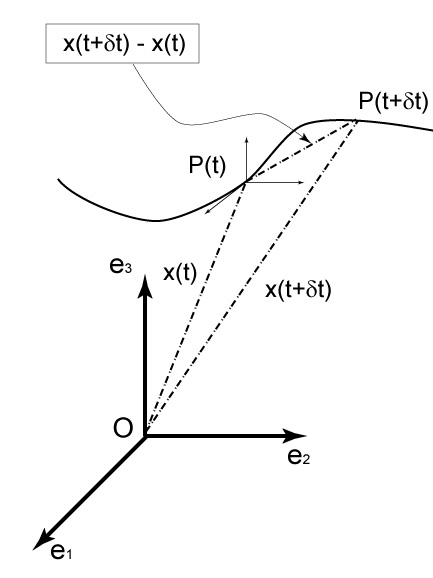

## Velocity

The **velocity** of a point $P$ is always defined with respect to an orthonormal reference frame.
Specifically
with respect to the $\mathbf{e}$ frame it is defined to be the infinitesimal change of position with respect to $\mathbf{e}$. That is
\begin{align*}
\dot{x}(t)\triangleq \lim_{\delta t \rightarrow 0}\frac{x(t+\delta t)-x(t)}{\delta t}=\left[\begin{array}{c} \dot{x}_1\\ \dot{x}_2\\ \dot{x}_3\end{array}\right].
\end{align*}
Observe that by definition $\dot{x}(t)$ gives the tangent to the curve at $P(t)$ (Refer to the figure below).
The components
\begin{align*}
\dot{x}_i(t)=\lim_{\delta t \rightarrow 0}\frac{x_i(t+\delta t)-x_i(t)}{\delta t}\:\:\:\:\: i=1,2,3
\end{align*}
represent the infinitesimal change of position in the $\mathbf{e}_i$ direction.
Thus the *correct* way to visualize $\dot{x}(t)$ is to consider it as the description of a point in a frame that is parallel to $\mathbf{e}$ but with origin at $P(t)$ (Refer to the figure below) or alternatively as arrows at $P(t)$.

The **magnitude of the velocity** in the $\mathbf{e}$ frame is defined to be simply the norm of $\dot{x}$ that is explicitly given by
\begin{align*}
{v}\triangleq||\dot{x}||=\sqrt{\dot{x}_1^2+\dot{x}_2^2+\dot{x}_3^2}.
\end{align*}

## Acceleration

The acceleration of a particle is also defined in terms of orthonormal frames. In an orthonormal frame $\mathbf{e}$ it is defined to be the infinitesimal change of velocity in the $\mathbf{e}$ frame,
\begin{align*}
\ddot{x}(t)\triangleq\lim_{\delta t \rightarrow 0}\frac{\dot{x}(t+\delta t)-\dot{x}(t)}{\delta t}=\left[\begin{array}{c} \ddot{x}_1\\ \ddot{x}_2\\ \ddot{x}_3\end{array}\right].
\end{align*}

Animals have inbuilt sensors that allow them to measure accelerations. For example, the human ear contains accelerometers that allow them to sense the direction of the
gravitational accelerations. It is interesting to note that animals can not sense absolute velocities and thus can not distinguish between being at rest or being in constant velocity motion.


Consider a certain space-time event $A$ and let $\mathbf{e}$ and $\mathbf{e}'$ be two inertial observers with parallel frames. Let $(t,x)\in \mathbb{R}^4$ and $(\tau,\xi)\in \mathbb{R}^4$ be the representation of the space-time event $A$ made by
$\mathbf{e}$ and $\mathbf{e}'$ respectively. Since all inertial observers agree that space-time is homogeneous we saw previously that the two representations are related by $\tau=t$ and that
$\xi=x-vt$ for some constant $v\in \mathbb{R}^3$. Thus the representation of the velocity of a particle in the two frames are related by
$\dot{\xi}=\dot{x}-v$ and the acceleration of a particle in the two frames are related by $\ddot{\xi}=\ddot{x}$.
Therefore we see that if a particular observer, $\mathbf{e}$, sees that an object is moving at a certan acceleration then all parallel inertial observers with respect to $\mathbf{e}$ will also observe that the object is moving at that same acceleration. This allows us to conclude that even though the position and velocity of a particle are not the same for all inertial observers with parallel frames the acceleration of a particle is observed to be the same for all inertial observers with parallel frames. Hence we can conclude the following:

**The isotropy, homogeneity, and continuity of space-time imply that the acceleration of a particle is an parallel translating inertial observer independent quantity. That is, if we represent the motion of a particle using any inertial coordinate system with parallel frames the acceleration computed in all of these frames will be the same.**

# Change in Motion

Galileo Galilei in the 17th century made the observation that a person doing experiments, with moving objects, below the deck in a ship traveling at
constant velocity, without rocking, on a smooth sea;  would not be able to tell whether the ship was moving or was stationary (it is interesting to note that animals can only feel accelerations and not absolute velocities. Thus one could not differentiate between being in a ship moving at constant
velocity and being in a ship at rest). Thus he concluded that laws of nature that describe the
motion of objects must be the same in all inertial frames.  At the end of the previous section we have seen that acceleration of a given particle is seen to be the same for all inertial observers with parallel frames.
Therefore, in order to be the same in all inertial frames, the laws of nature that govern particle motion must *necessarily depend only on the acceleration*.


Based on experiments, involving colliding rolling balls on a smooth horizontal surface, it was observed that objects generally tend to move at constant velocities or remain at rest
unless brought into interaction with other objects. This idea was generalized by Galileo in his *principle of inertia* where he stated that, all inertial observers will see that, an object that does not interact with any other
object will move at a constant speed or will remain at rest (Newton's First law). Thus for an isolated matter particle we would have that $\ddot{x}=0$ in any and every inertial frame and thus that it is an invariant property observed by all inertial observers. This also means that all inertial observers will agree that an isolated matter particle is either at rest or is moving in a straight line.

It was also observed that there was a certain resistance to change in this steady motion and that this resistance depended on the amount of matter present in the object. Bigger objects would tend to change its motion slower than smaller objects that were made of the same material. The measure of the degree of this resistance to change in
motion is referred to as the *inertia* of the object. Careful experiments with two colliding balls on a smooth surface indicated that a unique number can be ascribed to each ball such that if for each ball you multiply this number with the velocity of the ball, and add the results together, this sum will always remain a constant irrespective of whether they collide or not. It is easy to see that all inertial observers will also agree on this statement even though the constant they obtain will be different. Thinking of interacting particles, Galileo hypothesised that this number that multiplies the velocity of the particle was the same for all inertial observers and must be an *intrinsic property of the object*.  This is also one of the crucial assumptions of Galilean mechanics.



## The Principle of Conservation of Linear Momentum

Assume that there exists an **inertial observer independent unique property called mass** that can be assigned to each and every particle in the Universe and that all particles interact with each other.

Define linear momentum of a particle, in an inertial, frame to be the mass times velocity of the particle in the inertial frame. That is
\begin{align*}
p\triangleq m\dot{x}
\end{align*}

**Then an isolated set of particles, $P_1,P_2,\cdots,P_n$, interact with each other in such a way that the total sum of the linear momentum of the set of particles always remains constant when observed in any inertial frame.**

That is in any inertial frame $\mathbf{e}$
\begin{align*}
\sum_{i=1}^np_i= \sum_{i=1}^nm_i\dot{x}_i=\mathrm{constant}
\end{align*}
where $x_i$ is the representation of the position of the particle $P_i$ in the inertial frame $\mathbf{e}$ and $m_i$ is its inertial observer invariant property called mass.


### Consequences of the Principle of Conservation of Linear Momentum


The assumptions on classical space-time stated in the Galilean Space Time Axioms along with the above principle of conservation of linear momentum are the fundamental principles (laws) on which Galilean mechanics is founded upon.

Let us investigate what, additional information, the principle of conservation of linear momentum gives us about a system of interacting but isolated set of particles $P_1,P_2,\cdots,P_n$. That is, a set of particles that interact with themselves but do not interact with any of the other particles of the universe. This is an idealization of a real situation where the external interactions are much weaker compared to the internal ones. Let $m_i$ be the mass of $P_i$ and $\dot{x}_i$ be the velocity of $P_i$ in some inertial frame $\mathbf{e}$. Then the conservation of linear momentum in $\mathbf{e}$ gives us that

\begin{align*}
\sum_{i=1}^{n}m_i\dot{x}_i=\mathrm{constant}.
\end{align*}

Galilian spcae time assumptions imply that all interial observers are either at rest with respect to each other or are moving at a constant velocity with respect to each other. Thus if one inertial observer sees that momentum is conserved all other inertial observers will also see that momentum is conserved. However they will not agree on the value of this constant total momentum of the system. Thus though conservation of linear momentum is inertial frame invariant, the total linear momentum is not.

Differentiating the expression $\sum_{i=1}^{n}m_i\dot{x}_i=\mathrm{constant}$ one sees that in the $\mathbf{e}$-frame

\begin{align*}
\sum_{i=1}^{n}m_i\ddot{x}_i=0.
\end{align*}

Observe that now all inertial observers will agree that this sum is equal to zero. The above expression implies that an isolated particle ($n=1$) will move at constant velocity in any inertial frame (*Galileo's principle of inertia or what is commonly known as Newton's $1^{st}$ law of motion*).
The above sum can be re-arranged to give

\begin{align*}
m_j\ddot{x}_j=-\sum_{\stackrel{i=1}{i\neq j}}^{n}m_i\ddot{x}_i.
\end{align*}

This says that the mass times the acceleration of the $j^{\mathrm{th}}$ particle is not free but is constrained due to the interaction it has with the rest of the particles. This constraint imposed on the mass times the acceleration of the $j^{\mathrm{th}}$ particle is defined to be the *force* acting on the  $j^{\mathrm{th}}$ particle and in this case is given by$f_j=-\sum_{\stackrel{i=1}{i\neq j}}^{n}m_i\ddot{x}_i$. Then the above expression gives $m_j\ddot{x}_j=f_j$.  This is nothing but the statement of *Newton's $2^{nd}$ law of motion*. This also shows that forces observed is the same in all inertial frames.

With respect to two interacting particles the above expression also shows that mutual particle interactions are equal and opposite (*Newton's $3^{rd}$ law of motion*). Thus we see that the three Laws of Newton are a direct consequence of the principle of conservation of linear momentum in inertial frames.  **However note that it does not tell us that the mutual interaction between two particles must lie in the direction of the line joining the two particles.** Nevertheless from a macroscopic point of view it is an empirically observed fact that this in fact is true and will be taken as a separate hypothesis of the nature of force:

**Assume that, taken pairwise, mutual particle interaction forces act along the straight line that joins the two particles.**

We will see later that this assumption is crucial in ensuring that a quantity known as angular momentum of a set of isolated but interacting set of particles be conserved. Therefore one may replace this hypothesis with the equivalent hypothesis that the particles interact in such a way that the total angular momentum of the universe is conserved.


The quantity, *force*, that effects a change in the motion of a particle thus is a consequence of its interaction with other particles such that the total linear momentum of all the interacting particles remain constant in any inertial frame. Four types of fundamental particle interactions have been observed so far. They are the strong
(nuclear), electro-magnetic, electro-weak, and gravitational interactions. When taken pairwise these interactions are assumed to act along the line joining the two interacting particles. Since we have seen that particle accelerations are inertial observer invariant so are these forces. The change of motion that a matter particle or an object undergoes is due to the manifestation of one or many of these interactions.


Throughout the early part of the 19th century, all conducted experiments consistently validated the principle of conservation of linear momentum and the resultant Newton's laws of motion. These validations were limited only by the precision of the instruments available at the time. As the 19th century drew to a close and the early 20th century began, technological advancements spurred by the development of Galilean mechanics and Maxwell's laws of electromagnetism enabled scientists to observe and measure phenomena at much smaller time and length scales, as well as at significantly faster speeds and over larger distances.

These new capabilities revealed phenomena that challenged the existing frameworks of classical mechanics. Specifically, observations of objects moving at velocities approaching the speed of light and of celestial bodies at vast distances from Earth could not be accurately described using Galilean mechanics. This discrepancy led to the development of Einstein's theory of relativity and the emergence of quantum mechanics, which provided the necessary theoretical foundations to explain these new phenomena.

Despite these revolutionary advancements, for most engineering applications, the objects of interest are macroscopic—significantly larger than the microscopic objects considered in quantum mechanics—and they move at speeds much lower than the speed of light. Under these conditions, the Galilean laws of mechanics remain highly accurate and continue to predict the behavior of such objects with a sufficient degree of precision. Thus, for practical engineering purposes, classical mechanics still provides a reliable framework for understanding and predicting the motion of everyday objects.


## Summary Statement of The Principle of Galilean Mechanics


**In summary the fundamental notions on which Galilean mechanics is founded upon are:**

* objects are made up of impenetrable particles that interact with each other in an observer independent manner,

* when taken pairwise particles interactions lie along the straight line that joins the two particles,

* there exists a class of observers called inertial observers who agree on the Galilean space-time assumptions,

* associated with each particle there exists an inertial observer independent quantity called mass,

* the total linear momentum of all the particles in the Universe is always conserved when viewed in an inertial frame.


Based on these it can be deduced that all particles interact in a manner that is independent of the inertial frame of reference and that these interactions are the cause of change in motion. In particular the change in motion of a particle in any given inertial frame $\mathbf{e}$ is described by the mathematical expression

\begin{align*}
m\ddot{x}=f(t),
\end{align*}

where $f(t)$ is defined to be the force acting on the particle that arises due to its interaction with the rest of the particles in the universe and $m$ is the observer invariant property of the particle called mass.


It is interesting to note, according to the expression above, that measuring accelerations allows one to measure forces. Even though they can be theoretically estimated using the knowledge of
the fundamental interactions of particles, it turns out that this is the only way we can measure forces. Thus the above expression, if you may, can be taken to be the definition of force.

Since the knowledge of the fundamental interactions allow us to estimate forces, the above expression can be used to predict the motion of the point like particle. **That is what
is monumental about this law.** From a mathematical perspective this equation describes a second order differential equation and solving it for $x(t)$ requires the
knowledge of the initial conditions $x(t_0)=x_0$ and $\dot{x}(t_0)=v_0$ and therefore in order to predict the motion of a particle what one needs is the knowledge of the initial state,
$x(t_0)=x_0$ and $\dot{x}(t_0)=v_0$, and the knowledge of the force, $f(t)$, at all times, $t$.

## Kinetic Energy

Another fundamental property of motion is the notion of **energy** associated with it. Consider a particle of mass $m$ moving under the influence of a force $f$ (arising due to the interactions it has with the rest of the universe). The kinetic energy of the particle is defined with respect to an \textit{inertial frame} $\mathbf{e}$ and is given by the relationship
\begin{align*}
\mathrm{KE} \triangleq \frac{1}{2}m ||\dot{x}(t)||^2 =\frac{1}{2m} ||p(t)||^2.
\end{align*}
Observe that this quantity changes from inertial frame to inertial frame and hence is **not a quantity that is invariant for all inertial observers**. In general, unlike total linear momentum and total angular momentum, the total kinetic energy of a system of isolated particles need not remain constant. However differentiating the Kinetic energy associated with given particle we see that along the motion of a particle
\begin{align*}
\dfrac{d }{dt} \mathrm{KE}= m \langle \langle \ddot{x}(t),\dot{x}(t)\rangle\rangle=\langle \langle f(t),\dot{x}(t)\rangle\rangle.
\end{align*}
The quantity
\begin{align*}
W(t_1,t_2)=\int_{t_1}^{t_2}\langle \langle f(t),\dot{x}(t)\rangle\rangle\,dt
\end{align*}
is defined to be the **work done by the force** $f$ acting on the particle during the time interval $[t_1,t_2]$.


**Thus we have that the rate of change of kinetic energy of a particle is equal to the rate of work done by the force acting on the particle. This is nothing but a statement of conservation of energy of a set of interacting particles. The rate of work done is called the power of the force.**


## Example: Spring and a Mass

Consider the problem of a horizontal spring with one end fixed to a support and the other end fixed to an object, of mass $m$, that moves on a smooth horizontal table.

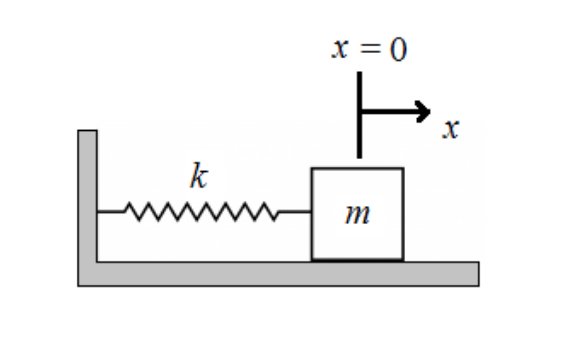






We assume that the object is symmetric and small so that we can approximate it as a point particle with mass $m$. If we
give an initial horizontal displacement to the object we know empirically that the object will exhibit a simple harmonic motion if the air and other resistances on the object are
negligible and the motion is small.
That is, if $x(t)$ is the displacement of the object from the un-stretched position and if the air resistance on the object is negligible and the motion is small, the position $x(t)$ of the object $P$ at a given time $t$ is described sufficiently accurately by the second order differential equation
\begin{align*}
m\ddot{x}(t)=-k\,x(t).
\end{align*}
Observing this expression it is evident that the mass times the acceleration of the object is constrained and is equal to $-k\,x(t)$. Thus we could call $-k\,x(t)$ the force exerted on the object due to its collective interaction with all the particles that makeup the
spring (this is known as the Hooke's law). Considering the fact that a spring is made of atoms that interact in a manner where they repulse
each other when they are too close and attract when they are sufficiently away (this arises due to the electro-magnetic interactions due to the electrons and protons that
makeup the particle) we may also theoretically estimate this law. These are the two fundamental ways in which forces are determined in practice.

Simulating the motion of the Spring Mass System

In [ ]:
def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

In [ ]:
m=1; k=1;
A=np.array([[0,1],[-k/m,0]]);
[t,sol,fig]=mr.simulate_dy_system(LinearSystemModel, 10,0.01, [1,0], A, 'Spring Mass System', 'Time / t', 'x')

Plotiing the Kinetic, Potential, and Total Energy

In [ ]:
KE=m*sol[:,1]**2/2
PE=k*sol[:,0]**2/2
TE=KE+PE;

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=KE, mode='lines',name='KE'))
fig.add_trace(go.Scatter(x=t, y=PE, mode='lines',name='PE'))
fig.add_trace(go.Scatter(x=t, y=TE, mode='lines',name='TE'))
fig.update_layout(title='Energy Vs Time')
fig.show()

# Motion of a Set of Interacting Particles

In this section we will investigate the additional consequences, of the law of conservation of linear momentum, on the motion of a set of particles $P_1,P_2,\cdots,P_n$. For example this could be a body of fluid particles (a deformable body) or a body of particles rigidly fixed with respect to each other (a rigid body).

## Rate of Change of Linear Momentum

Let us begin by consider the description of the motion of a single particle $P_i$ of mass $m_i$ in an inertial frame $\mathbf{e}$ with origin $O$. Denote by $x_i$ and $\dot{x}_i$ its position and velocity respectively in the inertial frame $\mathbf{e}$. By definition the linear momentum of particle $i$ in the inertial frame $\mathbf{e}$ is $p_i\triangleq m_i\dot{x}_i$.

Differentiating the both sides of $p_i\triangleq m_i\dot{x}_i$ we see that
\begin{align*}
\dot{p}_i=f_i,
\end{align*}
where $f_i$ is the force acting on the particle due to its interaction with all the other particles in the universe.
This expression states that the rate of change of linear momentum of a particle in an inertial frame is equal to the force acting on the particle. This is as an equivalent statement of Newton's second law.

The law of conservation of momentum tells us that the total linear momentum of a collection of interacting but otherwise isolated set of particles $P_1,P_2,\cdots,P_n$ is conserved in any inertial frame
$\mathbf{e}$. That is in particular
\begin{align*}
p\triangleq \sum_{i=1}^np_i=\sum_{i=1}^nm_i\dot{x}_i=\mathrm{constant}.
\end{align*}


(The following video taken in outerspace demonstrates this principle very nicely: https://www.youtube.com/watch?v=4IYDb6K5UF8)


When there are other external influences on the set of particles the total linear momentum of the set of particles is not conserved. To see this differentiating the above expression we have
\begin{align*}
\dot{p}=\sum_{i=1}^n\dot{p}_i=\sum_{i=1}^nm_i\ddot{x}_i=\sum_{i=1}^n f_i.
\end{align*}
Let us split the interaction force that the $i^{\mathrm{th}}$ particle experiences as
\begin{align*}
f_i=f_i^e+\sum_{j\neq i}^nf_{ij}
\end{align*}
where $f_{ij}$ is the force on $i$ due to its interaction with $j$ and $f_i^e$ is the resultant force acting on $i$ due to its interaction with the rest of the universe.

Note that since particle interactions are equal and opposite we have that the interaction of $j$ on $i$ denoted by $f_{ij}$ is equal and opposite to the interaction of $i$ on $j$ denoted by $f_{ji}$. That is $f_{ij}=-f_{ji}$. Hence we have that
\begin{align*}
\sum_{i=1}^nf_i=\sum_{i=1}^nf_i^e+\sum_{i=1}^n\sum_{j\neq i}^nf_{ij}= \sum_{i=1}^nf_i^e\triangleq f^e
\end{align*}
where $f^e$ represents the total resultant of the external interactions acting on the set of particles $P_1,P_2,\cdots,P_n$.
Thus we have
\begin{align*}
\dot{p}=\sum_{i=1}^n\dot{p}_i=\sum_{i=1}^nm_i\ddot{x}_i=\sum_{i=1}^n f_i=f^e.
\end{align*}

This also implies the following. Let $\bar{x}$ be the representation of the *center of mass* $O_c$ of the particles in the $\mathbf{e}$ frame.
That is let
\begin{align*}
\bar{x}&\triangleq \frac{\sum_{i=1}^{n}m_ix_i}{\sum_{i=1}^{n}m_i}.
\end{align*}
Defining $M\triangleq \sum_{i=1}^{n}m_i$ and
differentiating this we get
$M\dot{\bar{x}}= {\sum_{i=1}^{n}m_i\dot{x}_i}= {p}$
and differentiating again
we get
\begin{align*}
M\ddot{\bar{x}}= f^e.
\end{align*}

This says something very interesting about the behaviour of the set of particles. That is, this equation only describes the center of mass motion of the set of particles and not the motion that is relative to the center of mass that we clearly observe for instance with rigid body motion or a water bubble in outerspace.

See for instance the amazing looking videos taken in outer space:

* https://youtu.be/bKk_7NIKY3Y

* https://youtu.be/1n-HMSCDYtM

How can we capture the motion of the set of particles relative to its center of mass?

### Examples of Interacting Systems

#### Example#1: Coupled Spring Mass System

Consider the coupled spring mass system:

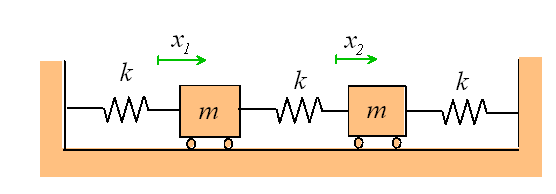

Isolating each of the masses and applying Newton's eaquations for each of them seperately we have:

\begin{align*}
m\ddot{x}_1&=-kx_1-k(x_1-x_2),\\
m\ddot{x}_2&=-kx_2-k(x_2-x_1)
\end{align*}

Which can be written as:
\begin{align*}
M\ddot{X}+KX&=0
\end{align*}
where
\begin{align*}
X=\begin{bmatrix}x_1\\x_2\end{bmatrix},\:\:\:\:
M=\begin{bmatrix}m & 0\\0 & m\end{bmatrix},\:\:\:\:
K=\begin{bmatrix}2k & -k\\ -k & 2k\end{bmatrix}
\end{align*}

This can also be written in the dynamic system form
\begin{align*}
\dot{Y}&=AY
\end{align*}
where
\begin{align*}
Y=\begin{bmatrix}x_1\\x_2\\\dot{x}_1\\\dot{x}_2\end{bmatrix},\:\:\:\:
A=\begin{bmatrix}0 & 0 & 1 &0\\ 0 & 0& 0 &1\\\frac{k}{m} & -\frac{2k}{m} & 0 &0 \\-\frac{2k}{m} & \frac{k}{m} & 0 &0
\end{bmatrix}.
\end{align*}

In [ ]:
m=1; k=1;
A=np.array([[0,0,1,0],[0,0,0,1],[-2*k/m,k/m,0,0],[k/m,-2*k/m,0,0]]);
[t,sol,fig]=mr.simulate_dy_system(LinearSystemModel, 50,0.01, [1,0,0,0], A, 'Coupled Spring Mass System', 'Time / t', 'x')

In [ ]:
KE=m*(sol[:,2]**2+sol[:,3]**2)/2
PE=k*(sol[:,0]**2+sol[:,1]**2+(sol[:,0]-sol[:,1])**2)/2
TE=KE+PE;

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=KE, mode='lines',name='KE'))
fig.add_trace(go.Scatter(x=t, y=PE, mode='lines',name='PE'))
fig.add_trace(go.Scatter(x=t, y=TE, mode='lines',name='TE'))
fig.update_layout(title='Energy Vs Time')
fig.show()

In [ ]:
P=m*sol[:,2]+m*sol[:,3]
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=P, mode='lines',name='Linear Momentum'))
fig.update_layout(title='Linear Momentum Vs Time')
fig.show()

#### Example#2: Coupled Spring Mass System

Consider the coupled spring mass system:

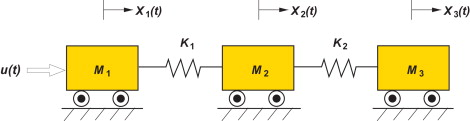

Isolating each of the masses and applying Newton's eaquations for each of them seperately we have:

\begin{align*}
m_1\ddot{x}_1&=-k_1(x_1-x_2)+u,\\
m_2\ddot{x}_2&=-k_1(x_2-x_1)-k_2(x_2-x_3)\\
m_3\ddot{x}_3&=-k_2(x_3-x_2)
\end{align*}

For the condition where $u(t)\equiv 0$ the above equations can be written down as:
\begin{align*}
M\ddot{X}+KX&=0
\end{align*}
where
\begin{align*}
X=\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix},\:\:\:\:
M=\begin{bmatrix}m_1 & 0 &0 \\0 & m_2 & 0\\ 0 & 0 & m_3\end{bmatrix},\:\:\:\:
K=\begin{bmatrix}
k_1 & -k_1 & 0\\ -k_1 & (k_1+k_2) & -k_2\\ 0 & -k_2 & k_2
\end{bmatrix}
\end{align*}

This can also be written in the dynamic system form
\begin{align*}
\dot{Y}&=AY
\end{align*}
where
\begin{align*}
Y=\begin{bmatrix}x_1\\x_2\\x_3\\\dot{x}_1\\\dot{x}_2\\\dot{x}_3\end{bmatrix},\:\:\:\:
A=\begin{bmatrix}0 & 0 & 0 & 1 &0 & 0\\ 0 & 0& 0 & 0 & 1 & 0\\
0 & 0& 0 & 0 & 0 & 1\\
-\frac{k_1}{m_1} & \frac{k_1}{m_1} & 0 & 0 & 0 &0 \\\frac{k_1}{m_2} & -\frac{k_1+k_2}{m_2} & \frac{k_2}{m_2} &0 &0&0\\ 0 & \frac{k_2}{m_3} & -\frac{k_2}{m_3} & 0 & 0 & 0
\end{bmatrix}.
\end{align*}

In [ ]:
m1=1; m2=1; m3=1; k1=1; k2=1; k3=1;
A=np.array([[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1],[-k1/m1,k1/m1,0,0,0,0],[k1/m2,-(k1+k2)/m2, k2/m2,0,0,0],[0,k2/m3,-k3/m3,0,0,0]]);
[t,sol,fig]=mr.simulate_dy_system(LinearSystemModel, 50,0.01, [1,0,0,0,0,0], A, 'Coupled Spring Mass System', 'Time / t', 'x')

In [ ]:
KE=(m1*sol[:,3]**2+m2*sol[:,4]**2+m3*sol[:,5]**2)/2
PE=(k1*(sol[:,0]-sol[:,1])**2+k1*(sol[:,1]-sol[:,2])**2)/2
TE=KE+PE;

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=KE, mode='lines',name='KE'))
fig.add_trace(go.Scatter(x=t, y=PE, mode='lines',name='PE'))
fig.add_trace(go.Scatter(x=t, y=TE, mode='lines',name='TE'))
fig.update_layout(title='Energy Vs Time')
fig.show()

In [ ]:
P=m1*sol[:,3]+m2*sol[:,4]+m3*sol[:,5]
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=P, mode='lines',name='Linear Momentum'))
fig.update_yaxes(range=[-0.1,0.1])
fig.update_layout(title='Linear Momentum Vs Time')
fig.show()

### Question: Why is the momentum not conserved in the first example while it is conserved in the second example?

## Rate of Change of Anugular Momentum

Recall that for a set of interacting particles conservation linear momentum gives:
\begin{align*}
M\ddot{\bar{x}}= f^e,
\end{align*}
where $M=\sum_{i=1}^nm_i$ is the total mass of the set of particles and $f^e=\sum_{i=1}^nf^e_i$ is the total resultant interaction the system of particles have with all the other particles of the universe.


The following amazing looking videos taken in outer space show that there is more to the story than the center of mass motion.

* https://youtu.be/bKk_7NIKY3Y

* https://youtu.be/1n-HMSCDYtM

How can we capture the motion of the set of particles relative to its center of mass?

In order to capture this motion of the particles with respect to each other the notion of the rotational ability of a particle at $P_i$ about a point $O'$ in space is defined as follows.
Let $OO'=\mathbf{e}\,o$.


The *angular momentum* of a particle $P_i$ in the $\mathbf{e}$ frame about the point $O'$ (fixed or otherwise) is defined to be
\begin{align*}
\pi_i &\triangleq (x_i-o)\times m_i\dot{x}_i.
\end{align*}


Differentiating this we have
\begin{align*}
\dot{\pi}_i&= (\dot{x}_i-\dot{o})\times m_i\dot{x}_i+(x_i-o)\times m_i\ddot{x}_i=-\dot{o}\times m_i\dot{x}_i+(x_i-o)\times f_i.
\end{align*}

The quantity
\begin{align*}
\tau_i &\triangleq (x_i-o)\times f_i,
\end{align*}
is defined to be the *moment of the force* about $O'$. Substituting this in the above express we have

\begin{align*}
\dot{\pi}_i&= -\dot{o}\times m_i\dot{x}_i+\tau_i.
\end{align*}




Recall that since the force acting on a particle is due to its interaction with the  particles under consideration and the rest of the particles in the universe we have $f_i=f_i^e+\sum_{j\neq i}^nf_{ij}$. Since  $f_{ji}=-f_{ij}$ and **if they lie along the straight line joining the two particles** we also have that
$(x_i-o)\times  f_{ij}=-(x_j-o)\times  f_{ji}$ which implies that
\begin{align*}
\sum_{i=1}^n\tau_i=\sum_{i=1}^n(x_i-o)\times f_i=\sum_{i=1}^n(x_i-o)\times  f_{i}^e+\sum_{i=1}^n\sum_{j\neq i}^n(x_i-o)\times  f_{ij}=\sum_{i=1}^n(x_i-o)\times  f_{i}^e.
\end{align*}
We will define the quantity
\begin{align*}
{\tau^e}\triangleq \sum_{i=1}^n(x_i-o)\times  f_{i}^e.
\end{align*}
to be the *total moment of the external forces acting about the point $O'$*.
Thus the rate of change of total angular momentum $\pi=\sum_{i=1}^n\pi_i$ about a point $O'$ is
\begin{align*}
\dot{\pi}&=\sum_{i=1}^n\dot{\pi}_i= -\dot{o}\times \sum_{i=1}^nm_i\dot{x}_i+\sum_{i=1}^n\sum_{j\neq i}^n(x_i-o)\times  f_{ij}+\sum_{i=1}^n(x_i-o)\times  f_{i}^e,\\
&=-\dot{o}\times \sum_{i=1}^nm_i\dot{x}_i+\tau_e=-M\dot{o}\times \dot{\bar{x}}+\tau_e.
\end{align*}

This expression tells us that
\begin{align*}
\dot{\pi}&=\tau^e
\end{align*}
is true under any of the following conditions.

* $\dot{o}=0$,

* $\dot{\bar{x}}=0$,

* $O'=O_c$.


However note that $\dot{o}=0$ or  $\dot{\bar{x}}=0$ are conditions that not all inertial observers will agree upon. Thus we have the following conclusion that all inertial observers will agree upon:  **the total angular momentum of a set of interacting but otherwise isolated set of particles  about the center of mass of the set of particles remain constant when observed in any inertial frame.** Notice that the assumption that pairwise particle interactions that lie along a straight line that joins the two particles was crucial for this conclusion. Thus one may replace that assumption with the sometimes more widely used assumption that total angular momentum of the universe is conserved.



## Summary Laws of Conservation of Momentum


In summary, what we have seen is that, in general if $P_1,P_2,\cdots,P_n$ are a set of particles that are interacting with themselves and the rest of the universe, then the law of conservation of linear momentum of the universe along with the assumption that pairwise particle interactions lie along the straight line joining the two particles imply that:

* the rate of change of total momentum of the set of particles is equal to the total resultant of the external forces acting on the system of particles. That is
\begin{align*}
\dot{p}=f^e.
\end{align*}

* the set of particles move in such a way that its center of mass moves according to the motion of a particle of mass $M=\sum_{i=1}^nm_i$ that is under the influence of the force $f^e=\sum_{i=1}^nf_i^e$. That is

\begin{align*}
M\ddot{\bar{x}}=f^e.
\end{align*}

* the rate of change of the total angular momentum of the system of particles about a point $O'$ is given by
\begin{align*}
\dot{\pi}=-M\dot{o}\times\dot{\bar{x}}+\tau^e.
\end{align*}
If the moments are taken about a point $O'$ that is either fixed or coincides with the center of mass of the set of particles then the above reduces to the very simple statment $\dot{\pi}=\tau^e$.


*We emphasize that these conclusions are valid for any collection of particles such as in a deformable body or a rigid body.* A straight forward corollary of the above results for an isolated but mutually interacting set of particles is that **the velocity of the center of mass of the particles remains constant and that the total angular momentum of the set of particles about its center of mass is conserved  in any inertial frame.**


# Motion in Moving (Non-Inertial) Frames

## Relationship Between Orthonormal Frames

We can easily see that the construction of orthonormal frames is not unique and that, in general, different observers can have different orthonormal frames. For instance consider the figure below where two observers have defined two right hand oriented orthonormal frames $\mathbf{e}=[\mathbf{e}_1\:\:\: \mathbf{e}_2\:\:\: \mathbf{e}_3]$ and $\mathbf{b}=[\mathbf{b}_1\:\:\: \mathbf{b}_2\:\:\: \mathbf{b}_3]$ respectively. The position of the particle $P(t)$ at a particular instant of time $t$ is described by the two observers using the Euclidean representation matrices $x=[x_1\:\:\:x_2\:\:\:x_3]^T$ and $X=[X_1\:\:\:X_2\:\:\: X_3]^T$ respectively. Let $o$ be the Euclidean representation of the point $O'$ in the orthonormal frame $\mathbf{e}$. That is let $OP=\mathbf{e}x$, $OO'=\mathbf{e}o$ and $O'P=\mathbf{b}X$. We are interested in determining the relationship between the observed motion in the two different frames.

Let us begin by finding the relationship between the two representations $x$ and $X$.
Introduce another frame $\mathbf{e}'=[\mathbf{e}'_1\:\:\:
 \mathbf{e}'_2\:\:\: \mathbf{e}'_3]$, as shown in the figure below, with origin coinciding with $O'$ such that its axis are of unit length and are also parallel to $\mathbf{e}$. Let the representation of the point $P$ in the $\mathbf{e}'$ frame be $x'$. That is let $O'P=\mathbf{e}'x'$.
From the Euclidean assumption of space it follows that
\begin{align*}
OP&=OO'+O'P=\mathbf{e}\, o+\mathbf{e}'x'=\mathbf{e}x
\end{align*}
Since $\mathbf{e}$ and $\mathbf{e}'$ are parallel to each other we have that the two representations
$x$ and $x'$ are related by
\begin{align*}
x=o+x'.
\end{align*}
However, what we are really interested in is the relationship between $x$ and $X$.

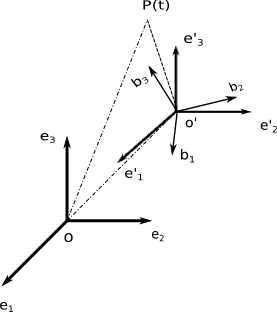


Observe that one can represent each of the axis $\mathbf{b}_i$ using the $\mathbf{e}'$ frame as follows.
\begin{align*}
\mathbf{b}_1= r_{11}\mathbf{e'}_1+r_{21}\mathbf{e'}_2+r_{31}\mathbf{e'}_3,\\
\mathbf{b}_2= r_{12}\mathbf{e'}_1+r_{22}\mathbf{e'}_2+r_{32}\mathbf{e'}_3,\\
\mathbf{b}_3= r_{13}\mathbf{e'}_1+r_{23}\mathbf{e'}_2+r_{33}\mathbf{e'}_3.
\end{align*}
This can be expressed in the matrix form
\begin{align*}
\underbrace{[\mathbf{b}_1\:\:\: \mathbf{b}_2\:\:\: \mathbf{b}_3]}_{\mathbf{b}}=\underbrace{[\mathbf{e'}_1\:\:\: \mathbf{e'}_2\:\:\: \mathbf{e'}_3]}_{\mathbf{e}'}\underbrace{\begin{bmatrix}r_{11}&r_{12}&r_{13}\\
r_{21}&r_{22}&r_{23}\\
r_{31}&r_{32}&r_{33}\\
\end{bmatrix}}_{R}.
\end{align*}
It can be shown that the assumption of Euclidean 3D-space implies that $R$ is a $3\times 3$  special orthogonal matrix (this can be proven by considering that the lengths and angles measured in two different orthonormal frames must be the same).

The space of all $3\times 3$ special orthogonal matrices is denoted by $\mathrm{SO}(3)$.
Recall that a special orthogonal matrix $R$ satisfies $RR^T=R^TR=I_{3\times 3}$ and $\det{(R)}=1$.}.
Since $O'P=\mathbf{e}'x'=\mathbf{b}\,X=\mathbf{e}'\,RX$ we have that

\begin{align*}
x'&=RX.
\end{align*}


Thus we have that the two
representations of the point $P$ in the two frames $\mathbf{e}$ and $\mathbf{b}$ as depicted in the figure above are related by
\begin{align*}
x&=o+RX.
\end{align*}

The above expression can also be expressed in matrix form as:
\begin{align*}
\begin{bmatrix}x \\ 1
\end{bmatrix}&=\begin{bmatrix}
R & o \\ 0 & 1\end{bmatrix}
\begin{bmatrix} X \\ 1
\end{bmatrix}.
\end{align*}
This expression will be very useful when one deals with kinematic chains such as robot arms.

**Notice that the preceding discussion shows that the relationship between two right hand oriented orthonormal frames $\mathbf{e}$ and $\mathbf{b}$ is uniquely given by a $(o,R)\in\mathbb{R}^3\times SO(3)$ and that conversely any $(o,R)\in\mathbb{R}^3\times SO(3)$ defines the relationship between two right hand oriented orthonormal frames $\mathbf{e}$ and $\mathbf{b}$ in a unique fashion.**

In particular we highlight that $R\in SO(3)$ can be thought of as a mathematical object that relates two orthonormal frames $\mathbf{e}$ and $\mathbf{b}$ with coinciding origins through the relationship $\mathbf{b}=\mathbf{e}\,R$.

### Examples of 2D-Rotated Frames

As an illustration let us consider, easy to visualize, three special frame rotations. We will also see that these three special type of rotating frames will become useful when representing the motion of complicated systems as well.
Consider the three rotating orthonormal frames that are related to a fixed frame $\mathbf{e}$ as shown in the figure below.

Each of the frames below correspond to a simple counter clockwise rotation about the $i^{\mathrm{th}}$ axis of $\mathbf{e}$ by an angle equal to $\theta_i(t)$.

#### Rotation About the First Axis

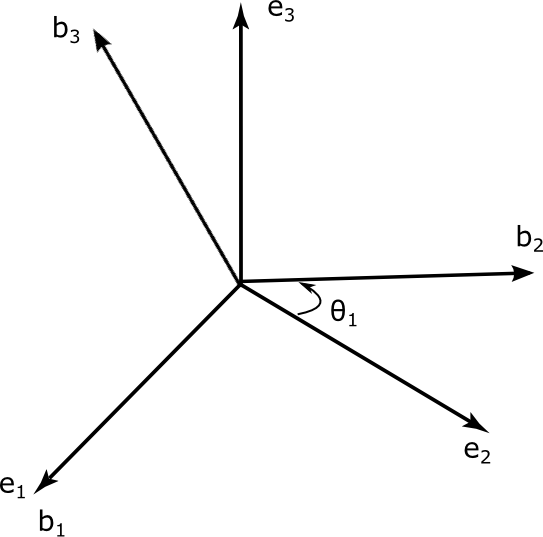

Here $\mathbf{b}=\mathbf{e}\, R_1{(\theta_1)}$ where
\begin{align*}
R_1{(\theta_1)}=\left[\begin{array}{ccc}
1 & 0 & 0\\
0 & \cos{\theta_1} & -\sin{\theta_1}\\
0 & \sin{\theta_1} & \cos{\theta_1}
\end{array}\right]
\end{align*}

In [ ]:
#Plotting the e-frame
fig=go.Figure();
O=np.array([0,0,0]);
fig=mr.add_orth_norm_frame(fig,O,np.array([[1,0,0],[0,1,0],[0,0,1]]),[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
#Plot a frame rotated by theta1 around e1
theta1=np.pi/3;
R1theta1=np.array([[1,0,0],[0,np.cos(theta1),-np.sin(theta1)],[0,np.sin(theta1),np.cos(theta1)]])
fig=mr.add_orth_norm_frame(fig,O,R1theta1,[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'red')
fig.show()

#### Rotation About the Second Axis

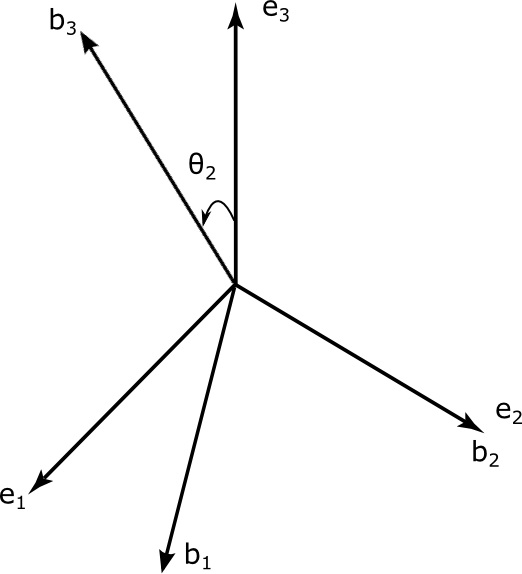

Here $\mathbf{b}=\mathbf{e} \,R_2{(\theta_2)}$ where
\begin{align*}
R_2{(\theta_2)}=\left[\begin{array}{ccc}
\cos{\theta_2} & 0 & \sin{\theta_2}\\
0 & 1 & 0\\
- \sin{\theta_2}& 0 & \cos{\theta_2}
\end{array}\right].
\end{align*}

In [ ]:
#Initiating a figure with a e-frame
fig=go.Figure();
O=np.array([0,0,0]);
fig=mr.add_orth_norm_frame(fig,O,np.array([[1,0,0],[0,1,0],[0,0,1]]),[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
#Adding a frame rotated by theta2 around e2
theta2=np.pi/3;
R2theta2=np.array([[np.cos(theta2),0,np.sin(theta2)],[0,1,0],[-np.sin(theta2),0,np.cos(theta2)]])
fig=mr.add_orth_norm_frame(fig,O,R2theta2,[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'red')
fig.show()

#### Rotation About the Third Axis

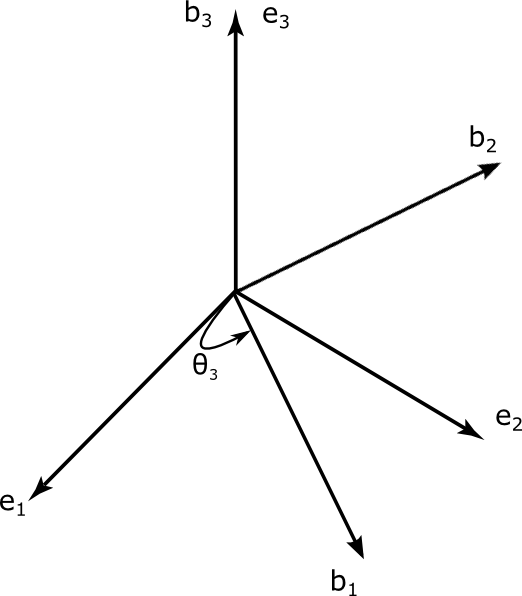

Here $\mathbf{b}=\mathbf{e}\, R_3{(\theta_3)}$ where

\begin{align*}
R_3{(\theta_3)}=\left[\begin{array}{ccc}
\cos{\theta_3} & -\sin{\theta_3} & 0\\
\sin{\theta_3} & \cos{\theta_3} &0\\
0 & 0 & 1
\end{array}\right].
\end{align*}

In [ ]:
#Initiating a figure with a e-frame
fig=go.Figure();
O=np.array([0,0,0]);
fig=mr.add_orth_norm_frame(fig,O,np.array([[1,0,0],[0,1,0],[0,0,1]]),[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
#Adding a frame rotated by theta3 around e3
theta3=np.pi/3;
R3theta3=np.array([[np.cos(theta3),-np.sin(theta3),0],[np.sin(theta3),np.cos(theta3),0],[0,0,1]])
fig=mr.add_orth_norm_frame(fig,O,R3theta3,[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'red')
fig.show()

## Kinematics in a Moving Frame

In general, since the position representation are different from frame to frame, the velocities and accelerations expressed in one frame will be different form those expressed with
respect to another. Thus it is important to always specify the orthonormal frame with which they are expressed. Consider the problem of describing the motion of a point $P(t)$ that is moving with respect to both frames $\mathbf{e}$ and $\mathbf{b}$ and let $\mathbf{b}$ be translating and rotating with respect to $\mathbf{e}$. Thus we have that all matrices $x(t),X(t)$ and $o(t),R(t)$ are changing with respect to time.  Differentiating the expression $x=o+RX$ that relates the two position representations we find that the two velocities $\dot{x}$ and $\dot{X}$ measured in the two frames are related by
\begin{align*}
\dot{x}=\dot{o}+\dot{R}X+R\dot{X}.
\end{align*}
Similarly the two accelerations measured in the two frames $\ddot{x}$ and $\ddot{X}$ are related by
\begin{align*}
\ddot{x}=\ddot{o}+\ddot{R}X+2\dot{R}\dot{X}+R\ddot{X}.
\end{align*}

In the following we proceed to find if $\dot{R}$ and $\ddot{R}$ can expressed a little more conveniently.
Since $R^T(t)R(t)=I_{3\times 3}$, it follows that $\dot{R}^TR+R^T\dot{R}=0$,
and hence that
\begin{align*}
R^T\dot{R}=-(R^T\dot{R})^T=\widehat{\Omega},
\end{align*}
where $\widehat{\Omega}$ is a skew symmetric matrix. The space of all $3\times 3$ skew-symmetric matrices is denoted by $\mathrm{so}(3)$.


Thus we have that if $R(t)\in \mathrm{SO}(3)$ then
\begin{align*}
\dot{R}&=R\widehat{\Omega},
\end{align*}
where  $\widehat{\Omega}(t)\in \mathrm{so}(3)$.

Differentiating it twice we have $\ddot{R}=R(\widehat{\Omega}^2+\dot{\widehat{\Omega}})$.
Substituting these expressions for $\dot{R}$ and $\ddot{R}$ in the above expressions relating velocities and accelerations in the two frames $\mathbf{e}$ and $\mathbf{b}$ we have,
\begin{align*}
\dot{x}&=\dot{o}+R\left(\widehat{\Omega} X+\dot{X}\right),\\
\ddot{x}&= \ddot{o}+R\left(\widehat{\Omega}^2(t) X+2\,\widehat{\Omega}\dot{X}+\dot{\widehat{\Omega}}X+\ddot{X}\right).
\end{align*}

Thus we see that in order to find these relationships one needs to compute the matrices $\widehat{\Omega},\widehat{\Omega}^2$ and $\dot{\widehat{\Omega}}$.

#### Computation of $\widehat{\Omega}$, $\widehat{\Omega}^2$ for simple rotations in 2D

Consider the three simple rotations considered before that are given by respectively

\begin{align*}
R_1{(\theta_1)}=\left[\begin{array}{ccc}
1 & 0 & 0\\
0 & \cos{\theta_1} & -\sin{\theta_1}\\
0 & \sin{\theta_1} & \cos{\theta_1}
\end{array}\right],\:\:\:\:
R_2{(\theta_2)}=\left[\begin{array}{ccc}
\cos{\theta_2} & 0 & \sin{\theta_2}\\
0 & 1 & 0\\
- \sin{\theta_2}& 0 & \cos{\theta_2}
\end{array}\right],\:\:\:\:
R_3{(\theta_3)}=\left[\begin{array}{ccc}
\cos{\theta_3} & -\sin{\theta_3} & 0\\
\sin{\theta_3} & \cos{\theta_3} &0\\
0 & 0 & 1
\end{array}\right].
\end{align*}


We will verify below using symbolic computations that
\begin{align*}
R_1^T\dot{R}_1=\widehat{\Omega}_1=\left[\begin{array}{ccc}
0 & 0 & 0\\
0 & 0 & -\dot{\theta_1}\\
0 & \dot{\theta_1} & 0
\end{array}\right],\:\:\:\:
R_2^T\dot{R}_2=\widehat{\Omega}_2=\left[\begin{array}{ccc}
0 & 0 & \dot{\theta_2}\\
0 & 0 & 0\\
- \dot{\theta_2}& 0 & 0
\end{array}\right],\:\:\:\:
R_3^T\dot{R}_3=\widehat{\Omega}_3=\left[\begin{array}{ccc}
0 & -\dot{\theta}_3 & 0\\
\dot{\theta}_3 & 0 &0\\
0 & 0 & 0
\end{array}\right]
\end{align*}
and
\begin{align*}
\widehat{\Omega}_1^2=-\dot{\theta}_1^2\left[\begin{array}{ccc}
0 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{array}\right],\:\:\:\:
\widehat{\Omega}_2^2=-\dot{\theta}_2^2\left[\begin{array}{ccc}
1 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 1
\end{array}\right],\:\:\:\:
\widehat{\Omega}_3^2=-\dot{\theta}_3^2\left[\begin{array}{ccc}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0
\end{array}\right].
\end{align*}

Having seen how to calculate $\widehat{\Omega}$ and $\widehat{\Omega}^2$ and noticing that they have a pattern we may ask what general properties the $3\times 3$ skew-symmetric matrices have. In the next section we will investigate in detail several properties of $3\times 3$ special orthogonal matrices and $3\times 3$ skew-symmetric matrices in order to facilitate these computations on one hand and on the other hand
to get a deeper understanding of the physical meaning of $R\in \mathrm{SO}(3)$ and $\widehat{\Omega}\in \mathrm{so}(3)$.

#### Symbolic Verification and Experimentation

In [ ]:
theta_1, theta_2, theta_3=dynamicsymbols('theta_1 theta_2 theta_3', real=True);
R1_theta1=Matrix([[1,0,0],[0,cos(theta_1),-sin(theta_1)],[0,sin(theta_1),cos(theta_1)]])
R2_theta2=Matrix([[cos(theta_2),0,sin(theta_2)],[0,1,0],[-sin(theta_2),0,cos(theta_2)]])
R3_theta3=Matrix([[cos(theta_3),-sin(theta_3),0],[sin(theta_3),cos(theta_3),0],[0,0,1]])

In [ ]:
#dtheta_1=theta_1.diff('t'); dtheta_2=theta_2.diff('t');dtheta_3=theta_3.diff('t')

In [ ]:
dR1_theta1=R1_theta1.diff('t') #dtheta_1*diff(R1_theta1,theta_1)
dR2_theta2=R2_theta2.diff('t')#dtheta_2*diff(R2_theta2,theta_2)
dR3_theta3=R3_theta3.diff('t')#dtheta_3*diff(R3_theta3,theta_3)

In [ ]:
Omega1=simplify(R1_theta1.T @ dR1_theta1)
Omega2=simplify(R2_theta2.T @ dR2_theta2)
Omega3=simplify(R3_theta3.T @ dR3_theta3)

In [ ]:
Omega1

In [ ]:
Omega2**2

Verify that $R^TR=RR^T=I_{3\times 3}$ and $\det(R)=1$

## Infinitesimal Rotations

### Rotations as a coordinate transformation

In this section we will take a closer look at the physical meaning of the skew symmetric matrix $\widehat{\Omega}=R^T\dot{R}$. To do so we will have to first obtain a better understanding of special orthogonal matrices. A given special orthogonal matrix $R\in \mathrm{SO}(3)$ can be viewed in at least three different ways. We have seen before that the relationship between two right hand oriented orthonormal frames with coinciding origin is uniquely determined by a special orthogonal matrix and that conversely every special orthogonal matrix uniquely defines a relationship between two such frames. Below we will see that there are two other ways of looking at a special orthogonal matrix. In one respect it can be seen as a coordinate transformation while in another respect we can view it as an action on 3-dimensional Euclidean space by rigid rotations.

First to see how it represents a coordinate transformation consider the expression $x=RX$ a bit more closely.
What this says is that $R$ can be thought of as a coordinate transformation that relates the $\mathbf{e}'$-frame coordinates of the point $P$, given by the matrix $x'$ to the $\mathbf{b}$-frame coordinates of the point $P$, given by the matrix $X$. This idea can be extended to any intrinsic property (a property that does not depend on the choice of coordinates used to represent it is referred to as an intrinsic property.) of the particle such as velocity, momentum, or force, that can be considered as an arrow in space with the foot coinciding with $O'$ in the following manner.

Let $\mathbf{e}$ and $\mathbf{b}$ be two orthonormal frames with coinciding origin and let $\mathbf{b}=\mathbf{e}\,R$ for some $R\in SO(3)$.
If *gamma* is some intrinsic property we may represent it by a point $G$ with representation $\gamma$ in the $\mathbf{e}$-frame or with $\Gamma$ in the $\mathbf{b}$-frame. Then we have from $x=RX$ that the two representations of the intrinsic quantity are related by
\begin{align*}
\gamma&=R\Gamma.
\end{align*}
In fact, insisting that this relationship holds can be taken to be the meaning of being intrinsic or coordinate independent.

### Rotations as an isometric mapping

On the other hand a given $R\in \mathrm{SO}(3)$
can be viewed as a \textit{map that acts} on a point $P$ in space to give a new point $P_R$ in the following manner. Let $\mathbf{e}$ be some *fixed* frame and let $x$ be the representation of $P$ in the $\mathbf{e}$ frame.
Let $P_R$ be the point in space that has the representation $Rx$ in the $\mathbf{e}$-frame. That is let $OP=\mathbf{e}\, x$ and $OP_R=\mathbf{e}\,(R x)$.
This allows one to  consider $R\in \mathrm{SO}(3)$ as a transformation that  takes $P$ to a new point $P_R$ in space by mapping $x \to Rx$ and identifying $P_R$ with the point in space that has the representation $Rx$ in the $\mathbf{e}$-frame.

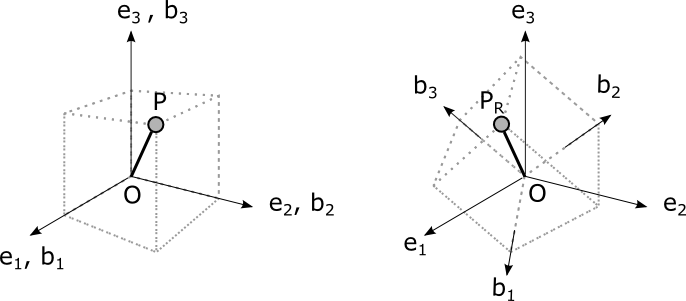

Let $Q$ be another point in space that has the representation $y$ with respect to the $\mathbf{e}$-frame. Then since $R^TR=RR^T=I_{3\times 3}$ we see that $||Rx-Ry||=||x-y||$ and $\langle\langle Rx,Ry\rangle\rangle=\langle\langle x,y\rangle\rangle$  and hence that this map preserves lengths and angles in space. Such maps that transform points in space to other points in space in such a way that it preserves distances between points and angles between lines are called *isometries*. Let us apply this map to all points in space and see how they transform by considering an illustration.
Consider the set of points defined by a cube in space as shown in the left hand side of the figure below. The cube is chosen such that the point $P$ coincides with the vertex of this cube that is diagonally opposite the vertex at the centre of the frame $O$ as shown in the left hand side of figure below.
Since the map that takes $x \to Rx$ preserves lengths and angles in space we see that when the points defining the cube are transformed by $R$ to the new points, using the above recipe,  the new transformed points will also correspond to a cube that is identical to the initial cube with the exception of it now being `rotated' about the vertex $O$. This situation is shown in the right hand side of figure below. Let $\mathbf{b}$ be a frame such that it is fixed with respect to the cube such that initially both $\mathbf{b}$ and $\mathbf{e}$ coincide. It is now easy to see that the new orientation of the frame $\mathbf{b}$ fixed to the cube is related to the frame $\mathbf{e}$ by the relationship $\mathbf{b}=\mathbf{e}R$.

**Thus we see that a given $R\in \mathrm{SO}(3)$ can be uniquely identified with a `rigid rotation' of space and conversely that every rigid rotation of space about a fixed point can be identified with an $R\in \mathrm{SO}(3)$. This also shows that the configuration of a \textit{rigid body} moving such that one of its points remains fixed in space can be uniquely identified with an $R\in \mathrm{SO}(3)$.**


#### Numerical Examples:

In [ ]:
O=np.array([0,0,0]); OP=np.array([1,1,1]); OQ=np.array([1,1,0]);

In [ ]:
fig2=go.Figure()
fig=mr.add_orth_norm_frame(fig2, O,np.eye(3),[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
fig2.add_trace(go.Scatter3d(x=[O[0],OP[0]], y=[O[1],OP[1]], z=[O[2],OP[2]], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color='#ff6600')))
fig2.add_trace(go.Scatter3d(x=[O[0],OQ[0]], y=[O[1],OQ[1]], z=[O[2],OQ[2]], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color='green')))
fig2.show()

In [ ]:
theta_1, theta_2, theta_3=dynamicsymbols('theta_1 theta_2 theta_3', real=True);
R1_theta1=Matrix([[1,0,0],[0,cos(theta_1),-sin(theta_1)],[0,sin(theta_1),cos(theta_1)]])
R2_theta2=Matrix([[cos(theta_2),0,sin(theta_2)],[0,1,0],[-sin(theta_2),0,cos(theta_2)]])
R3_theta3=Matrix([[cos(theta_3),-sin(theta_3),0],[sin(theta_3),cos(theta_3),0],[0,0,1]])

Ra= R1_theta1.subs({theta_1:np.pi/3}) @ R3_theta3.subs({theta_3:np.pi/6});
Rb= R3_theta3 @ R1_theta1;
OPr=Ra @ OP; OQr=Ra @ OQ;

In [ ]:
Ra_np=np.array(Ra).astype(np.float64)
Pr=np.array(OPr).astype(np.float64);
Qr=np.array(OQr).astype(np.float64);

In [ ]:
fig2=go.Figure()
fig2=mr.add_orth_norm_frame(fig2,O,Ra_np,[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
fig2.add_trace(go.Scatter3d(x=[O[0],Pr[0]], y=[O[1],Pr[1]], z=[O[2],Pr[2]], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color='#ff6600')))
fig2.add_trace(go.Scatter3d(x=[O[0],Qr[0]], y=[O[1],Qr[1]], z=[O[2],Qr[2]], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color='green')))
fig2.show()

Numerical Verification of the isometry property

In [ ]:
print([np.sqrt(np.array(OP).dot(np.array(OP))),np.sqrt(np.array(OQ).dot(np.array(OQ)))])

In [ ]:
OPr=Ra @ OP; OQr=Ra @ OQ;
print([sqrt(OPr.dot(OPr)),sqrt(OQr.dot(OQr))])

In [ ]:
PQ=np.array(OQ)-np.array(OP);
print(np.sqrt(PQ.dot(PQ)))
Ra_PQ=Ra @ PQ
print(sqrt(Ra_PQ.dot(Ra_PQ)))

The box in space

In [ ]:
#Defining the vertices of the box
l=3;w=2;h=1;
X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h];

In [ ]:
#Plot the vertices
axisRange=[-1.5*l,1.5*l]
fig=go.Figure()
fig.add_trace(go.Scatter3d(x=X,y=Y,z=Z, mode='markers'))
fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange, autorange=False), yaxis=dict(range=axisRange, autorange=False), zaxis=dict(range=axisRange, autorange=False), aspectratio=dict(x=1, y=1, z=1)))

In [ ]:
Ra_np

In [ ]:
#Transformed vertices
RaX=[];RaY=[];RaZ=[]
for ix,x in enumerate(X):
    RaXX=Ra_np @ [x,Y[ix],Z[ix]]
    RaX+=[RaXX[0]]
    RaY+=[RaXX[1]]
    RaZ+=[RaXX[2]]

In [ ]:
#Plot the transformed vertices
fig.add_trace(go.Scatter3d(x=RaX,y=RaY,z=RaZ, mode='markers'))

### Properties of the Hat Matrix

Let us now revert our attention to the $3\times 3$ skew symmetric matrix $\widehat{\Omega}=R^T\dot{R}$. We will see that it can be interpreted as the angular velocity of the frame $\mathbf{b}$ about $\mathbf{e}$. To do so we will first need to be familiar with several properties of the space of $3\times 3$ skew symmetric matrices, $\mathrm{so}(3)$.

It is straightforward to see that $\mathrm{so}(3)$ is a three dimensional real vector space under matrix addition and scalar multiplication. Thus it is isomorphic to $\mathbb{R}^3$. That is, there is a one-to-one and onto correspondence between elements of $\mathbb{R}^3$ and elements of $\mathrm{so}(3)$. The isomorphism $\:\:\:\widehat{}\:\:: \mathbb{R}^3\to \mathrm{so}(3)$ that is explicitly defined by,
\begin{align*}
\widehat{\Omega}=\left[ \begin{array}{ccc} 0 & -\Omega_3 & \Omega_2 \\ \Omega_3 & 0 & -\Omega_1 \\ -\Omega_2 & \Omega_1 & 0\end{array}\right],
\end{align*}
for $\Omega =(\Omega_1,\Omega_2,\Omega_3)\in \mathbb{R}^3$ gives one such identification. It is easy to verify that $\:\:\:\widehat{}\:\:: \mathbb{R}^3\to \mathrm{so}(3)$ is linear. That is $\widehat{X+Y}=\widehat{X}+\widehat{Y}$ and $\widehat{\alpha X}=\alpha \widehat{X}$ for any $X,Y\in \mathbb{R}^3$ and $\alpha\in \mathbb{R}$.
It is also easy to directly verify that this isomorphism satisfies
\begin{align*}
\widehat{\Omega}X&=\Omega \times X,\\
\langle\langle X,Y\rangle\rangle &=-\frac{1}{2}\mathrm{trace}{(\widehat{X}\widehat{Y})},
\end{align*}
for $X,Y,\Omega\in \mathbb{R}^3$.

The isometric property of $R$ as a mapping also tells us that rotating and taking the cross product is the same as taking the cross product and then rotating. This means that the following property holds:
\begin{align*}
\widehat{RX}&=R\widehat{X}R^T.
\end{align*}

Below, using symbolic computations we will also verify that the following very useful and interesting property of $3\times 3$ skew-symmetric matrices:
\begin{align*}
\widehat{X}^2&= XX^T-||X||^2I_{3\times3}.
\end{align*}
for any $X\in \mathbb{R}^3$ and $R\in \mathrm{SO}(3)$.

#### Numerical Examples:

In [ ]:
X_1, X_2, X_3, Y_1, Y_2, Y_3=symbols('X_1 X_2 X_3 Y_1 Y_2 Y_3');
X=Matrix([X_1,X_2,X_3])
Y=Matrix([Y_1,Y_2,Y_3])
hatX=Matrix([[0, -X_3, X_2],[X_3,0,-X_1],[-X_2,X_1,0]])
hatY=Matrix([[0, -Y_3, Y_2],[Y_3,0,-Y_1],[-Y_2,Y_1,0]])

In [ ]:
hatX @ Y

In [ ]:
X.cross(Y)

In [ ]:
X.dot(Y)

In [ ]:
AA=hatX @ hatY

In [ ]:
-AA.trace()/2

In [ ]:
X @ X.transpose()-X.dot(X)*eye(3)

In [ ]:
hatX**2

### Angular Velocity

Let us now consider smooth rotations that are parameterised by a parameter $t$ that we may consider to be time. Let $R(t)$ be a smooth curve in the space $\mathrm{SO}(3)$ such that $R(0)=I_{3\times 3}$. Then from the above discussion we see that $R(t)$ represents a smooth rigid rotation of space for all $t$. Let $\mathbf{b}(t)=\mathbf{e}R(t)$ be the corresponding rotating frame. Since $R(0)=I_{3\times 3}$ we see that $\mathbf{b}(0)=\mathbf{e}$. Let $P(t)$ be a point in space that corresponds to $P(0)$ being `rotated' by $R(t)$. That is if $X$ is the representation of the point $P(0)$ in the $\mathbf{e}=\mathbf{b}(0)$ frame then $R(t)X$ is the representation of the point $P(t)$ in the
$\mathbf{e}$-frame.
 Thus since rotations by $R$ preserve angles and lengths in space, $P(t)$ will appear to be fixed as viewed in the $\mathbf{b}(t)$ frame and will be equal to $X$. That is, the representation $X$ of the point $P(t)$ in the $\mathbf{b}(t)$ frame will not depend on $t$. Let $x(t)$ be the representation of the point $P(t)$ in the $\mathbf{e}$-frame. Then $x(t)=R(t)X$.
The velocity of the point $P(t)$ in the $\mathbf{e}$-frame is thus given by $\dot{x}(t)=\dot{R}(t)X$.
Previously we have seen that $R^T(t)\dot{R}(t)=\widehat{\Omega}(t)$ is always a skew-symmetric matrix. Thus we have that the velocity of the point $P(t)$ as expressed in the $\mathbf{e}$-frame has the representation
$\dot{x}(t)={R}(t)\widehat{\Omega}(t)X$.
Therefore using the relationship between the cross product and the hat matrix multiplication we see that the velocity of the point $P(t)$ can be expressed in the $\mathbf{e}$-frame as
\begin{align*}
\dot{x}&=\dot{R}X=R\widehat{\Omega}X=R(\Omega \times X)=(R\Omega) \times (RX)=(R\Omega) \times x
=\omega\times x,
\end{align*}
where we have used the property $R(X\times Y)=RX\times RY$ and have set $\omega\triangleq R\Omega$ in the last equality. Notice that $\omega$ is the $\mathbf{e}$-frame representation of the quantity that has the representation $\Omega$ in the $\mathbf{b}$-frame. Also notice that $||\omega||=||R\Omega||=||\Omega||$.  


Since $\omega(t) \times \omega(t)=0$ we see that all points in space that lie along the direction $\omega(t)$ as viewed in the $\mathbf{e}$-frame have zero velocity when $R(t)$ acts on them by a `rotation'.

On the other hand by the definition of the cross product in $\mathbb{R}^3$ and the last equality of the expression ----  we have
\begin{align*}
\dot{x}=||\omega||\,||x||\,\sin{\theta}\,\mathbf{n} \,
\end{align*}
where $\theta$ is the angle between $\omega$ and $x$ in the $\mathbf{e}$-frame as shown in figure below and $\mathbf{n}=\omega/||\omega||$ is an orthonormal direction segment that is both mutually perpendicular to the direction given $\omega=R\Omega$ in the $\mathbf{e}$-frame and $OP$.
Thus we see that $P(t)$ is instantaneously rotating about $\omega(t)$ as viewed in the $\mathbf{e}$-frame. Since $X$ was arbitrary we see that this is true for every point in space. Which shows that under the `rotation' by $R(t)$ every point in space is instantaneously rotating about $\omega$ with an angular rate of rotation equal to $||\omega||=||\Omega||$ as viewed in the frame $\mathbf{e}$.

**The above discussion motivates one to define $\omega(t)=R(t)\Omega(t)$ to be the angular velocity of the frame $\mathbf{b}$ with respect to the frame $\mathbf{e}$ represented in the $\mathbf{e}$-frame. We will call it the spatial angular velocity of the frame $\mathbf{b}$ with respect to $\mathbf{e}$ and since $\Omega$ is its $\mathbf{b}$-frame representation, we will call $\Omega$ the body angular velocity of the frame $\mathbf{b}$ with respect to $\mathbf{e}$.**

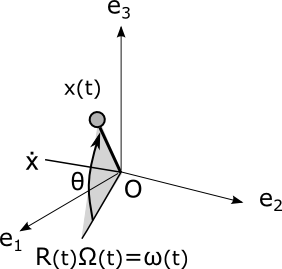

## Angular Momentum in Moving Frames

We observe that the angular momentum $\pi_i$ of a particle $P_i$ about $O'$ can be expressed as
\begin{align*}
\pi_i&= m_i(x_i-o)\times \dot{x}_i=m_iR\left(X_i\times (\Omega\times X_i+\dot{X}_i+R^T\dot{o})\right),\\
&=R\left(-m_i\widehat{X}_i^2\Omega+m_iX_i\times( R^T\dot{o}+ \dot{X}_i)\right),
\end{align*}
where the last equality follows from the skew-symmetric property of the cross product:
\begin{align*}
 X_i\times \Omega\times X_i&=-X_i\times X_i \times \Omega= -\widehat{X}_i^2\Omega.
\end{align*}

The quantity
\begin{align*}
\mathbb{I}_i &\triangleq -m_i\widehat{X}_i^2=m_i\left(||X_i||^2I_{3\times 3} - X_iX_i^T\right),
\end{align*}
is defined as the *moment of inertia* of the particle $P$ about the point $O'$ in the frame $\mathbf{b}$. It is easy to show that this is a positive semi-definite matrix.
Using this we can now express the angular momentum of $P$ about $O'$ as
\begin{align*}
\pi_i&= R\left(\mathbb{I}_i\Omega+m_iX_i\times( R^T\dot{o}+ \dot{X}_i)\right).
\end{align*}
The above expression shows that
\begin{align*}
\Pi_i\triangleq \left(\mathbb{I}_i\Omega+m_iX_i\times(\dot{X}_i+ R^T\dot{o})\right),
\end{align*}
is the representation of the angular momentum of $P_i$ about $O'$ in the moving frame $\mathbf{b}(t)$.

## Summary Laws of Momentum Conservation  Expressed in Moving Frames

In this section we will revisit the consequences of the law of conservation of linear momentum and the assumption that mutual particle interactions align along the line joing the particles has on the motion of a set of particles $P_1,P_2,\cdots,P_n$ as observed in a moving frame $\mathbf{b}$.

We have seen that in an inertial frame $\mathbf{e}$, this gives rise to the expressions:
\begin{align*}
\dot{p}&=f^e\\
\dot{\pi}&=-M\dot{o}\times \dot{\bar{x}}+\tau^e
\end{align*}
where $M$ is the total mass, $p$ is the total reulstant linear momentum, $f^e$ is the total reusltant external interactions acting on the particles, $\pi$ is the total angular momentum of the particles about a point $O'$, $\tau^e$ is the total resultan moment, about $O'$, of the external forces acting on the particles, $\bar{x}$ is the representation of the center of mass of the particles, amd $o$ is the representation of the point $O'$ about which the moments are defined.

Below we will express these using the corrrsponding quantities expressed in a moving frame with origin coinciding with the point $O'$.

### Rate of change of Total Linear Momentum

Since $x_i(t)=o(t)+R(t)X_i(t)$ we see that
\begin{align*}
\bar{x}(t)&=o(t)+R(t)\bar{X}(t),
\end{align*}
where
\begin{align*}
\bar{X}\triangleq \frac{\sum_{i=1}^nm_iX_i}{\sum_{i=1}^nm_i},
\end{align*}
is the center of mass of the body expressed with respect to the body fixed frame $\mathbf{b}$. Differentiating this expression we have
\begin{align*}
\dot{\bar{x}}&=\dot{o}+R\widehat{\Omega} \bar{X}+R \dot{\bar{X}},\\
\ddot{\bar{x}}&=\ddot{o}+ R\left(\widehat{\Omega}^2\bar{X} +2\widehat{\Omega}\dot{\bar{X}}+\dot{\widehat{\Omega}}\bar{X}+\ddot{\bar{X}}\right).
\end{align*}
Thus we see that $\dot{p}=M\ddot{\bar{x}}=f^e$ can alternatively be written by
\begin{align*}
\dot{p}&=M\ddot{o} +M\,R\left(\widehat{\Omega}^2\bar{X} +2\widehat{\Omega}\dot{\bar{X}}+\dot{\widehat{\Omega}}\bar{X}+\ddot{\bar{X}}\right)= RF^e=f^e
\end{align*}
Here $F^e=R^Tf^e$ is the body frame $\mathbf{b}$ representation of the total resultant external forces acting on the particles. *Note that these expressions are valid for a single particle as well as a collection of particles.*

Consider the expression given by the middle equality in the above expression:
\begin{align*}
MR^T\ddot{o} +M\,R\left(\widehat{\Omega}^2\bar{X} +2\widehat{\Omega}\dot{\bar{X}}+\dot{\widehat{\Omega}}\bar{X}+\ddot{\bar{X}}\right)= F^e
\end{align*}
Notice that they are completely  expressed using only the $\mathbf{b}(t)$-frame representation of the force given by $F(t)$, the skew-symmetric matrix $\widehat{\Omega}=R^T\dot{R}$,  the center of mass position given by $\bar{X}(t)$ and the derivatives of it $\dot{\bar{X}}$ and $\ddot{\bar{X}}$. Thus this expression can be considered to be the **appropriate version of the Newton's equations in the rotating frame $\mathbf{b}(t)$.**

Imagine the situation where the observer is unaware of the motion of its frame-$\mathbf{b}$ and thinks of it as an inertial frame. Like for instance when we think of an earth fixed frame to be inertial. Then the observer, having taken a mechanics class during her undergraduate program, will interpret mass times acceleration measured in her reference frame $\mathbf{b}$ to be the force felt in $\mathbf{b}$. That is, she will think that
\begin{align*}
M\ddot{\bar{X}}&=F-\left(MR^T\ddot{o}+M\widehat{\Omega}^2 {\bar{X}}+2M\,\widehat{\Omega}\dot{{\bar{X}}}+M\dot{\widehat{\Omega}}{\bar{X}}\right),
\end{align*}
is the force acting on the particle as expressed in her frame $\mathbf{b}$.
However the quantity $F(t)=R^T(t)f(t)$ is the only physically meaningful force that she feels.
Thus an observer moving with the rotating frame will, in addition to the fundamental interacting forces, feel that there exists another resultant *'apparent force'*:

\begin{align*}
F_{app} &\triangleq  
\underbrace{-M\;R^T(t)\ddot{o}(t)}_{\mbox{Einstein}}\:\underbrace{-M\;\widehat{\Omega}^2(t) {\bar{X}}(t)}_{\mbox{Centrifugal}}\:\underbrace{-\:2M\;\widehat{\Omega}(t)\dot{{\bar{X}}}(t)}_{\mbox{Coriolis}}\:\underbrace{- \:M\;\dot{\widehat{\Omega}}(t) {\bar{X}}(t)}_{\mbox{Euler}},
\end{align*}
simply due to its ignorance of the motion of its frame.

* The first term: $-M\;R^T(t)\ddot{o}(t)$ is known as the *Einstein force*,

* The second term: $-M\;\widehat{\Omega}^2(t) {\bar{X}}(t)$ is known as the *Centrifugal* force,

* The third term $-2M\;\widehat{\Omega}(t)\dot{\bar{X}}(t)$ is known as the *Coriolis* force

* The last term:
$- M\;\dot{\widehat{\Omega}}(t) {\bar{X}}(t)$ is known as the *Euler* force.

Observe that all these apparent forces have mass as a multiplicative factor.
Note that the Einstein apparent force is observed due to the *translational ignorance* of the one's reference frame while the Centrifugal, Coriolis, and Euler forces are observed due to the *rotational ignorance* of the reference frame.

Using these expression we can explain many physical effects. Can you explain why a person standing on a scale
inside an elevator going up sees his or her weight doubled as the elevator accelerates up at a rate of $g$ and sees the weight reduced to zero if the elevator decelerates at a rate of $g$
where $g$ is the gravitational acceleration? Can you also show that if, for some reason, the gravitational force field vanished and the elevator was moving up at an
acceleration of $g$ then the scale would show the correct weight of the person. **This last observation shows that a person inside the elevator can not distinguish between the
following two cases:**

* Gravity is present and the elevator is standing still (or moving at constant velocity).
* Gravity is absent and the elevator is accelerating upwards at a rate of $g$.

It is this observation that led Einstein to the conclusions of General Relativity and in particular that gravity is an apparent force !!!

In the following sections we will demonstrate the value of these equations in writing down the equations of motion.  


From an applications point of view the use of the above expression in predicting the motion of objects moving under complicated geometric constraints is invaluable since in such a case representing position, velocity and the fundamental constraint force interactions is mostly convenient in a frame where the object motion is described most easily.

### Rate of change of Total Angular Momentum

Previously we have seen that the angular momentum of a particle $P_i$ about $O'$ is given by
\begin{align*}
\pi_i&= R\left(\mathbb{I}_i\Omega+m_iX_i\times( R^T\dot{o}+ \dot{X}_i)\right),
\end{align*}
where the quantity
\begin{align*}
\mathbb{I}_i &\triangleq -m_i\widehat{X}_i^2=m_i\left(||X_i||^2I_{3\times 3} - X_iX_i^T\right),
\end{align*}
is defined as the *moment of inertia* of the particle $P_i$ about the point $O'$ and expressed in the frame $\mathbf{b}$.


Differentiating the above expression for $\pi$ and using the Jacobi property of cross products,
\begin{align*}
A\times B\times C+B\times C\times A+C\times A\times B=0
\end{align*}
we find that

\begin{align*}
\dot{\pi}_i&=R\left(\mathbb{I}_i\dot{\Omega}-\mathbb{I}_i{\Omega}\times \Omega+m_i\,\Omega\times X_i\times (R^T\dot{o}+\dot{X}_i) +m_i\dot{X}_i\times( R^T\dot{o}+ \dot{X}_i)+m_iX_i\times (-\Omega \times R^T\dot{o}+R^T\ddot{o}+\ddot{X}_i)\right)\\
&=R\left(\mathbb{I}_i\dot{\Omega}-\mathbb{I}_i{\Omega}\times \Omega+m_i\,\Omega\times X_i\times\dot{X}_i-m_iR^T\dot{o}\times \Omega\times X_i +m_i\dot{X}_i\times R^T\dot{o}+m_iX_i\times (R^T\ddot{o}+\ddot{X}_i)\right).
\end{align*}

On the other hand by differentiating $
\pi_i= m_i(x_i-o)\times \dot{x}_i$ we have that
\begin{align*}
\dot{\pi}_i&= -m_i\dot{o}\times \dot{x}_i+\tau_i,
\end{align*}
where $\tau_i=R^T((x_i-o)\times f_i)$ is the moment of the force acting on $P_i$ about the point $O'$. Thus combining the last two expressions we have

\begin{align*}
R\left(\mathbb{I}_i\dot{\Omega}-\mathbb{I}_i{\Omega}\times \Omega+m_i\,\Omega\times X_i\times\dot{X}_i-m_iR^T\dot{o}\times \Omega\times X_i +m_i\dot{X}_i\times R^T\dot{o}+m_iX_i\times (R^T\ddot{o}+\ddot{X}_i)\right)&=-m_i\dot{o}\times \dot{x}_i+\tau_i
\end{align*}

Summing the above expressions over all the particles and using the fact that $f_i=f_i^e+\sum_{j\neq i}^nf_{ij}$ with $f_{ji}=-f_{ij}$ and that mutual interactions lie along the line joining the particles we have
\begin{align*}
\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega-MR^T\dot{o}\times \Omega\times \bar{X} +M\dot{\bar{X}}\times R^T\dot{o}+M\bar{X}\times R^T\ddot{o}+\sum_{i}m_iX_i\times\ddot{X}_i+\Omega\times \sum_i m_i\,X_i\times\dot{X}_i&=-MR^T\dot{o}\times \Omega \times {\bar{X}}+T^e
\end{align*}
where
\begin{align*}
T^e\triangleq \sum_{i=1}^nX_i\times R^Tf_i^e=R^T\left(\sum_{i=1}^n(x_i-o)\times f_i^e\right)
\end{align*}
is the total resultant moment acting on the body about $O'$ due to the external interaction of the particles of the body
and
\begin{align*}
\mathbb{I}\triangleq \sum_{i=1}^n\mathbb{I}_i =\sum_{i=1}^n -m_i\widehat{X}_i^2=\sum_{i=1}^n m_i\left(||X_i||^2I_{3\times 3} - X_iX_i^T\right),
\end{align*}
is defined to be the **moment of inertia tensor** of the body. It is easy to see that the moment of inertia tensor
$\mathbb{I}$ is symmetric and positive semi-definite and is psitive definite if all particles are not co-planar.

### Summary Expressions for Rate of Change of Total Momentum in a Moving Frame

In summary we have
\begin{align*}
p&=M(\dot{o}+R\widehat{\Omega}\bar{X}+R\dot{\bar{X}})=M\dot{\bar{x}},\\
\pi&= R\left(\mathbb{I}\Omega+M\bar{X}\times R^T\dot{o}+\sum_{i}m_iX_i\times\dot{X}_i\right)
\end{align*}
and their derivates satisfy
\begin{align*}
\dot{p}&=M\ddot{o} +M\,R\left(\widehat{\Omega}^2\bar{X} +2\widehat{\Omega}\dot{\bar{X}}+\dot{\widehat{\Omega}}\bar{X}+\ddot{\bar{X}}\right)= RF^e=f^e,\\
\dot{\pi}&=R\left(\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega-MR^T\dot{o}\times \Omega\times \bar{X} +M\dot{\bar{X}}\times R^T\dot{o}+M\bar{X}\times R^T\ddot{o}+\sum_{i}m_iX_i\times\ddot{X}_i+\Omega\times \sum_i m_i\, X_i\times\dot{X}_i\right)=R\left(-MR^T\dot{o}\times \Omega\times {\bar{X}}+T^e\right)=-M\dot{o}\times \dot{\bar{x}}+\tau^e
\end{align*}

### Special Cases

#### When the origin $O'$ of the moving frame is fixed

In this case $\dot{o}=0$ and hence we obtain
\begin{align*}
p&=M(\dot{o}+R\widehat{\Omega}\bar{X}+R\dot{\bar{X}})=M\dot{\bar{x}},\\
\pi&= R\left(\mathbb{I}\Omega+M\bar{X}\times R^T\dot{o}+\sum_{i}m_iX_i\times\dot{X}_i\right)
\end{align*}
and their derivatives are
\begin{align*}
\dot{p}&=M\,R\left(\widehat{\Omega}^2\bar{X} +\widehat{\Omega}\dot{\bar{X}}+\dot{\widehat{\Omega}}\bar{X}+\ddot{\bar{X}}\right)=  R F^e=f^e,\\
\dot{\pi}&=R\left(\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega+\sum_{i}m_iX_i\times\ddot{X}_i+\Omega\times \sum_i m_i\,\times X_i\times\dot{X}_i\right)=\tau^e
\end{align*}

#### When the particles are rigid with respect to the moving frame (Rigid Body)

In this case $\dot{X}_i=0$ and hence we obtain
\begin{align*}
p&=M(\dot{o}+R\widehat{\Omega}\bar{X})=M\dot{\bar{x}},\\
\pi&= R\left(\mathbb{I}\Omega+M\bar{X}\times R^T\dot{o}\right)
\end{align*}

\begin{align*}
\dot{p}&=M\ddot{o}+R\left(M\,\left(\widehat{\Omega}^2(t) +\dot{\widehat{\Omega}}(t)\right)\bar{X}\right)=  R F^e=f^e,\\
\dot{\pi}&=R\left(\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega-MR^T\dot{o}\times \Omega\times \bar{X} +M\bar{X}\times R^T\ddot{o}\right)=R\left(-MR^T\dot{o}\times \Omega\times {\bar{X}}+T^e\right)=-M\dot{o}\times \dot{\bar{x}}+\tau^e.
\end{align*}

In addition if the origin $O'$ of the moving frame is fixed (that is the body is purely rotating) then we obtain
\begin{align*}
p&=M(\dot{o}+R\widehat{\Omega}\bar{X}+R\dot{\bar{X}})=M\dot{\bar{x}},\\
\pi&= R\mathbb{I}\Omega
\end{align*}
and their derivatives are
\begin{align*}
\dot{p}&=M\,R\left(\widehat{\Omega}^2\bar{X} +\widehat{\Omega}\dot{\bar{X}}+\dot{\widehat{\Omega}}\bar{X}+\ddot{\bar{X}}\right)=  R F^e=f^e,\\
\dot{\pi}&=R\left(\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega\right)=\tau^e
\end{align*}

Below we will re-visit these rigid body equations in bit more detail.

## Examples of Describing Motion in Moving Frames

#### Motion of a Particle in 2D Using Cylindrical Polar Coordinates

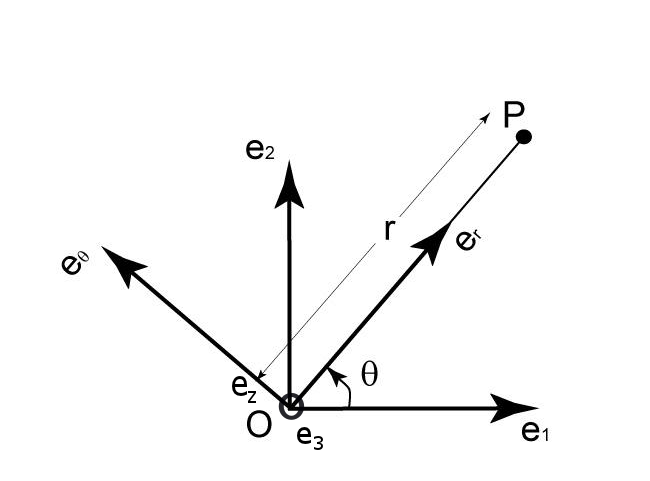

It is sometimes convenient to write down the motion in cylindrical polar coordinates $(r,\theta,z)$. For example this is the case if the particle is restricted to move on the surface of a cylinder.

This amounts to
observing the motion in a moving frame  $\mathbf{b}(t)=[\mathbf{e}_r(t)\:\:\: \mathbf{e}_{\theta}(t)\:\:\: \mathbf{e}_{z}(t)]$ (refer to the figure above for a view from the $\mathbf{e}_3$ axis) where
$\mathbf{e}_r$ aligns along the particle $P$ at all times.  

Consider the orthonormal frame $\mathbf{b}(t)=[\mathbf{e}_r\:\:\:\:\mathbf{e}_{\theta}\:\:\:\:\mathbf{e}_{z}]$.
Let $\mathbf{e}=[\mathbf{e}_1\:\:\:\mathbf{e}_2\:\:\:\mathbf{e}_3]$ be an Earth fixed frame. Then $\mathbf{b}(t)=\mathbf{e}R(t)$ where
\begin{align*}
R(t)=\left[\begin{array}{ccc}\cos{\theta} & -\sin{\theta} & 0\\
\sin{\theta} & \cos{\theta} & 0\\
0 & 0 & 1
\end{array}\right].
\end{align*}
Thus we have
\begin{align*}
\widehat{\Omega}=\begin{bmatrix}0 & -\dot{\theta} &0\\
\dot{\theta} & 0 & 0\\
0 & 0 &0\end{bmatrix},\:\:\:\:\:
\dot{\widehat{\Omega}}=\begin{bmatrix}0 & -\ddot{\theta} &0\\
\ddot{\theta} & 0 & 0\\
0 & 0 &0\end{bmatrix},\:\:\:\:\:\widehat{\Omega}^2=-\dot{\theta}^2\begin{bmatrix}1 & 0 &0\\
0 & 1 & 0\\
0 & 0 &0\end{bmatrix}.
\end{align*}
The representation of $P$ in this frame is
\begin{align*}
X=\left[\begin{array}{c} r\\ 0 \\ z
\end{array} \right]
\end{align*}
and hence we see that
\begin{align*}
\dot{X}=\left[\begin{array}{c} \dot{r}\\
0 \\ \dot{z} \end{array} \right]\:\:\:\:\ddot{X}=\left[\begin{array}{c} \ddot{r}\\
0 \\ \ddot{z} \end{array} \right].
\end{align*}




From Newton's equations in the $\mathbf{b}$-frame given in the previosu section we have
\begin{align*}
m\left[\begin{array}{c} \ddot{r}\\
0\\ \ddot{z}\end{array} \right]=-\left[\begin{array}{c} -m r\dot{\theta}^2\\
0 \\ 0\end{array} \right]-
 \left[\begin{array}{r} 0\\
2m\dot{r}\dot{\theta}\\ 0\end{array} \right]-
  \left[\begin{array}{c} 0\\
mr\ddot{\theta}\\ 0\end{array} \right]
+\left[\begin{array}{c}F_{r}\\
{F}_{\theta}\\ F_z\end{array} \right].
\end{align*}


Observe that the apparent force known as the Centrifugal force is $mr\dot{\theta}^2$ and is in the $\mathbf{e}_r$ direction, the Coriolis force is $-2m\dot{r}\dot{\theta} $ in the $\mathbf{e}_{\theta}$ direction and the Euler force is $-mr\ddot{\theta}$ in the $\mathbf{e}_{\theta}$ direction and we recover what we have learnt in our junior level physics classes.
Simplifying the above equations we have that
\begin{align*}
m\ddot{r} - mr\dot{\theta}^2&= F_r, \\
mr\ddot{\theta} +2m\dot{r}\dot{\theta}&= F_{\theta}\\
m\ddot{z}&=F_z.
\end{align*}

Observe that if we were to constrain the motion of the particle to a circle, then $r$ is a constant and $z\equiv 0$ then we must necessarily exert a physical force, $F_z=0$, $F_r=-mr\dot{\theta}^2$ in the $\mathbf{e}_r$ direction (radial direction) and a force
$F_{\theta}=mr\ddot{\theta}$ in the $\mathbf{e}_\theta$ direction (tangential direction)  to enforce this constraint.
Observe that the radial force that we must exert is equal to the apparent force we call centrifugal force and the tangential force we must exert is equal to the negative of the apparent force we call Euler's force.


#### Bead on a Rotating Hoop

We will consider the problem of analyzing the motion of a bead on a rotating hoop (this section was typed and illustrated by Mr. K. G. B. Gamagedara E/09/078.). A schematic of the system is shown below.

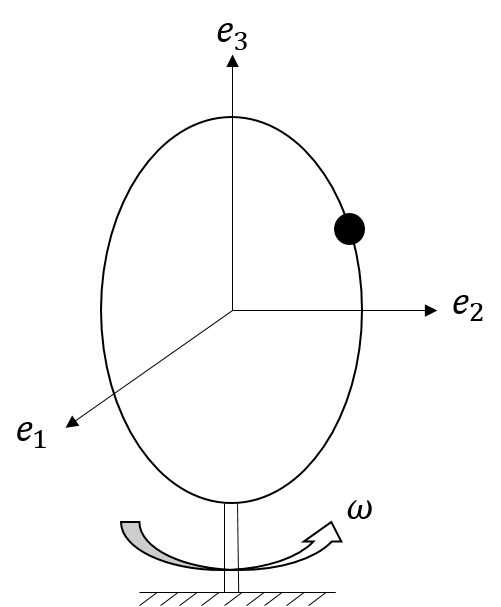

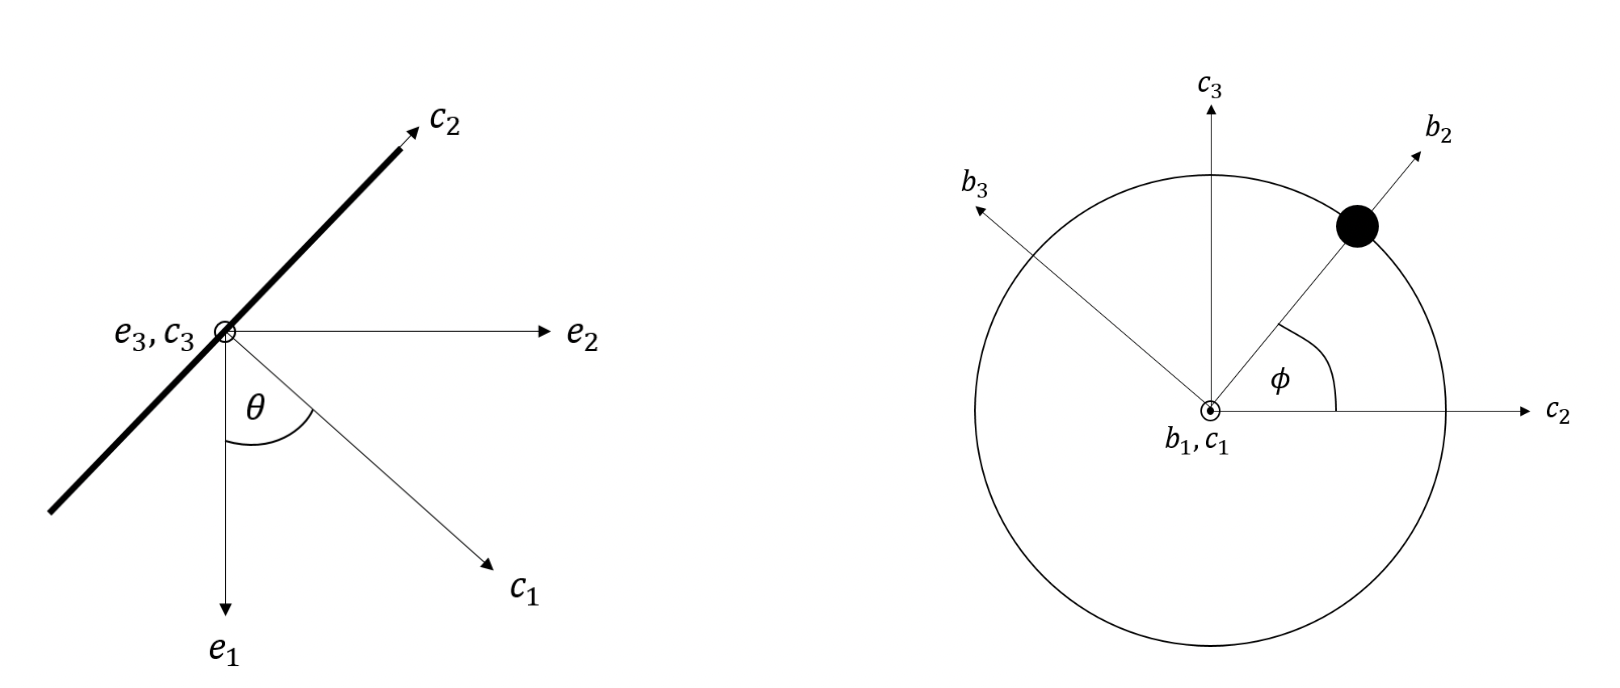

Let us choose frames as shown in the above two figures. Assume that the frame $\mathbf{e}$ is an inertial frame. We will denote by $P$ the position of the bead and by $O$ the origin of the $\mathbf{e}$-frame. Let $\mathbf{c}$
be another orthonormal frame such that it moves with respect to $\mathbf{e}$ in such a way that $\mathbf{c}_3\equiv \mathbf{e}_3$ and $\mathbf{c}_1$ is always orthogonal to the plane of the hoop as shown in the figure above.
Then the two frames $\mathbf{c}$ and $\mathbf{e}$ are related by $\mathbf{c}=\mathbf{e}\,R_3(\theta)$ where we use the customary notation $R_i(\theta)$ to denote a rotation about the $i^\mathrm{th}$ axis by an angle equal to $\theta$. Specifically in this case,
\begin{align*}
R_3(\theta)=\begin{bmatrix}
\cos{\theta}&-\sin{\theta}&0\\
\sin{\theta}&\cos{\theta}&0\\
0&0&1
\end{bmatrix}.
\end{align*}

Let $\mathbf{b}$
be another orthonormal frame such that it moves with respect to $\mathbf{c}$ in such a way that $\mathbf{b}_1\equiv \mathbf{c}_1$ and $\mathbf{b}_2$ is always along $OP$ as shown in the above figure.
Then the two frames $\mathbf{b}$ and $\mathbf{c}$ are related by $\mathbf{b}=\mathbf{c}\,R_1(\phi)$ where
\begin{align*}
R_1(\phi)=\begin{bmatrix}
1&0&0\\
0&\cos{\phi}&-\sin{\phi}\\
0&\sin{\phi}&\cos{\phi}
\end{bmatrix}.
\end{align*}

Thus we have that, the two frames $\mathbf{b}$ and $\mathbf{e}$ are related by $\mathbf{b}=\mathbf{e}\,R_3(\theta)R_1(\phi)=\mathbf{e}\,R$ which gives that $R=R_3(\theta)R_1(\phi)$.

The representation of the position of $P$, in the $\mathbf{b}$ frame is seen to be,
\begin{align*}
X&=\begin{bmatrix}
0\\r\\0
\end{bmatrix},
\end{align*}
and is independent of time and hence we have that $\dot{X}=\ddot{X}=0$. In fact it is this very convenient reason why we chose the $\mathbf{b}$-frame to move with the particle.

The Newton's equation in the $\mathbf{b}$-frame then becomes, $F=m(\widehat{\Omega}^2+\dot{\widehat{\Omega}})X$,
where $F$ is the representation, in $\mathbf{b}$, of the fundamental forces acting on the bead due to its interaction with the rest of the Universe.

Notice that it is convenient to express the constraint interactions in the frame $\mathbf{b}$ while it is convenient to express the gravitational interaction in the $\mathbf{c}$-frame. Thus if $f$ is the representation of the force in the $\mathbf{e}$-frame and $F$ is the representation of the force in the $\mathbf{b}$-frame we have that
\begin{align*}
\mathbf{e}\,f=\mathbf{b}\,F&=
\mathbf{b}\begin{bmatrix}
F_{N1}\\ F_{N2}\\ 0
\end{bmatrix}
+\mathbf{c}
\begin{bmatrix}
0\\0\\-mg
\end{bmatrix}=\mathbf{b}\begin{bmatrix}
F_{N1}\\ F_{N2}\\ 0
\end{bmatrix}
+\mathbf{b}\,R_1^T(\phi)
\begin{bmatrix}
0\\0\\-mg
\end{bmatrix}
\end{align*}
Hence we have
\begin{equation*}
F=
\begin{bmatrix}
F_{N1}\\ F_{N2}\\ 0
\end{bmatrix}
+R_1^T(\phi)
\begin{bmatrix}
0\\0\\-mg
\end{bmatrix}=
\begin{bmatrix}
F_{N1}\\ F_{N2}-mg\sin{\phi}\\ -mg\cos{\phi}
\end{bmatrix}.
\end{equation*}



Now that we have found $F$ what remains to write down the Newton's equations $F=m(\widehat{\Omega}^2+\dot{\widehat{\Omega}})X$ explicitly in the moving frame $\mathbf{b}$ is the computation of $\dot{\widehat{\Omega}}$ and ${\widehat{\Omega}}^2$. We know that
$\widehat{\Omega}=R^T\dot{R}$.
Since
\begin{align*}
\dot{R}&=R_3\widehat{\Omega}_3R_1+R_3R_1\widehat{\Omega}_1=R(R_1^T\widehat{\Omega}_3R_1+\widehat{\Omega}_1)
\end{align*}
we have that
\begin{align*}
\widehat{\Omega}=R_1^T\widehat{\Omega}_3R_1+\widehat{\Omega}_1.
\end{align*}
Recall that $\widehat{R\Omega}=R\widehat{\Omega}R^T$. Thus using the linearity of the $\:\widehat{}\:$ isomorphism we find that the $3\times 1$ version of $\widehat{\Omega}$ is explicitly given by
\begin{align*}
\Omega &= R_1^T(\phi)\Omega_3+\Omega_1=
\begin{bmatrix}
\dot{\phi} \\ \dot{\theta}\sin\phi \\ \dot{\theta}\cos\phi
\end{bmatrix}
\end{align*}
and hence that
\begin{align*}
\dot{\Omega} &=
\begin{bmatrix}
\ddot{\phi} \\ \ddot{\theta}\sin\phi+\dot{\theta}\dot{\phi}\cos\phi \\ \ddot{\theta}\cos\phi-\dot{\theta}\dot{\phi}\sin\phi
\end{bmatrix}.
\end{align*}
From these we have that the corresponding skew-symmetric matrices are given by
\begin{align*}
\widehat{\Omega} &=
\begin{bmatrix}
0 & -\dot{\theta}\cos\phi & \dot{\theta}\sin\phi \\
\dot{\theta}\cos\phi &0 &-\dot{\phi} \\
-\dot{\theta}\sin\phi &\dot{\phi} &0
\end{bmatrix}
\end{align*}
\begin{align*}
\dot{\widehat{\Omega}} &=
\begin{bmatrix}
0 & -(\ddot{\theta}\cos\phi-\dot{\theta}\dot{\phi}\sin\phi) & (\ddot{\theta}\sin\phi+\dot{\theta}\dot{\phi}\cos\phi) \\
(\ddot{\theta}\cos\phi-\dot{\theta}\dot{\phi}\sin\phi) &0 &-\ddot{\phi} \\
-(\ddot{\theta}\sin\phi+\dot{\theta}\dot{\phi}\cos\phi) &\ddot{\phi} &0
\end{bmatrix}.
\end{align*}

Note that
$\widehat{\Omega}^2=\Omega\Omega^T-||\Omega||^2I$ and hence that
\begin{align*}
\widehat{\Omega}^2 &=
\left[\begin{array}{ccc}  - {\dot{\theta}}^2 & \dot{\phi}\, \dot{\theta}\, \sin\phi & \dot{\phi}\, \dot{\theta}\, \cos\phi\\ \dot{\phi}\, \dot{\theta}\, \sin\phi &  - {\dot{\phi}}^2 - {\dot{\theta}}^2\, {\cos\phi}^2 & {\dot{\theta}}^2\, \cos\phi\, \sin\phi\\ \dot{\phi}\, \dot{\theta}\, \cos\phi & {\dot{\theta}}^2\, \cos\phi\, \sin\phi &  - {\dot{\phi}}^2 - {\dot{\theta}}^2\, {\sin\phi}^2 \end{array}\right]
\end{align*}

Substituting these in the Newton's equations in the $\mathbf{b}$-frame we have
\begin{equation*}
\begin{bmatrix}
F_{N1}\\ F_{N2}\\ 0
\end{bmatrix}
=m\begin{bmatrix}
  -r\ddot{\theta}\cos{\phi} + 2r\dot{\phi}\dot{\theta}\sin{\phi}\\
 -r\dot{\phi}^2 - r\dot{\theta}^2\cos{\phi}^2 + g\sin{\phi} \\
    r\dot{\theta}^2\sin\phi\cos\phi + r\ddot{\phi} + g\cos{\phi}
\end{bmatrix}.
%\label{eq:F_values}
\end{equation*}

The first two rows can be used to find the constraint forces $F_{N1}$ and $F_{N2}$ that constrain the bead to stay on the hoop while the third row can be used to describe the motion of the bead as follows:
\begin{equation*}
r\ddot{\phi}=-\cos{\phi}\left(g+\dot{\theta}^2\sin\phi\right).
%\label{eq:charac_eqn}
\end{equation*}


##### Simulating the motion of the bead on a hoop rotating at a constant rate

In [ ]:
def bead_on_hoop(X,t, parameters):
  g=9.806;
  dtheta=parameters[0];
  phi=X[0];
  dphi=X[1];
  ddphi=-np.cos(phi)*(g+dtheta**2*np.sin(phi));
  return [dphi, ddphi]

In [ ]:
omega=1;
[t,sol,fig]=mr.simulate_dy_system(bead_on_hoop, 50,0.01, [np.pi/3,0], [omega], 'Bead on a Hoop', 'Time / t', '$\phi,\dot{\phi}$')

In [ ]:
xx=[]; yy=[]; zz=[]; XX=[];
for ii,tt in enumerate(t):
  omegat=omega*tt;
  phit=sol[ii][1]
  R3theta=np.array([[np.cos(omegat), -np.sin(omegat), 0],[np.sin(omegat), np.cos(omegat),0],[0,0,1]]);
  R1phi=np.array([[1,0,0],[0, np.cos(phit), -np.sin(phit)],[0,np.sin(phit), np.cos(phit)]]);
  R=R3theta @ R1phi;
  r=1;
  temp=R @ np.array([0,r,0]);
  XX+=[[jj for jj in temp]];

In [ ]:
fig=mr.animate_particle_motion(XX,[[-1.2,1.2],[-1.2,1.2],[-1.2,1.2]],'Bead on a Hoop')

#### Effects of Earth's Rotation About its Axis

In the following we also use Newton's equations in a moving frame to show the effects of Earths rotation on gravity,
formation of hurricanes and the motion of a long pendulum known as the Foucault's pendulum.

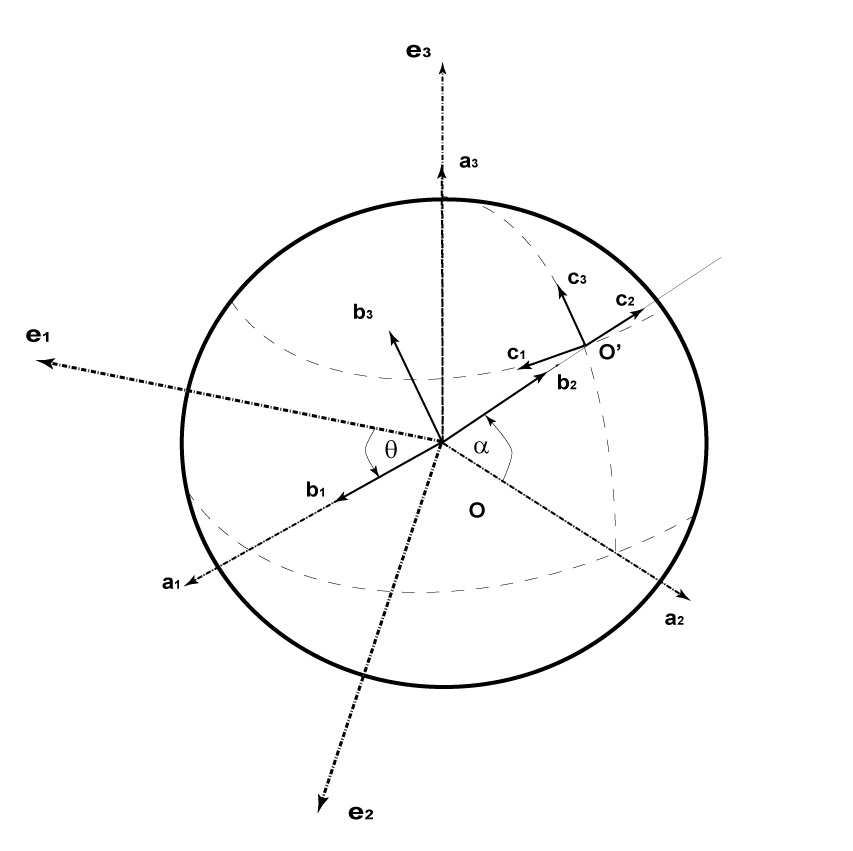


Let us consider the effect that the Earth's rotation about its axis has on the motion of a particle as observed in an Earth fixed frame at a point $O'$ (with latitude $\alpha$) on the
surface of the Earth. Consider the figure above. Let $\mathbf{c}(t)$ be an ortho-normal frame fixed on Earth with center at $O'$. The frame is oriented such that $\mathbf{c}_2$ is aligned
perpendicular to the Earth (vertical direction), $\mathbf{c}_3$ is aligned in the South - North direction (towards north along the latitude), and $\mathbf{c}_1$ is aligned in the East - West direction
(towards west along the longitude). Let $b$ be a frame that is parallel to $\mathbf{c}$ and fixed on Earth with origin at the center of the Earth $O$. Let $a$ be a frame with origin at $O$ and
$\mathbf{a}_3$ aligned along the axis of rotation of the Earth, $\mathbf{a}_1 \equiv \mathbf{b}_1$ and $O'$ lies in the $\mathbf{a}_2 - \mathbf{a}_3$ plane as shown in the above figure.
Thus if $\mathbf{b}(t)=\mathbf{a}(t)R_1(\alpha)$
where $\alpha$ is the latitude angle and is a constant and $R_1(\alpha)$ is one of the three basic rotations we have seen beofre. Let $e$ be a frame with origin, $O$, at the center of Earth and parallel to a frame fixed on the sun. The frame is oriented such that the $\mathbf{e}_3$ direction coincides with the axis of
rotation of the Earth, ie $\mathbf{a}_3\equiv \mathbf{e}_3$ and $\mathbf{a}(t)=\mathbf{e}\,R_3(\theta)$ where $\theta$ is the angle of rotation of the Earth about its axis.


We are interested in analyzing the motion of a particle $P$ as observed in the frame $\mathbf{c}(t)$. Let the representation of the point $P$ in the $\mathbf{c}(t)$ frame be $X_p(t)$, ie. $O'P=\mathbf{c}(t)X_p(t)
$. Since $OO'=\mathbf{c}(t)o$ and $\mathbf{c}$ is parallel to $\mathbf{b}$ we have that $OP=OO'+O'P=\mathbf{b}(t)(o+X_p)$.  Since by construction $O'$ is a distance $r$ ($r$ is the radius of the Earth) away on the
$\mathbf{b}_2$ axis, $o=[0\:\:\:r\:\:\:0]^T$ and is a constant.


Thus if $x(t)$ is the representation of $P$ in $\mathbf{e}$ we have
\begin{align*}
\mathbf{e}\,x(t)=\mathbf{b}(t)\,(o+X_p(t))=\mathbf{e}R_3R_1\underbrace{(o+X_p(t))}_{X}=\mathbf{e}RX.
\end{align*}
Thus $x=RX(t)$
where $R=R_3R_1$ and $X=o+X_p$.
From Newton's equations in the rotating frame we have
\begin{align*}
m\, \ddot{X}(t)=-m\;\widehat{\Omega}^2(t) X(t)-2m\;\widehat{\Omega}(t)\dot{X}(t)- m\;\dot{\widehat{\Omega}}(t) X(t)+R^Tf(t).
\end{align*}
Let us decompose the total force in to two components $f=f^g+f^e$ where $f^g$ is the gravitational force and $f^e$ is the additional external forces.
Gravity acts in the $OP$ direction. Thus
\begin{align*}
f^g=-\frac{mg}{||x||}x=-\frac{mg}{||X||}RX,
\end{align*}
and hence
\begin{align*}
R^Tf^g=-\frac{mg}{||X||}X.
\end{align*}
Substituting this in the expression above and noting that the Earth is rotating at a constant rate (hence $\dot{\widehat{\Omega}}=0$)  we have
\begin{align*}
\ddot{X} &=-\widehat{\Omega}^2X-2\widehat{\Omega}\dot{X}-g\frac{X}{||X||}+\frac{1}{m}R^Tf^e,\\
 &=-2\widehat{\Omega}\dot{X}-\left(gI_{3\times 3}+||X||\widehat{\Omega}^2 \right)\frac{X}{||X||}+\frac{1}{m}R^Tf^e.
\end{align*}
*Observe that these equations describe the motion of a particle as observed in a frame fixed on Earth with origin coinciding with the center of the Earth.*

From the expression above it can also be seen that the motion of the particle in the Earth fixed frame, in addition to the gravity and external forces, is also influenced by the
Centrifugal and Coriolis terms that arise due to the ignorance of the rotation of the Earth. In the equation above the Centrifugal term has been combined with the gravity term.
This allows one to see that the effective gravity felt by an observer will change with the latitude of the location of the observer. We will explain this in a bit more detail at the end of this section.



Recall $X=o+X_p$ where $o$ is a constant and  $X_p$ is the representation of the point $P$ in the Earth fixed frame $c$ fixed on the surface of the Earth at $O'$. Then $\dot{X}=
\dot{X}_p$ and $\ddot{X}=\ddot{X}_p$ thus we have that
\begin{align*}
\ddot{X}_p&=-2\widehat{\Omega}\dot{X}_p-\left(gI_{3\times 3}+||X_p+o||\widehat{\Omega}^2 \right)\frac{X_p+o}{||X_p+o||}+\frac{1}{m}R^Tf^e\nonumber\\
&=-2\widehat{\Omega}\dot{X}_p-\widehat{\Omega}^2{X}_p-\frac{g}{||X_p+o||}(X_p+o)-\widehat{\Omega}^2 o+\frac{1}{m}R^Tf^e
\end{align*}
describes the motion of a point particle $m$ *as observed in the Earth fixed frame with origin $O'$ on the surface of the Earth. This is the case that applies to us when we
observe particle motion.* Since compared to $X_p$ the quantity $o$ is very large (since $r$ is very large) we can approximate $||(X_p+o)||\approx r$  and $(X_p+o)/||(X_p+o)||\approx o$ and then the above expression approximates to
\begin{align*}
\ddot{X}_p=-2\widehat{\Omega}\dot{X}_p-\widehat{\Omega}^2{X}_p-\left(gI_{3\times 3}+r\widehat{\Omega}^2 \right)\chi+\frac{1}{m}R^Tf^e,
\end{align*}
where $\chi=[0\:\:\:1\:\:\:0]^T$.

These equations can be used to describe many natural phenomena. For instance it explains why a Hurricane formed in the Nothern hemisphere rotates in a counter--clockwise
direction and a Hurricane formed in the Southern hemisphere rotates in a  clockwise direction.

The rotational velocity of the Earth,
$\Omega_e =
\frac{2\pi}{23h \:56m \:4 s}
= 7.292 \times 10^{-5} rad/s$, is very small and thus $\widehat{\Omega}$ and $\widehat{\Omega}^2$ are very small and for most applications these effects can be neglected and then the equations above
reduce to the usual equations of projectile motion given by
\begin{align*}
\ddot{X}_p=-g\chi+\frac{1}{m}R^Tf^e.
\end{align*}
Explicitly written down they are:
\begin{align*}
\ddot{X}_{p_1} &= \frac{1}{m}F_1,\\
\ddot{X}_{p_2} &= -g+\frac{1}{m}F_2,\\
\ddot{X}_{p_3} &= \frac{1}{m}F_3.
\end{align*}


##### Numerical computations of the effects of Earth's rotation

Let us now explicitly consider the effects of the rotation of Earth. Let
\begin{align*}
\gamma(t)&\triangleq-\left(gI_{3\times 3}+r\widehat{\Omega}^2 \right)\chi+\frac{1}{m}R^Tf^e,
\end{align*}
and then
 \begin{align*}
\ddot{X}_p=-2\widehat{\Omega}\dot{X}_p-\widehat{\Omega}^2{X}_p-\left(gI_{3\times 3}+r\widehat{\Omega}^2 \right)\chi+\frac{1}{m}R^Tf^e,
\end{align*}
can be expressed as
\begin{align*}
\ddot{X}_p=-\widehat{\Omega}^2{X}_p-2\widehat{\Omega}\dot{X}_p+\gamma(t),
\end{align*}
Defining $Z_p=[X_p^T\:\:\:\:\dot{X}_p^T]^T$ we can arrange this equation as
\begin{align*}
\dot{Z}_p=AZ_p+B(t),
\end{align*}
where
\begin{align*}
A=\begin{bmatrix}0 & I_{3\times 3}\\-\widehat{\Omega}^2 & -2\widehat{\Omega}\end{bmatrix},
\:\:\:\:
B(t)=\begin{bmatrix}0 \\ \gamma(t)\end{bmatrix}.
\end{align*}
From linear systems theory we find that the solution to this differential equation is explicitly given by
\begin{align*}
{Z}_p(t)=e^{At}{Z}_p(0)+\int_0^te^{A(t-\tau)}B(\tau)\,d\tau.
\end{align*}



To compute $e^{At}$ we need $\widehat{\Omega}$ that is given by $R^T\dot{R}=\widehat{\Omega}$. Since $R=R_3R_1$ differentiating we have that
\begin{align*}
\dot{R}=\dot{R}_3R_1=R_3\widehat{\Omega}_eR_1=R_3R_1\, R_1^T\widehat{\Omega}_eR_1=R\widehat{\Omega},
\end{align*}
Now from $\dot{R}_3=R_3\widehat{\Omega}_e$  we have that
\begin{align*}
\widehat{\Omega}_e=
\begin{bmatrix}
0  & -\dot{\theta}_e & 0\\
\dot{\theta}_e & 0 & 0\\
0 & 0 & 0
\end{bmatrix},
\end{align*}
where $\dot{\theta}=\dot{\theta}_e$ is the angular velocity of Earth about its axis of rotation.
Hence we have  that
\begin{align*}
\widehat{\Omega}=R_1^T\widehat{\Omega}_eR_1.
\end{align*}
 Thus we have
\begin{align*}
\widehat{\Omega}=\dot{\theta}_e
\begin{bmatrix}
0 & -\cos{\alpha} & \sin{\alpha} \\
\cos{\alpha} & 0 & 0\\
-\sin{\alpha} & 0 & 0
\end{bmatrix},
\end{align*}
and
\begin{align*}
\widehat{\Omega}^2= -\dot{\theta}^2_e
\begin{bmatrix}
1 & 0 & 0\\
0 & \cos^2{\alpha} & -\cos{\alpha}\sin{\alpha} \\
0 & -\cos{\alpha}\sin{\alpha}  & \sin^2{\alpha}
\end{bmatrix}.
\end{align*}
Substituting these in in the above expressions we can explicitly find $X_p(t)$ and
$\dot{X}_p(t)$.

Below we will do this for a special case where the observer is on the equator of the Earth.



**Dropping a cannon from a geostationary weather balloon**
that is  at a point which is directly $h$ meters above a point on the equator. Where will the cannon land?

At the equator the latitude is zero, that is $\alpha=0$. Since no other external forces are present $F=0$. Also since the cannon is released carefully $\dot{X}_p(0)=[0\:\:\:0\:\:\:0]^T$ and ${X}_p(0)=[0\:\:\:h\:\:\:0]^T$
In this case
\begin{align*}
\widehat{\Omega}= \dot{\theta}_e
\begin{bmatrix}
0 & -1 & 0 \\
1 & 0 & 0\\
0 & 0 & 0
\end{bmatrix},\:\:\:\:\:\:
\widehat{\Omega}^2= -\dot{\theta}^2_e
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0  & 0
\end{bmatrix},\:\:\:
\gamma=-(g-r\dot{\theta}_e^2)\begin{bmatrix}0 \\ 1\\ 0\end{bmatrix}.
\end{align*}


\begin{align*}
e^{At}=\begin{bmatrix} \cos\!\left(t\, \dot{\theta}_e\right) + t\, \dot{\theta}_e\, \sin\!\left(t\, \dot{\theta}_e\right) & \sin\!\left(t\, \dot{\theta}_e\right) - t\, \dot{\theta}_e\, \cos\!\left(t\, \dot{\theta}_e\right) & 0 & t\, \cos\!\left(t\, \dot{\theta}_e\right) & t\, \sin\!\left(t\, \dot{\theta}_e\right) & 0\\ t\, \dot{\theta}_e\, \cos\!\left(t\, \dot{\theta}_e\right) - \sin\!\left(t\, \dot{\theta}_e\right) & \cos\!\left(t\, \dot{\theta}_e\right) + t\, \dot{\theta}_e\, \sin\!\left(t\, \dot{\theta}_e\right) & 0 & - t\, \sin\!\left(t\, \dot{\theta}_e\right) & t\, \cos\!\left(t\, \dot{\theta}_e\right) & 0\\ 0 & 0 & 1 & 0 & 0 & t\\ t\, \dot{\theta}_e^2\, \cos\!\left(t\, \dot{\theta}_e\right) & t\, \dot{\theta}_e^2\, \sin\!\left(t\, \dot{\theta}_e\right) & 0 & \cos\!\left(t\, \dot{\theta}_e\right) - t\, \dot{\theta}_e\, \sin\!\left(t\, \dot{\theta}_e\right) & \sin\!\left(t\, \dot{\theta}_e\right) + t\, \dot{\theta}_e\, \cos\!\left(t\, \dot{\theta}_e\right) & 0\\ - t\, \dot{\theta}_e^2\, \sin\!\left(t\, \dot{\theta}_e\right) & t\, \dot{\theta}_e^2\, \cos\!\left(t\, \dot{\theta}_e\right) & 0 &  - \sin\!\left(t\, \dot{\theta}_e\right) - t\, \dot{\theta}_e\, \cos\!\left(t\, \dot{\theta}_e\right) & \cos\!\left(t\, \dot{\theta}_e\right) - t\, \dot{\theta}_e\, \sin\!\left(t\, \dot{\theta}_e\right) & 0\\ 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix}
\end{align*}

Then from the above expressions for the motion of the particle and the initial conditions we have
\begin{align*}
X_p(t)=h\begin{bmatrix}\sin\!\left(t\, \dot{\theta}_e\right) - t\, \dot{\theta}_e\, \cos\!\left(t\, \dot{\theta}_e\right)\\
\cos\!\left(t\, \dot{\theta}_e\right) + t\, \dot{\theta}_e\, \sin\!\left(t\, \dot{\theta}_e\right)\\ 0
\end{bmatrix}
-(g-r\dot{\theta}_e^2)\int_0^t\begin{bmatrix}(t-\tau)\sin{(\dot{\theta}_e(t-\tau))} \\ (t-\tau)\cos{(\dot{\theta}_e(t-\tau))} \\0\end{bmatrix}d\tau
\end{align*}
Using a power series expansion of the $\sin$ and $\cos$ terms and neglecting terms of $\dot{\theta}_e^3$ and higher we have
\begin{align*}
X_p(t)&=h\begin{bmatrix}0\\
\left(1-\frac{t^2\dot{\theta}_e^2}{2}\right)\\ 0
\end{bmatrix}
-(g-r\dot{\theta}_e^2)\int_0^t\begin{bmatrix}\dot{\theta}_e(t-\tau)^2 \\ (t-\tau)-\frac{\dot{\theta}_e^2(t-\tau)^3}{2} \\0\end{bmatrix}d\tau\\
&=h\begin{bmatrix}0\\
\left(1-\frac{t^2\dot{\theta}_e^2}{2}\right)\\ 0
\end{bmatrix}
-(g-r\dot{\theta}_e^2)\begin{bmatrix}\frac{\dot{\theta}_et^3}{3} \\ \frac{t^2}{2}-\frac{\dot{\theta}_e^2t^4}{8} \\0\end{bmatrix}.
\end{align*}
Let $T$ be the time it takes for the cannon to land on the ground. That is $X_{p_2}(T)\approx 0$. Thus from the second line of the matrix expression above we have
\begin{align*}
T\approx\sqrt{\frac{2h}{(g-r\dot{\theta}_e^2)}}.
\end{align*}
At this time instant the first line of the matrix expression above gives us that
\begin{align*}
X_{p_1}(T)\approx -\frac{(g-r\dot{\theta}_e^2)\dot{\theta}_e}{3}T^3=-\frac{2h\dot{\theta}_e}{3}\sqrt{\frac{2h}{(g-r\dot{\theta}_e^2)}}
\end{align*}

That is, a cannon dropped from a vertical height, $h$, from a point $O'$ on the equator will land at a distance ${(2h\dot{\theta}_e/3)}\sqrt{{2h}/{(g-r\dot{\theta}_e^2)}}$ to the East from $O'$. Approximately if
$h=500\,m$ then $T\approx 10s$ and the cannon will fall $1\,cm$ towards the East. Can you explain why it would fall to the East instead of the West?



###### **Verify your answer using numerical simulations**

by simulating
\begin{align*}
\ddot{X}_p=-2\widehat{\Omega}\dot{X}_p-\widehat{\Omega}^2{X}_p-\left(gI_{3\times 3}+r\widehat{\Omega}^2 \right)\chi+\frac{1}{m}R^Tf^e,
\end{align*}
where $\chi=[0\:\:\:1\:\:\:0]^T$ and
\begin{align*}
\widehat{\Omega}=\dot{\theta}_e
\begin{bmatrix}
0 & -\cos{\alpha} & \sin{\alpha} \\
\cos{\alpha} & 0 & 0\\
-\sin{\alpha} & 0 & 0
\end{bmatrix},
\end{align*}
and $\alpha$ being the latitude.

## Kinetic Energy in a Moving Frame

Recall that the kinetic energy $KE_i$ of a particle of mass $m_i$ is defined with respect to an \textit{inertial frame} $\mathbf{e}$ and is given by the relationship
\begin{equation*}
\mathrm{KE}_i \triangleq \frac{1}{2}m_i ||\dot{x}_i(t)||^2,
\end{equation*}
where $||\cdot||$ is the Euclidian norm in $\mathbb{R}^3$.
Since $||R X||=||X||$ we also have that the kinetic energy of the particle can also be expressed as
\begin{align*}
\mathrm{KE}_i&=\frac{1}{2}m ||\dot{x}_i||^2=\frac{1}{2}m ||R^T \dot{x}_i||^2=\frac{1}{2}m ||R^T\dot{o}+\widehat{\Omega} X_i+\dot{X}_i||^2,\\
&=\frac{1}{2}m \left( ||\dot{o}||^2+2\dot{o}^TR(\widehat{\Omega} X_i+\dot{X}_i)+||\widehat{\Omega} X_i||^2+2\dot{X}_i^T\widehat{\Omega}X_i+||\dot{X}_i||^2\right).
\end{align*}
Note that $||\widehat{\Omega}X_i||^2=||\widehat{X}_i\Omega||^2=-\Omega^T\widehat{X}_i^2\Omega$. Using the substitution $\mathbb{I}_i=-m_i\widehat{X}_i^2=m_i(||X_i||^2I_{3\times 3}-X_iX_i^T)$ the kinetic energy of the particle can be expressed as
\begin{equation}
\mathrm{KE}_i=\frac{1}{2}\left( m_i||\dot{o}||^2+2m_i\dot{o}^TR(\widehat{\Omega} X_i+\dot{X}_i)+\Omega^T\mathbb{I}_i\Omega+2m_i\dot{X}_i^T\widehat{\Omega}X_i+m_i||\dot{X}_i||^2\right).
\end{equation}

If the particle $P$ is fixed with respect to the moving frame $\mathbf{b}$ then ${X}_i=\mathrm{constant}$ and hence
\begin{align*}
\mathrm{KE}_i&=\frac{1}{2} \left( m_i||\dot{o}||^2+2m_i\dot{o}^TR({\Omega} \times X_i)+\Omega^T\mathbb{I}_i\Omega
\right),\nonumber\\
&=\frac{1}{2} \left( m_i||V_{o}||^2+2m_iV_o({\Omega} \times X_i)+\Omega^T\mathbb{I}_i\Omega
\right),
\end{align*}
where we have used the identity $V_o=R^T\dot{o}$ in the last expression.

# The Space of Rotations $SO(3)$

In the section 'Infinitesimal Rotations' we saw that $R \in  SO(3)$ can be thought of as a map that transforms points in space to other points in space in such a way that it preserves distances between points and angles between lines. That is, every $R\in \mathrm{SO}(3)$ can be viewed as a rigid rotation of space. Conversely, since we have seen that two frames with coinciding origins are related by $\mathbf{b}=\mathbf{e}\,R$, every rigid body rotation about a fixed point can also be identified with an $R\in \mathrm{SO}(3)$ by fixing an orthonormal frame $\mathbf{b}$ on the rigid body and finding its relationship with some inertial frame-$\mathbf{e}$. We also saw that $R\in \mathrm{SO}(3)$ can be seen as a coodinate transformation between the two frames $\mathbf{b}$ and $\mathbf{e}$.

In what follows we will take a closer look at all possible rigid body rotations. Or in other words we will try to get some insight about the structure of the space $\mathrm{SO}(3)$.



## Non-Commutatitivty of Composition of Rotations

In $\mathbb{R}^3$ the binary operation of addition that makes it a vector space is commutative.  Below we will see that the space of rotations, $SO(3)$, even though is closed under the composition of rotations is not a vector space under composition of rotations since the composition of rotations is not commutative. This indicates a quite significant difference with $\mathbb{R}^3$.

To see this let us first consider composition of rotations by considering three frames $\mathbf{e}$, $\mathbf{a}$ and $\mathbf{b}$. Let $R_{\alpha},R_{\beta}\in \mathrm{SO}(3)$.
Consider the two rotations of space that take the frame $\mathbf{e}$ to $\mathbf{a}$ and and the frame $\mathbf{a}$ to $\mathbf{b}$ respectively such that $\mathbf{a}=\mathbf{e}R_{\alpha}$ and $\mathbf{b}=\mathbf{a}R_{\beta}$. Since $\mathbf{b}=\mathbf{a}R_{\beta}=\mathbf{e}R_{\alpha}R_{\beta}$ we see that $R=R_{\alpha}R_{\beta}$ is a rotation that takes $\mathbf{e}$ to $\mathbf{a}$ by a rotation $R_{\alpha}$ and then to $\mathbf{b}$ by a rotation $R_{\beta}$. Thus composition of rotations correspond to right multiplication by the corresponding rotation matrix.

Also consider the two rotations of space that takes the frame $\mathbf{e}$ to $\mathbf{a}'$ and and the frame $\mathbf{a}'$ to $\mathbf{b}'$ respectively such that $\mathbf{a}'=\mathbf{e}R_{\beta}$ and $\mathbf{b}'=\mathbf{a}'R_{\alpha}$. Since $\mathbf{b}'=\mathbf{a}'R_{\alpha}=\mathbf{e}R_{\beta}R_{\alpha}$ we see that $R=R_{\beta}R_{\alpha}$ is a rotation that takes $\mathbf{e}$ to $\mathbf{a}'$ by a rotation $R_{\beta}$ and then to $\mathbf{b}'$ by a rotation $R_{\alpha}$. Since in general matrix multiplication is non-commutative $R_{\alpha}R_{\beta}\neq R_{\beta}R_{\alpha}$ and therefore the final frames in the two cases above $\mathbf{b}$ and $\mathbf{b}'$ will not be the same.

*Thus in general, a rotation by $R_{\alpha}$ followed up by a rotation $R_{\beta}$ will not be the same as a rotation by $R_{\beta}$ followed up by a rotation $R_{\alpha}$. That is rotations do not commute.*

Let us illustrate this non-commutatitivity of rotations using some specific easy to visualize  examples.
Now consider a counter clockwise rotation first about the third axis by an angle equal to $\pi/2$ and then about the first axis by an angle equal to $\pi/2$. The resultant frame
$\mathbf{b}$ is then related to the original frame $\mathbf{e}$ by
$\mathbf{b}=\mathbf{e}(R_3(\pi/2)R_1(\pi/2))$. When you reverse the oder of rotation the resultant frame $\mathbf{b}'$ is then related to the original frame $\mathbf{e}$ by
$\mathbf{b}'=\mathbf{e}(R_1(\pi/2)R_3(\pi/2))$.
Since
\begin{align*}
R_1(\pi/2)R_3(\pi/2)&=\begin{bmatrix}0&-1&0\\0&0&-1\\1&0&0\end{bmatrix}\\
R_3(\pi/2)R_1(\pi/2)&=\begin{bmatrix}0&0&1\\1&0&0\\0&1&0\end{bmatrix}
\end{align*}
we clearly see that $\mathbf{b}'\neq\mathbf{b}$.

This is illustrated in figure below and the computations below.

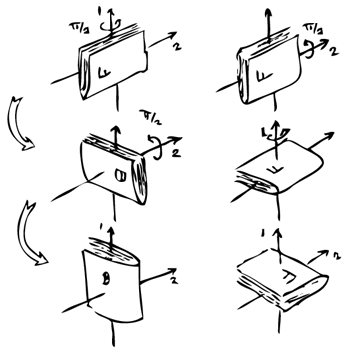

### Symbolic Verification

In [ ]:
theta_1, theta_2, theta_3=symbols('theta_1 theta_2 theta_3');
R1_theta1=Matrix([[1,0,0],[0,cos(theta_1),-sin(theta_1)],[0,sin(theta_1),cos(theta_1)]])
R2_theta2=Matrix([[cos(theta_2),0,sin(theta_2)],[0,1,0],[-sin(theta_2),0,cos(theta_2)]])
R3_theta3=Matrix([[cos(theta_3),-sin(theta_3),0],[sin(theta_3),cos(theta_3),0],[0,0,1]])

**Composition of Rotations:** Finding the rotation matrix that relates a frame $\mathbf{b}$ to a frame $\mathbf{e}$ that is first a counter clockwise rotation around the first axis by an angle $\theta_1$ and then a counter clockwise rotation around the third axis by an angle $\theta_3$.

The first rotation gives $\mathbf{c}=\mathbf{e}R_1(\theta_1)$ and the second rotation gives $\mathbf{b}=\mathbf{c}\,R_3(\theta_3)$. Then $\mathbf{b}=\mathbf{c}\,R_3(\theta_3)=\mathbf{e}\,\underbrace{R_1(\theta_1)R_3(\theta_3)}_{R_a}$

In [ ]:
Ra=simplify(R1_theta1 @ R3_theta3)
Ra

Lets find the reverse sequence of rotations: That is first rotate about the third axis and then about the first axis.

The first rotation gives $\mathbf{d}=\mathbf{e}R_3(\theta_3)$ and the second rotation gives $\mathbf{b}=\mathbf{d}\,R_1(\theta_1)$. Then
\begin{align}
\mathbf{b}=\mathbf{d}\,R_1(\theta_3)=\mathbf{e}\,\underbrace{R_3(\theta_3)R_1(\theta_1)}_{R_b}
\end{align}



In [ ]:
Rb=simplify(R3_theta3 @ R1_theta1)
Rb

Notice that $\underbrace{R_1(\theta_1) R_3(\theta_3)}_{R_a}\neq \underbrace{R_3(\theta_3)R_1(\theta_1)}_{R_b}$

**Thus in general rotations do not commute**

### Numerical Verification

In [ ]:
theta1=np.pi/3; theta2=np.pi/3; theta3=np.pi/3;
O=[0,0,0]; OP=[1,1,1]; OQ=[1,-1,2];
R1theta1=np.array([[1,0,0],[0,np.cos(theta1),-np.sin(theta1)],[0,np.sin(theta1),np.cos(theta1)]])
R2theta2=np.array([[np.cos(theta2),0,np.sin(theta2)],[0,1,0],[-np.sin(theta2),0,np.cos(theta2)]])
R3theta3=np.array([[np.cos(theta3),-np.sin(theta3),0],[np.sin(theta3),np.cos(theta3),0],[0,0,1]])

In [ ]:
Ra=R1theta1 @ R3theta3; Rb=R3theta3 @ R1theta1;

In [ ]:
#Initiating a figure with a e-frame
fig=go.Figure();
O=[0,0,0];
fig=mr.add_orth_norm_frame(fig,O,np.array([[1,0,0],[0,1,0],[0,0,1]]),[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
#Adding a frame rotated by Ra
fig=mr.add_orth_norm_frame(fig,O,Ra,[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'red')
#Adding a frame rotated by Rb
fig=mr.add_orth_norm_frame(fig,O,Rb,[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'green')
fig.show()

## Euler's Theorem

Since $det (R)=1$ one can  show that the eignevalues of any $R\in SO(3)$ are of the form $\{1,e^{i\theta},e^{-i\theta}\}$. Thus it follows tht for any $R\in SO(3)$ there exists a $V\in \mathbb{R}^3$ such that $RV=V$. Now since $R$ acts on $\mathbb{R}^3$ by rigid rotations we see that this action leaves all points along  $V$ fixed. Furthermore this also shows that there eixts a transformation $T\in SO(3)$ that transforms both frames $\mathbf{e}$ and $\mathbf{b}$ such that in the transformed frames $R$ takes the form

\begin{align*}
\begin{bmatrix}
1 & 0 & 0\\
0 & \cos{\theta} & -\sin{\theta}\\
0 & \sin{\theta} & \cos{\theta}
\end{bmatrix}.
\end{align*}

This shows that every rotation $R$ can be thought of as a rotation about some axis $n$ by some angle $\theta$. This is depicted in the figure below. This result is known as **Euler's theorem on rotations**.

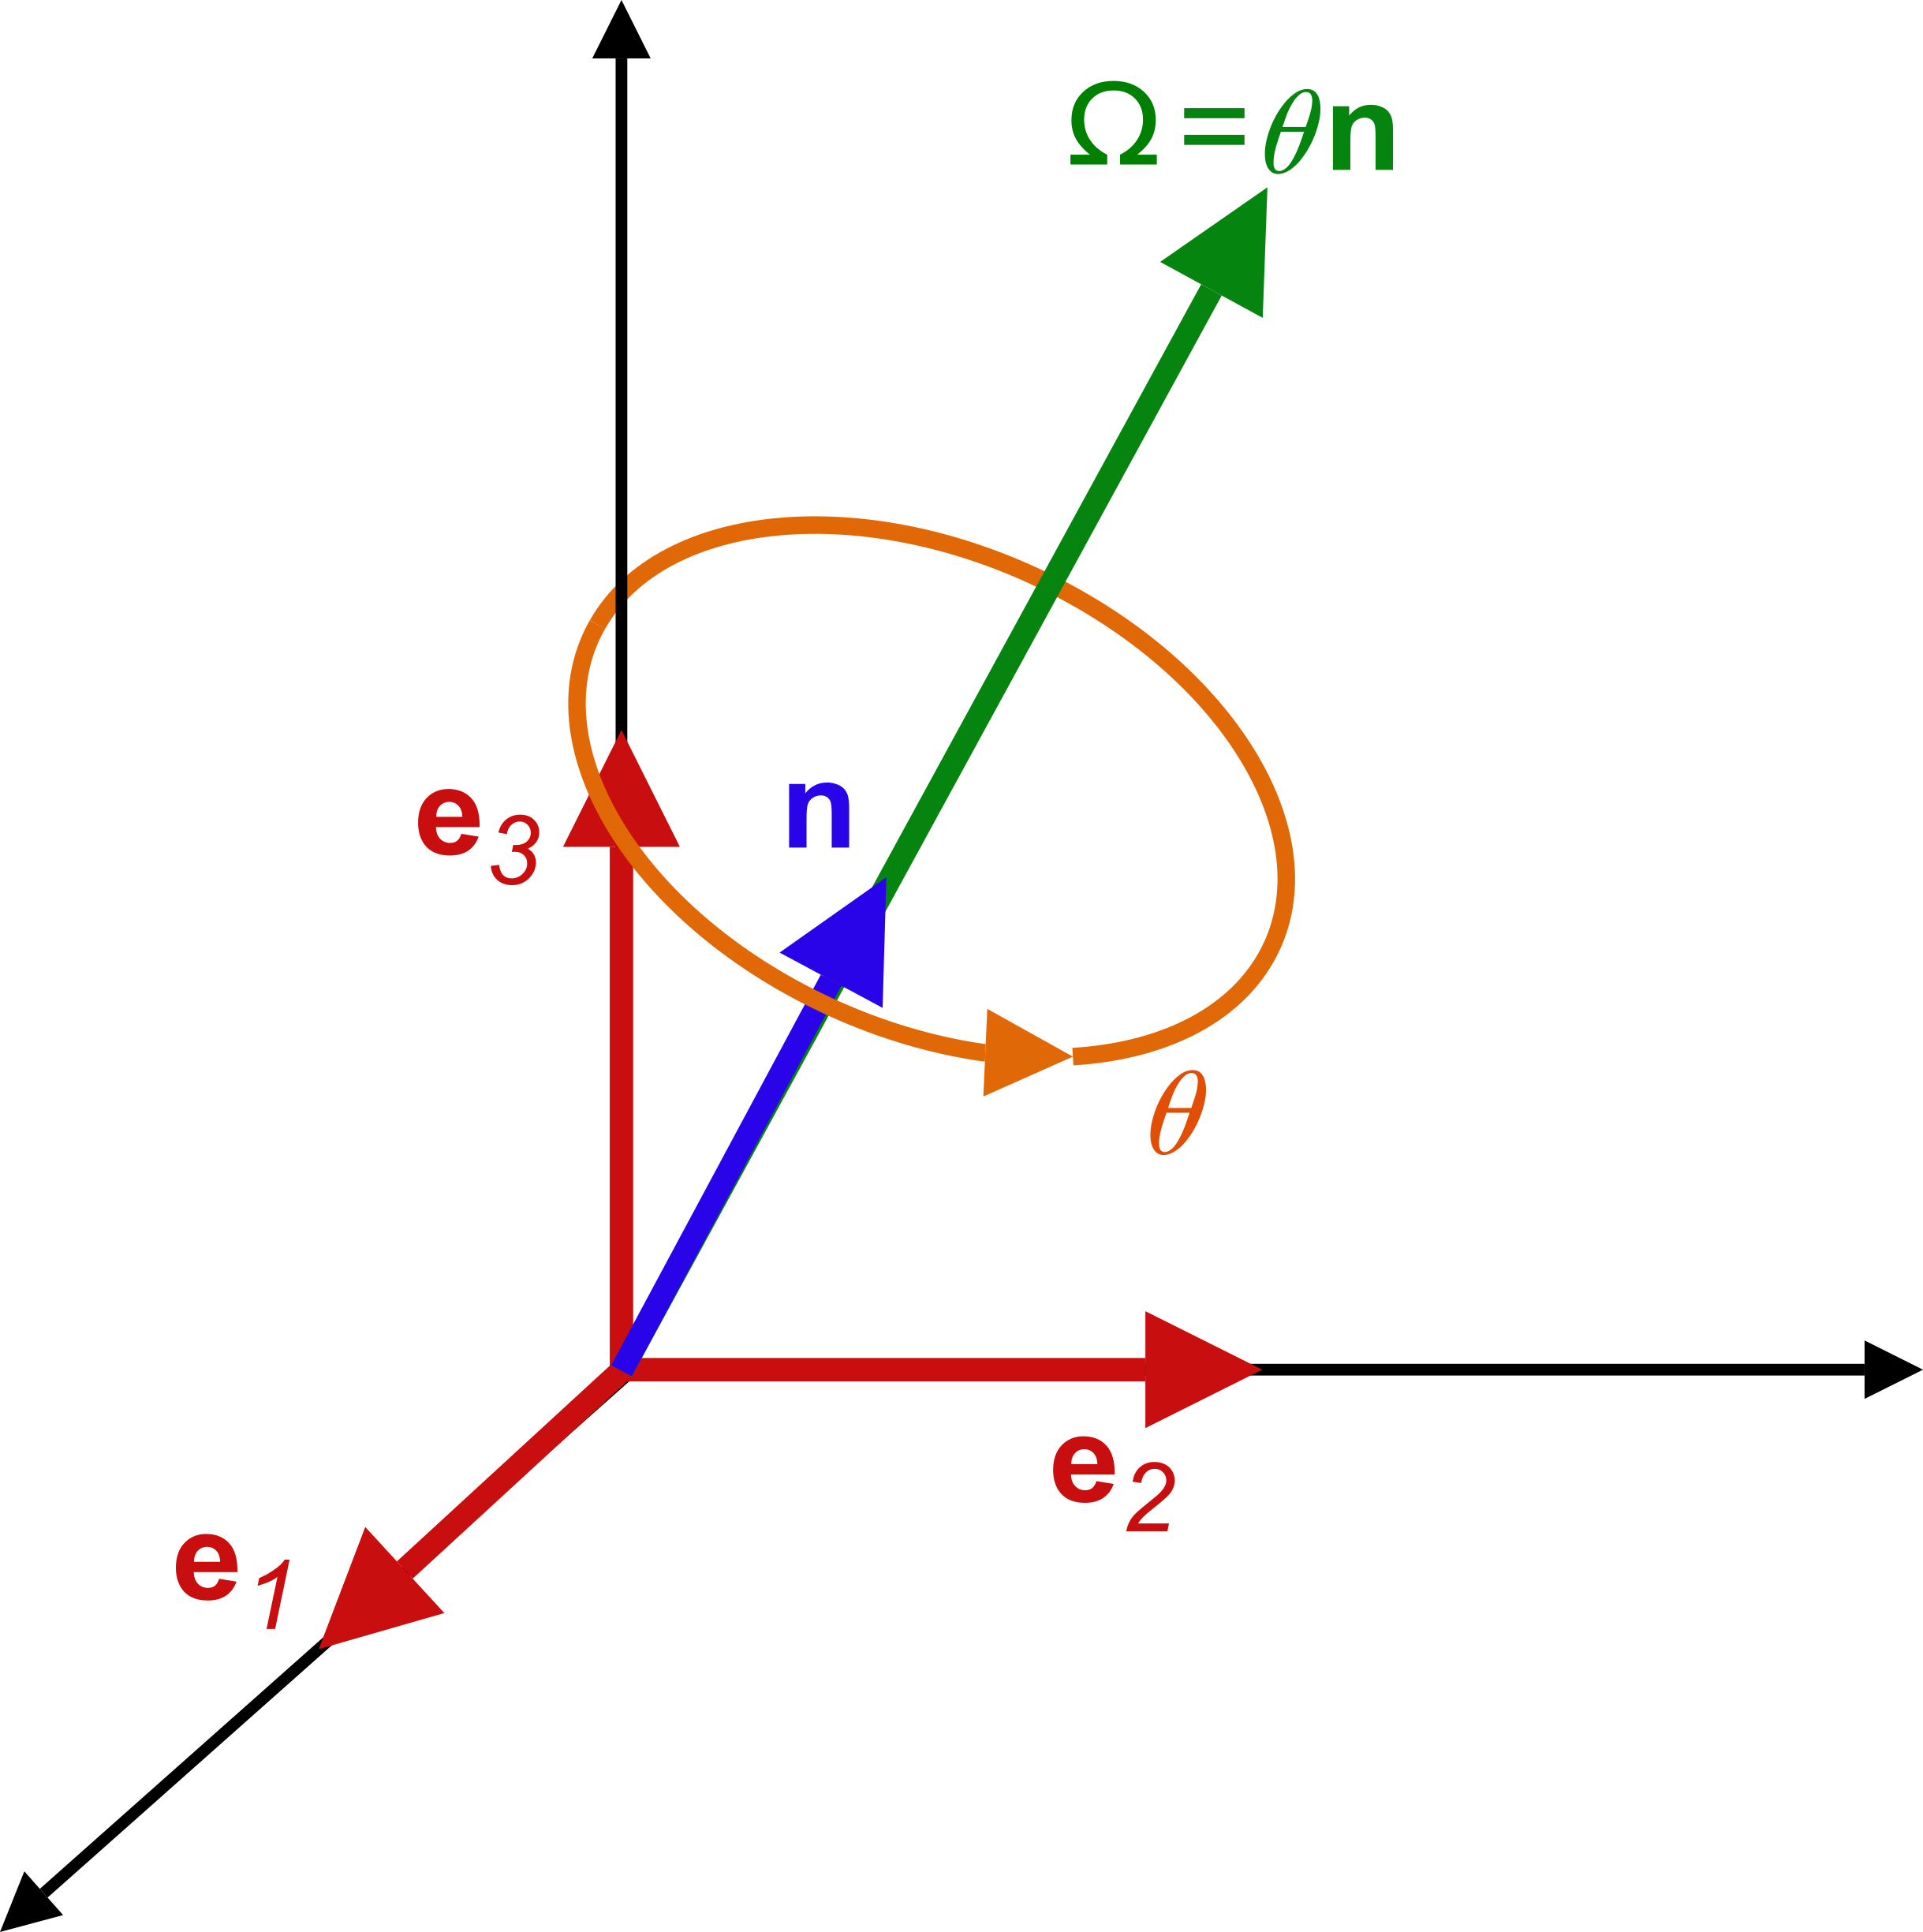

Therefore we see that the space of rotations, $\mathrm{SO}(3)$ can be identified with the solid ball in $\mathbb{R}^3$ with the antipodal points on the boundary identified or by the space of unit tangent vectors on $\mathbb{S}^2$ that is typically denoted by $T_0\mathbb{S}^2$. The figure below provides a pictorial visualization of this space. This confirms our previous conclusion that the dimension of the space $\mathrm{SO}(3)$ is three. On the other hand this also confirms our observation that the space of $SO(3)$ is quite different from $\mathbb{R}^3$. In fact this shows that $SO(3)$ is not isomorphic to $\mathbb{R}^3$. What this implies is that there exists no way of globally parameterizing $SO(3)$ using three parameters.


Since $SO(3)$ is three dimensional any choice of co-ordinates for parameterizing $\mathrm{SO}(3)$ will involve three components. Below we will describe a specific way of assigning coordinates, that are known as Euler angles. But since the preceding discussion shows that $SO(3)$ can not be isomorphic to $\mathbb{R}^3$ there exists no co-ordinate patch that will uniquely specify every point of $\mathrm{SO}(3)$. Thus any choice of Euler angles, or for that matter any three parameter local co-ordinate system on $\mathrm{SO}(3)$ will have points at which they become singular.


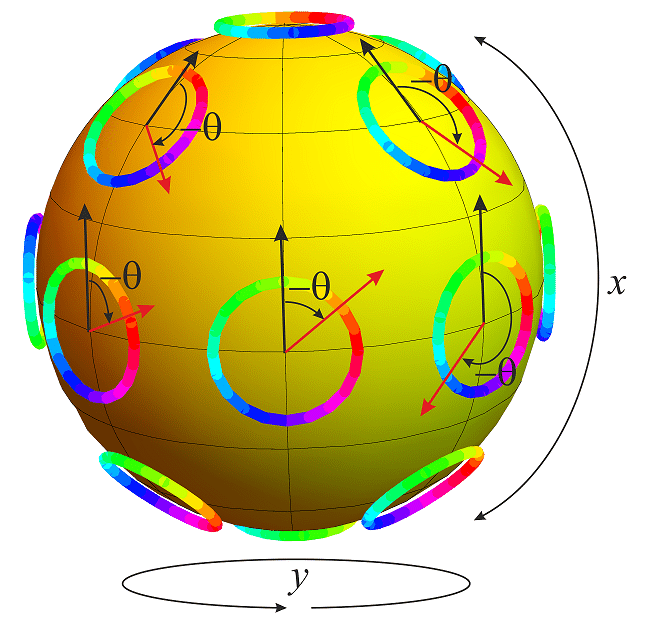

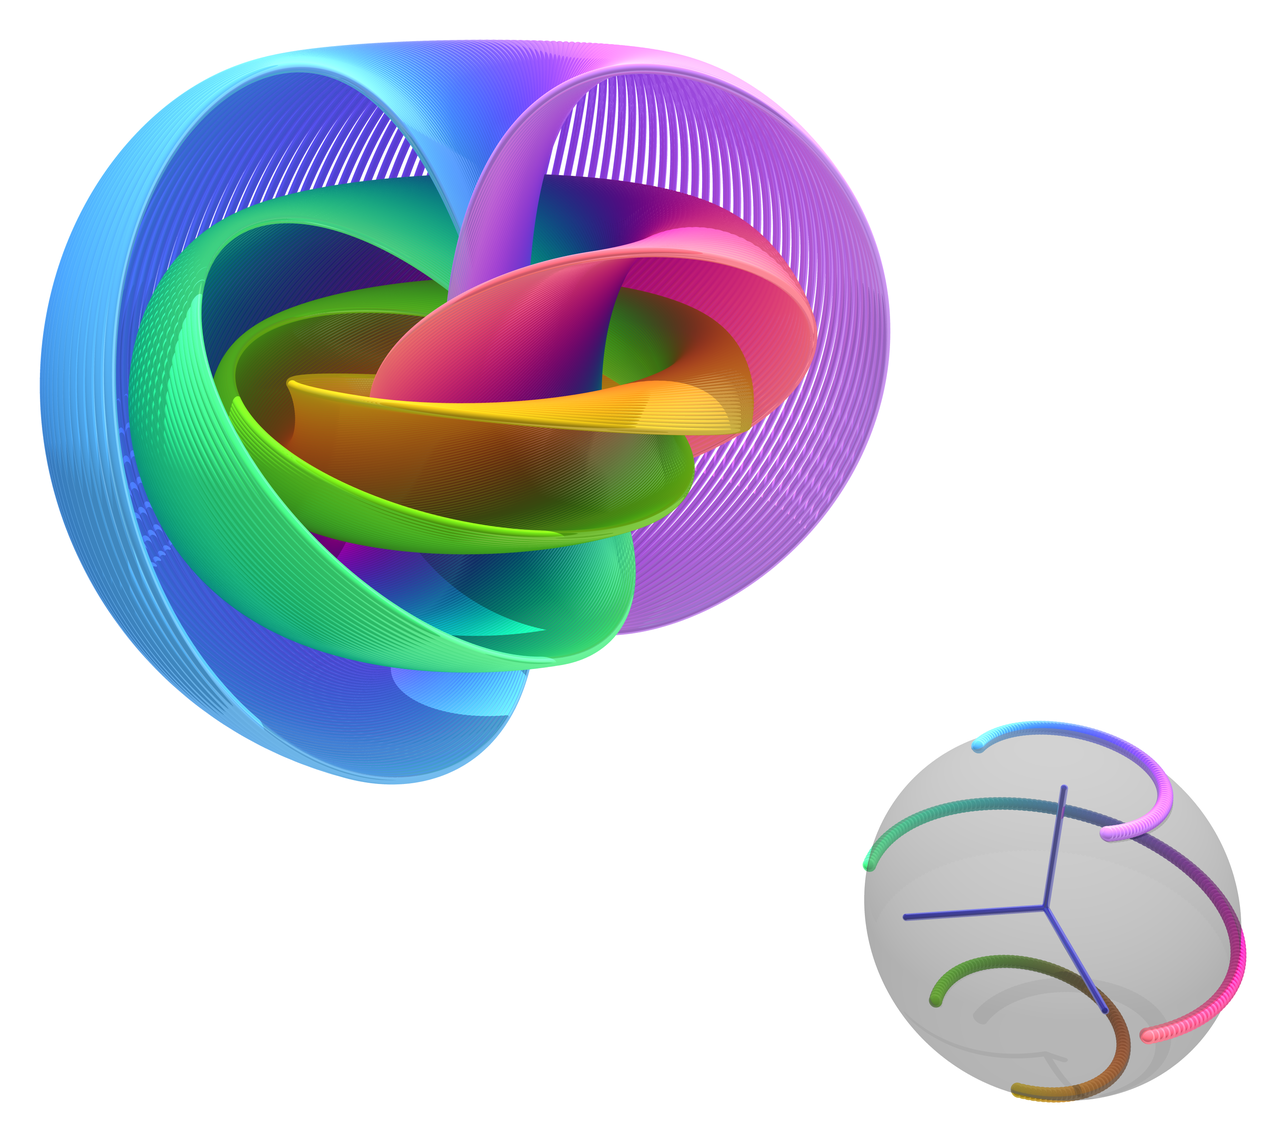

### Numerical Verification

In [ ]:
the1=np.pi/3; the2=np.pi/3; the3=np.pi/3;
O=[0,0,0]; OP=[1,1,1]; OQ=[1,-1,2];
R1the1=np.array([[1,0,0],[0,np.cos(the1),-np.sin(the1)],[0,np.sin(the1),np.cos(the1)]])
R2the2=np.array([[np.cos(the2),0,np.sin(the2)],[0,1,0],[-np.sin(the2),0,np.cos(the2)]])
R3the3=np.array([[np.cos(the3),-np.sin(the3),0],[np.sin(the3),np.cos(the3),0],[0,0,1]])
Ra=R1the1 @ R3the3; Rb=R3the3 @ R1the1;

In [ ]:
Ra

In [ ]:
D, V=linalg.eig(Ra)

In [ ]:
T=np.array([V.real.T[2],V.real.T[0],V.imag.T[0]]).T

In [ ]:
T.T @ Ra @ T

## Euler Angle Parameterization of $SO(3)$

We have seen that a seqeucne of rotations correspond to a serier multiplication of rotation matrices.

The $R\in SO(3)$ given by
\begin{align*}
R&\triangleq R_{i}(\theta_\alpha)R_{j}(\theta_\beta)R_{k}(\theta_\gamma)
\end{align*}
is in $SO(3)$ and corresponds to a rotation first about the $i^{\mathrm{th}}$ axis, then about the $j^{\mathrm{th}}$ axis and then finally about the $k^{\mathrm{th}}$ axis. Thus this process defines a map from $\mathbb{R}^3$ to $SO(3)$ that takes $(\theta_\alpha,\theta_\beta,\theta_\gamma)\in \mathbb{R}^3$ to $R_{ijk}= R_{i}(\theta_\alpha)R_{j}(\theta_\beta)R_{k}(\theta_\gamma)\in SO(3)$

One can show that for any combination of $i,j,k \in \{1,2,3\}$ where not all three $i,j,k$ are the same and no two consequtive indices are the same the resulting map is one-to-one and onto except for a very special set of $(\theta_\alpha,\theta_\beta,\theta_\gamma)$. Thus $(\theta_\alpha,\theta_\beta,\theta_\gamma)$ form a set of local coordinates for $SO(3)$. *Thus we see that $SO(3)$ is a 3-dimensional space. That is one needs three independent quantities to uniquely describe its elements.*

**This is called the $i-j-k$ Euler angle parameterization of $R\in SO(3)$.**


In [ ]:
alpha, beta, gamma=symbols('alpha beta gamma');

In [ ]:
#Try out various combinations Ri_alpha @ Rj_beta @ Rk_gamma
simplify(R1_theta1.replace(theta_1,alpha) @ R2_theta2.replace(theta_2,beta) @ R3_theta3.replace(theta_3,gamma))

##### 3-1-3 Euler Angle Parameterization of $R\in SO(3)$

In [ ]:
simplify(R3_theta3.replace(theta_3,theta_1) @ R1_theta1.replace(theta_1,theta_2) @ R3_theta3)

This parameterization is shown in the figure below.
It is easy to see that  when $\theta_2=0$ or $\theta_2=\pi$ then $R=R_3(\theta_1+\theta_3)$ and hence that there exists no unique $\theta_1,\theta_3$ that describe the orientation of the resulting two frames $\mathbf{e}$ and $\mathbf{b}$. This situation is called \emph{gimbal lock} in the stellite and robotics communities.
This turns out to be a common problem for any type of Euler angles being used. Thus in particular we find that the Euler angles only provide a local isomorphism between $\mathbb{R}^3$ and $SO(3)$.

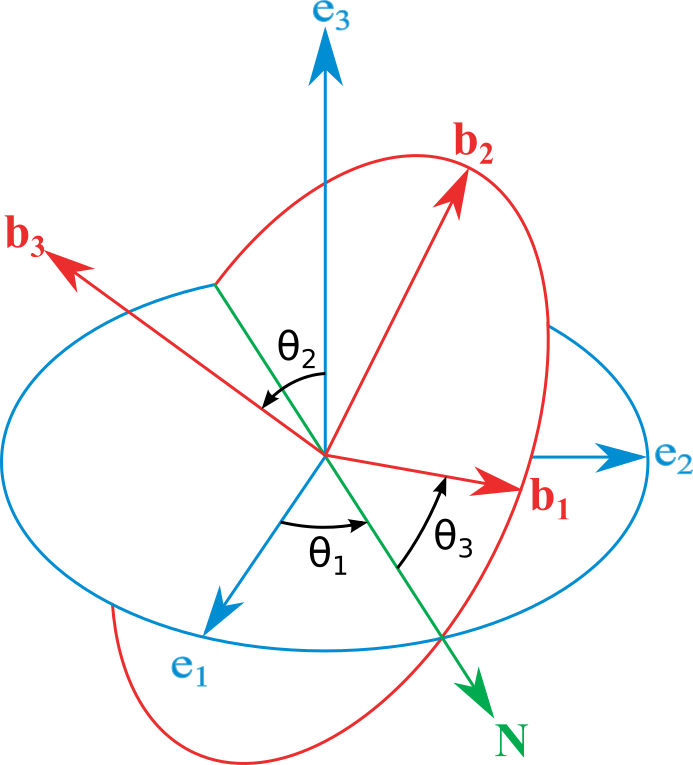

## Unit Quaternion Parameterization of $SO(3)$

Consider the case where an orthonormal frame $\mathbf{b}(t)$ is moving with respect to another orthonormal frame $\mathbf{e}$ such that the origins of the two frames remain coincident. Let $\mathbf{b}(t)=\mathbf{e}\,R(t)$ and $\widehat{\Omega}=R^T\dot{R}$. Consider $\Omega$ and $\omega=R\Omega$ (note that $\widehat{\omega}=\dot{R}R^T$).

In the section titled 'Angular Velocity' we have seen that $\omega$ represents the intantaneous axis of rotation of $\mathbf{b}(t)$ with respect to $\mathbf{e}$ as seen from $\mathbf{e}$. Furthermroe we also saw that the rate of this instantaneous rotation is eaqual to $||\omega||=||\Omega||$. Thus we saw that $\omega$ is the angular velocity of $\mathbf{b}(t)$ with respect to $\mathbf{e}$ as seen from $\mathbf{e}$ and that $\Omega$ is its representation with respect to $\mathbf{b}(t)$.

In this section we will take a closer look at the two equivalent matrix differential equations:
\begin{align*}
\dot{R}&=R\widehat{\Omega}\\
\dot{R}&=\widehat{\omega}R
\end{align*}
that correspond to $\widehat{\Omega}=R^T\dot{R}$ and $\widehat{\omega}=\dot{R}R^T$ respectively.

Let us concentrate on the solutions of  $\dot{R}=R\widehat{\Omega}$ and everything we will observe for this will have a corresponding simialr interpretation for $\dot{R}=\widehat{\omega}R$.

We note that if one considers element by element then $\dot{R}=R\widehat{\Omega}$ represents nine time varying ODEs. However since $R^TR=I_{3\times 3}$ defines six constraints we see that all the nine differential equations defined by $\dot{R}=R\widehat{\Omega}$ are not independent.


Since $R(t)$ corresponds to an instantaneous rotation about $\Omega$ (as seen in the $\mathbf{b}$ frame) at an instantaneous rate that is equal to $||\Omega||$. Thus if $\Omega$ is a constant then the solution to the following initial value problem
\begin{align*}
\dot{R}&=R\widehat{\Omega},\:\:\:\:\:\:\: R(0)=I_{3\times 3},
\end{align*}
is a pure rotation about the axis $\Omega$ at a constant angular rate of $\Omega$.
This says that if we define $\theta(t)\triangleq t||\Omega||$ then since $\Omega$ does not depend on $t$ we see that the solution, $R(t)$, to the initial value problem  is a rotation about the axis $\Omega$ by an angle equal to $\theta=t||\Omega||$.
It is easy to verify by direct computation that this solution is explicitly and uniquely given by
\begin{align*}
{R}(t)&=\exp{(t\widehat{\Omega})},
\end{align*}
where $\exp{(A)}$ denotes the matrix exponential of the matrix $A$.

Similarly one can also show that ${R}(t)=\exp{(t\widehat{\omega})}$ is the unique solution of $\dot{R}=\widehat{\omega}R$ with $R(0)=I_{3\times 3}$ and $\omega$ a constant.


Setting $t=1$ in ${R}(t)=\exp{(t\widehat{\Omega})}$ we see that $\exp{(\widehat{\Omega})}\in \mathrm{SO}(3)$ for any $\widehat{\Omega}\in \mathrm{so}(3)$ and that it corresponds to a rotation about the axis $\Omega$ by an angle $\theta=||\Omega||$.
This process defines a map $\exp : \mathrm{so}(3) \to \mathrm{SO}(3)$.
By uniqueness of solutions of differential equations we find that the so defined map
$\exp : \mathrm{so}(3) \to \mathrm{SO}(3)$ is locally one-to-one. Showing this is beyond the scope of this lecture notes as it requires advanced mathematical notions involving group theory.

Conversely in the previous section we have seen that teh Euler's theorem says that every $R \in \mathrm{SO}(3)$ can be thought of as a rotation about some axis $\Omega$ and hence that for any given $R$ there exists some $\widehat{\Omega}\in \mathrm{so}(3)$ such that $R=\exp{(\widehat{\Omega})}$. Thus we see that the map $\exp : \mathrm{so}(3) \to \mathrm{SO}(3)$ is onto as well.


**In summary what we have shown is that for every $\Omega$ there is a unique corresponding $R$ given by the matrix exponential $\exp{(\widehat{\Omega})}$ and that for every $R$ there also exists some $\Omega$ such that $R=\exp{(\widehat{\Omega})}$.**



Let us now proceed to find an explicit expression for $\exp{(\widehat{\Omega})}$. Previously we have shown that
\begin{align*}
\widehat{\Omega}^2=(\Omega\Omega^T-||\Omega||^2I).
\end{align*}
From this it follows that
\begin{align*}
\widehat{\Omega}^3=-||\Omega||^2\widehat{\Omega},\:\:\:\:\:\:\:\widehat{\Omega}^4=-||\Omega||^2\widehat{\Omega}^2,\:\:\:\:\:\:\:\widehat{\Omega}^5=||\Omega||^4\widehat{\Omega},\:\:\:\:\:\:\:\cdots
\end{align*}
and therefore we can show that
\begin{align*}
\exp{\left({\widehat{\Omega}}\right)}&=I+\frac{\sin{||\Omega||}}{||\Omega||}\widehat{\Omega}+\frac{1}{2}\left(\frac{\sin{\frac{||\Omega||}{2}}}{{\frac{||\Omega||}{2}}}\right)^2\widehat{\Omega}^2.
\end{align*}
This is famously known as the *Rodrigues formula*.

**We stress again that this corresponds to a rotation about the axis $\Omega$ by an angle $\theta=||\Omega||$**. Thus letting $n=\Omega/||\Omega||$ be the unit length direction along $\Omega$ we can write the above equation also as

\begin{align*}
R=\exp{\left(\theta\,{\widehat{n}}\right)}&=I+\sin{\theta}\,\widehat{n}+(1-\cos{\theta})\,\widehat{n}^2.
\end{align*}

Since we have seen that every $R \in \mathrm{SO}(3)$ can be written as $R=\exp{(\widehat{\Omega})}$ for some $\widehat{\Omega}\in \mathrm{so}(3)$ we can also conclude that every $R \in \mathrm{SO}(3)$ can be written down using the above expression for some angle $\theta$ and unit direction $n$.
Observe that specifically if $E_1=[1\:\:\:0\:\:\:0]^T,E_2=[0\:\:\:1\:\:\:0]^T,E_3=[0\:\:\:0\:\:\:1]^T$ then the Rodrigues formula gives that
$\exp{(\theta_i\widehat{E}_i)}=R_i(\theta_i)$ corresponds to a rotation about the axis $E_i$ by an angle equal to $\theta_i$.

Let $w=\sin{\left(\frac{\theta}{2}\right)}n$ and
$q_0=\cos{\left(\frac{\theta}{2}\right)}$.  Observe that since $q_0^2+||w||^2=1$ the ordered quadruple of numbers $q=(q_0,w)$ represents a point on the surface of the unit sphere, $\mathbb{S}^3=\{q\in \mathbb{R}^4\:\:\: |\:\:\: ||q||=1\}$, in $\mathbb{R}^4$.  Then re-arranging the above expression we have that every $R\in \mathrm{SO}(3)$ can be written down as

\begin{align*}
R&=I+2q_0\widehat{w}+2\widehat{w}^2.
\end{align*}
for some $(q_0,w)\in\mathbb{S}^3$.

Conversely we also see that for every $q=(q_0,w)\in \mathbb{S}^3$ there is a unique corresponding $R\in \mathrm{SO}(3)$  that is explicitly given by the above formula. Note that, since $-q=(-q_0,-w)\in \mathbb{S}^3$ also gives the same $R$ that is given by $q=(q_0,w)\in \mathbb{S}^3$, this correspondence is two-to-one. In summary, we have the following:

The group of rotations $\mathrm{SO}(3)$ is isomorphic to $\mathbb{S}^3/\{1,-1\}$ where the isomorphism is explicitly given by the above expression
$R=I+2q_0\widehat{w}+2\widehat{w}^2$.
Here $R$ corresponds to a rotation about $w$ by an angle equal to $\theta =2\cos^{-1}({q_0})$.
Using algebraic manipulations it can also be shown that, in terms of $(q_0,w)\in \mathbb{S}^3$, the differential equation $\dot{R}=R\widehat{\Omega}$ becomes

\begin{align*}
\left[\begin{array}{c}\dot{q}_0 \\ \dot{w}
\end{array}\right] &=
\frac{1}{2}\left[\begin{array}{c}-\Omega \cdot w \\ q_0\Omega-\Omega\times {w}
\end{array}\right].
\end{align*}


The unit sphere in $\mathbb{R}^4$, denoted by $\mathbb{S}^3=\{q\in \mathbb{R}^4 \:\:\:|
\:\:\: ||q||=1\}$ is also known as the space of *unit quaternions*. We conclude this section by noting that the unit quaternion $q=(q_0,w)$ that correspond to a given rotation matrix $R$ can be found using the following two expressions:
\begin{align*}
\mathrm{trace}(R)&=-1+4q_0^2=2\cos \theta +1,\\
R-R^T&=4q_0 \widehat{w}=4\cos{\left(\frac{\theta}{2}\right)} \widehat{w}.
\end{align*}
The first expression determines $q_0=\cos{\frac{\theta}{2}}$ and the second expression determines $w$.

### Numerical Verifications

In [ ]:
q=mr.q_from_axis_angles(np.pi/2,[1,1,0]/np.sqrt(2))
print(q)

In [ ]:
fig=go.Figure()
fig=mr.add_orth_norm_frame(fig,[0,0,0],np.eye(3),[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
fig=mr.add_orth_norm_frame(fig,[0,0,0],R,[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'red')
fig.show()

## Integration of Rotational Kinematics

We have seen that the solution to the initial value problem $\dot{R}=R\widehat{\Omega}$, $R(0)=R_0$ is explicitly given by $R(t)=R_0\exp{(t\widehat{\Omega})}$ if ${\Omega}$ is a constant.

If $\Omega (t)$ is time varying then, in general, there exists no such explicit solution and one needs to resort to numerical methods of finding an approximate solution.

The above explict solution gives us one suach natural scheme that is based on the Euler's method of approximation.

Consider a discrete sequence of time points $\{t_0,t_1,\cdots, t_k,t_{k+1},\cdots,t_N\}$ at which we need to aproximate the solution of our initial value problem. Let $R_k\triangleq R(t_k)$ and $\Omega_k\triangleq \Omega(t_k)$ and $\Delta t_k\triangleq (t_{k+1}-t_k)$. The assuming that $\Omega(t)\approx \Omega(t_k)$  during the time interval $[t_k,t_{k+1}]$ we see that

\begin{align*}
R_{k+1}&\approx R_k\exp{(\Delta t_k\Omega_k)}
\end{align*}
with $R_0=R(0)$. The accuracy of this approximation increases as $\Delta t_k$ beocmes small.

Note that we can explicitly compute $\exp{(\Delta t_k\Omega_k)}$ using the Euler-Rodrigues formula
\begin{align*}
\exp{(\Delta t_k\Omega_k)}=I+2{q_0}_k\widehat{w}_k+2\widehat{w}^2_k
\end{align*}
where
\begin{align*}
\theta_k&=\Delta t_k||\Omega_k||,\\
{q_0}_k&=\cos{\left(\frac{\theta_k}{2}\right)},\\
w_k &= \sin{\left(\frac{\theta_k}{2}\right)}\frac{\Omega_k}{||\Omega_k||}.
\end{align*}

#### Numerical Example

Consider $\dot{R}=R\widehat{\Omega}$ where $\Omega(t)=[\sin{t},\cos{t},0]$. We are intersted in finding the rotation matrix $R$ when $t=2\pi$ with $R(0)=I_{3\times 3}$.

Consder the equally spaced sequence of time points $[0,t_1,t_2,\cdots,2\pi]$ where $\Delta t_k=2\pi/10$.

In [ ]:
R0=np.eye(3);
listR=[R0];
t=np.linspace(0,2*np.pi,11);
for k in t:
  Omega_k=[np.sin(k),np.cos(k),0];
  theta_k=(2*np.pi/11)*linalg.norm(Omega_k);
  n_k=Omega_k/linalg.norm(Omega_k);
  q_k=mr.q_from_axis_angles(theta_k,n_k)
  R0=R0 @ mr.r_from_quaternions(q_k);
  listR+=[R0]

In [ ]:
n=11
fig=go.Figure()
fig=mr.add_orth_norm_frame(fig,[0,0,0],np.eye(3),[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'blue')
fig=mr.add_orth_norm_frame(fig,[0,0,0],listR[n],[[-1.5,1.5],[-1.5,1.5],[-1.5,1.5]],'red')
fig.show()

In [ ]:
XX0=mr.cube_vertices({'l':2,'w':1,'h':0.5,'xp':0,'yp':0,'zp':0})
XX=[];
for R in listR:
  XX+=[[R @ XX0]]
fig=mr.animated_cube_flat_shading(XX,'Rotation')

# Rigid Body Motion

In this section we consider the motion of a collection of non co-linear interacting particles $P_1,P_2,\cdots,P_n$ where the interactions ensure that the relative distance between any two particles remain the same at all time. Such a set of particles is called a *rigid body*.

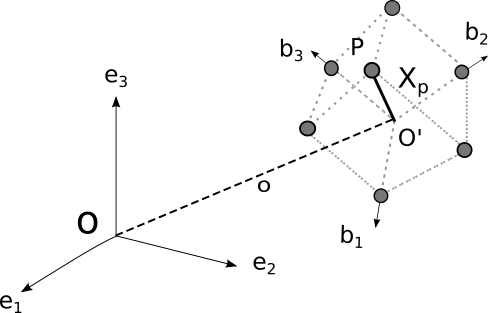

## Rigid Body Kinematics

Let $\mathbf{e}$ be an inertial frame with origin $O$ and and let $\mathbf{b}(t)$ be an ortho-normal frame with origin $O'$ in which all the particles $P_i$ appear to be fixed as illustrated for example in the figure above. We will call $\mathbf{b}(t)$ the body frame. Let $OO'=\mathbf{e}o(t)$. The position of the $i^\mathrm{th}$ point $P_i$ at a time $t$, is given by $x_i(t)$ with respect to the frame $\mathbf{e}$ and by $X_i$
with respect to the body frame $\mathbf{b}(t)$. Observe that since all points on the body appear to be fixed with respect to the body frame $\mathbf{b}(t)$, the representation $X_i$ is independent of time. Therefore specifying $\mathbf{b}(t)$ amounts to specifying the configuration
of the rigid body. Since $\mathbf{b}(t)$ is uniquely related to the inertial frame $\mathbf{e}$ by the rotational matrix $R(t)$, where $\mathbf{b}(t)=\mathbf{e}\,R(t)$, and the position of its origin $o(t)$, the specification of $(o(t),R(t))$ amounts to the unique specification of the configuration of the rigid body with respect to the inertial frame $\mathbf{e}$. Similarly any $(o,R)$ where $o\in \mathbb{R}^3$ and $R\in \mathrm{SO}(3)$ defines a unique configuration of the rigid body. Thus the configuration space of rigid body motion is $ \mathbb{R}^3\times \mathrm{SO}(3)$ where we have denoted the space of $3\times 3$ special orthogonal matrices by $\mathrm{SO}(3)$.

The pair $(o,R)\in \mathbb{R}^3 \times \mathrm{SO}(3)$ can also be identified with a unique $4\times 4$ matrix
\begin{align*}
E&=\begin{bmatrix}
R & o \\ 0 & 1\end{bmatrix}.
\end{align*}
The spcace of all such $4\times 4$ matrices are referred to as the space of special euclidean group of matrices that is denote by $SE(3)$.

Recall that the quantity $\Omega$ where $\widehat{\Omega}=R^T\dot{R}$ corresponds to an instantaneous rotation of the body about the axis $\Omega$ as expressed in the body frame $\mathbf{b}$ by an
amount equal to the magnitude $||\Omega||$ and thus that $\Omega$ can be defined to be the **body angular velocity** of the rigid body. The $\mathbf{e}$ frame version of this quantity $\omega \triangleq R\Omega$ is defined to be the **spatial angular velocity** of the rigid body.

The equation
\begin{align*}
\dot{R}&=R\widehat{\Omega}
\end{align*}
that defines angular velocity is usually referred to as the **rigidbody kinematic** equations.

Since $\widehat{\Omega}=\widehat{R^T\omega}=R^T\widehat{\omega}R$ this can also be equivalently written down as
\begin{align*}
\dot{R}&=\widehat{\omega}R.
\end{align*}


## Total Linear Momentum of a Rigid Body

Recall that the total linear momentum of a set of interacting particles can be written down as
\begin{align*}
p&=\sum_{i}p_i=\sum_{i}m_i\left(\dot{o}+R(\widehat{\Omega}{X}_i+\dot{X}_i)\right).
\end{align*}
In the case of a rigid body $\dot{X}_i=0_{3\times 1}$ and hence
\begin{align*}
p&=M(\dot{o}+R\widehat{\Omega}\bar{X})=M(\dot{o}+\widehat{\omega}R\bar{X})=M\dot{\bar{x}},
\end{align*}
where $M=\sum_{i}m_i$, $\bar{X}=\sum_{i}m_i X_i/\sum_{i}m_i$ is the center of mass of the rigid body represented with repect to frame $\mathbf{b}$ fixed to the body (body frame).

Thus we also see that that the translational kinematics are given by
\begin{align*}
\dot{o}&=\frac{1}{M}p-\omega \times R\bar{X}.
\end{align*}

## Total Angular Momentum of a Rigid Body

Also recall that angular momentum of a point particle of mass $m_i$ about the origin $O'$ of a $\mathbf{b}$ frame takes the form
\begin{align*}
\pi_i&= R\left(\mathbb{I}_i\Omega+m_iX_i\times( R^T\dot{o}+ \dot{X}_i)\right),
\end{align*}
in the $\mathbf{e}$ frame and
\begin{align*}
\Pi_i= \left(\mathbb{I}_i\Omega+m_iX_i\times(\dot{X}_i+ R^T\dot{o})\right),
\end{align*}
in the $\mathbf{b}$ frame where the quantity
\begin{align*}
\mathbb{I}_i &\triangleq -m_i\widehat{X}_i^2=m_i\left(||X_i||^2I_{3\times 3} - X_iX_i^T\right),
\end{align*}
is defined as the *moment of inertia* of the particle $P_i$ about the point $O'$ in the frame $\mathbf{b}$.

Since in a rigid body the particles are fixed with respect to the frame $\mathbf{b}$ we have that $\dot{X}_i=0_{3\times 1}$ and then we have
\begin{align*}
\pi_i&= R\underbrace{\left(\mathbb{I}_i\Omega+m_iX_i\times R^T\dot{o}\right)}_{\Pi_i},
\end{align*}
Summing them over all the particles we have that the total angulare momentum about $O'$ is given by
\begin{align*}
\pi&=\sum_{i}\pi_i= R\underbrace{\left(\mathbb{I}\Omega+M\bar{X}\times R^T\dot{o}\right)}_{\Pi},
\end{align*}
where $M=\sum_{i}m_i$, $\bar{X}=\sum_{i}m_i X_i/\sum_{i}m_i$ is the representation of the center of mass of the rigid body in the $\mathbf{b}$ frame, and
\begin{align*}
\mathbb{I} &\triangleq \sum_{i}-m_i\widehat{X}_i^2=\sum_{i}m_i\left(||X_i||^2I_{3\times 3} - X_iX_i^T\right),
\end{align*}
is defined as the *moment of inertia* of the body about the point $O'$ with respect to the frame $\mathbf{b}$. It is easy to see that this is a symmetric positive definite matrix if all the ponts are not co-linear.

Since $p=M\dot{\bar{x}}=M(\dot{o}+R(\Omega\times \bar{X}))$ we see that $M\dot{o}\times \dot{\bar{x}}=\dot{o}\times p=-R(\Omega \times \bar{X})\times p$ we also see that
\begin{align*}
\pi&=R\left(\mathbb{I}\Omega +M\bar{X}\times R^T\left(\frac{1}{M}p-R(\Omega\times \bar{X})\right)\right)\\
&=R\left(\mathbb{I}\Omega +\bar{X}\times R^Tp+M\bar{X}\times \bar{X} \times\Omega\right)\\
&=R\left((\mathbb{I}+M\widehat{\bar{X}}^2)\Omega +\bar{X}\times R^Tp)\right)\\
&=R\left(\mathbb{I}_c\Omega +\bar{X}\times R^Tp)\right).
\end{align*}
where
\begin{align*}
\mathbb{I}_c&\triangleq \mathbb{I}+M\widehat{\bar{X}}^2
\end{align*}
is the inertia tensor of the body with respect to a frame that is parallel to $\mathbf{b}$ and origin coinciding with the center of mass of the object, $O_c$.



*When written as
\begin{align*}
\mathbb{I}&=\mathbb{I}_c-M\widehat{\bar{X}}^2
\end{align*}
this turns out to be the parallel axis theorem.*

Also note that since $\Omega =R^T\omega$ we have
\begin{align*}
\pi&=R\left(\mathbb{I}_c\Omega +\bar{X}\times R^Tp)\right),\\
&=(R\mathbb{I}_cR^T)\omega +R\bar{X}\times p,\\
&=\mathbb{I}_c^R\omega +R\bar{X}\times p.
\end{align*}
where
\begin{align*}
\mathbb{I}_c^R\triangleq R\mathbb{I}_cR^T=R(\mathbb{I}+M\widehat{\bar{X}}^2)R^T,
\end{align*}
is defined to be the *locked inertia tensor* in the body. It can be shown that $\mathbb{I}_c^R$ is the moment of inertia tensor of the body with respect to a frame that is parallel to $\mathbf{e}$ and  orign coinciding with the center of mass $O_c$.

In summary consider a set of particles which are rigid with respect to each other and $\mathbf{b}$ be a body fixed frame with origin coinciding with the point $O'$ around which the moments are defined.

Then the angular momentum of the particles about a point $O'$ can be written down in the following equivalent forms:

\begin{align*}
\pi&=R\left(\mathbb{I}\Omega+M\bar{X}\times R^T\dot{o}\right)
\end{align*}
where $\mathbb{I}$ is the moment of inertia tensor with respect to the frame $\mathbf{b}$ with origin $O'$,
\begin{align*}
\pi&=R\left(\mathbb{I}_c\Omega+\bar{X}\times R^Tp\right)
\end{align*}
where $\mathbb{I}_c$ is the moment of inertia tensor with respect to a frame that is parallel to $\mathbf{b}$ and  origin coinciding with the center of mass $O_c$, and
\begin{align*}
\pi&=\mathbb{I}_c^R\omega+R\bar{X}\times p
\end{align*}
where $\mathbb{I}_c^R$ is the moment of inertia tensor with respect to a frame that is parallel to $\mathbf{e}$ and  origin coinciding with the center of mass $O_c$.

In the case where the moments are taken about the center of mass of the body we have that
\begin{align*}
\pi&=R\mathbb{I}_c\Omega=\mathbb{I}_c^R\omega.
\end{align*}

## Derivation of the equations governing the  motion of a rigid body

Rigid or not we have shown in the section on motion of a set of interacting particles that:
\begin{align*}
\dot{p}&=M\ddot{\bar{x}}=f^e,\\
\dot{\pi}&=-M\dot{o}\times \dot{\bar{x}}+\tau_e
\end{align*}
where $M=\sum_{i=1}^nm_i$ is the total mass of the particles, $\bar{x}$ is the representation of the center of mass of the set of particles in the inertial frame $\mathbf{e}$, $p=\sum_{i=1}^np_i$ is the total linear momentum of the system of particles, $f^e=\sum_{i=1}^n f_i^e$ is the total resultant of the external forces acting on the particles, $\pi =\sum_{i=1}^n\pi_i$ is the total angular momentum of the particles about $O'$, $\tau^e=\sum_{i=1}^n(x_i-o)\times f_i^e$ is the resultant force moment of the external interactions acting on the particles about the point $O'$, and $o$ is the representation of the point $O'$ in the frame $\mathbf{e}$.

**Notice the extreme simplicity of the form of these governing equations however complicated the system of particles is.**

In the case of a rigid body one can fix a frame $\mathbf{b}$ to the body. Let $o(t)$ be the representation of the origin $O'$ of the frame $\mathbf{b}$ with respect to $\mathbf{e}$ and let $\mathbf{b}=\mathbf{e}R(t)$. Also let $\widehat{\Omega}=R^T\dot{R}$ and $\omega =R\Omega$.

Then the specification of $(o(t), R(t))$ over time completely describes the motion of the set of particles. Thus describing the motion of the set of particles amounts to the specification of $(o(t), R(t))$ over time.


### The $\mathbf{e}$-frame (spatial) description of rotating and translating rigid body equations

Let $\bar{x}'\triangleq (\bar{x}-o)=R\bar{X}$. Differentiating this expression gives
\begin{align*}
\dot{\bar{x}}'&=R(\Omega \times \bar{X})=\omega \times \bar{x}'.
\end{align*}
Then the fact that $p=M\dot{\bar{x}}$ gives
\begin{align*}
\dot{\pi}&=-M\dot{o}\times \dot{\bar{x}}+\tau_e=M\dot{\bar{x}}'\times \dot{\bar{x}}+\tau_e=\omega \times \bar{x}'\times p+\tau_e
\end{align*}

We also saw that the rigid body kinematic equations are given by $M\dot{o}=p-M\omega \times \bar{x}'$ and $\dot{R}=\widehat{\omega}R$.



Putting these together we arrive at the fully determined set of coupled ODEs
\begin{align*}
\dot{o}&=\frac{1}{M}p-\omega \times \bar{x}',\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\omega \times \bar{x}'\times p+\tau_e
\end{align*}
where
\begin{align*}
\bar{x}'(t)&=R(t)\bar{X},\\
\omega &=(\mathbb{I}_c^R)^{-1}\left(\pi-\bar{x}'\times p\right).
\end{align*}
Solving the above equations one can obtain $R(t)$ and $o(t)$ and hence uniquely describe the motion of the rigid body.


Note that if one choses to **take the moments about the center of mass**  of the rigid body then then the above equations become even simpler:

\begin{align*}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\tau_e,
\end{align*}
and
\begin{align*}
\omega &=(\mathbb{I}_c^R)^{-1}\pi.
\end{align*}
Equations of systems don't come any simpler than this!!!

These simple expressions are valid for any rigid body motion and we will use them heavily in our controller development and simulation of rigid body motion.

### The $\mathbf{b}$-frame (body) description of rotating and translating rigid body equations

Differentiating $p$ and $\pi$ written down in the $\mathbf{b}$ frame we have
\begin{align*}
\dot{p}&=M\ddot{o}+R\left(M\,\left(\widehat{\Omega}^2(t) +\dot{\widehat{\Omega}}(t)\right)\bar{X}\right)=  R F^e=f^e,\\
\dot{\pi}&=R\left(\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega-MR^T\dot{o}\times \Omega\times \bar{X} +M\bar{X}\times R^T\ddot{o}\right)=R\left(-MR^T\dot{o}\times \Omega\times {\bar{X}}+T^e\right)=-M\dot{o}\times \dot{\bar{x}}+\tau^e.
\end{align*}

Thus we have that the rigid body equations $\dot{p}=f^e$ and $\dot{\pi}=-M\dot{o}\times \dot{\bar{x}}+ \tau^e$ are given equivalently in the $\mathbf{b}$ frame by
\begin{align*}
MR^T\ddot{o}+\left(M\,\left(\widehat{\Omega}^2(t) +\dot{\widehat{\Omega}}\right)\bar{X}\right)&= F^e,\\
\left(\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega+M\bar{X}\times R^T\ddot{o}\right)&=T^e.
\end{align*}
Re-arranging them we obtain
\begin{align*}
MR^T\ddot{o}-M\,\widehat{\bar{X}}\dot{\Omega}&= -M\,\widehat{\Omega}^2(t) \bar{X} + F^e,\\
\mathbb{I}\dot{\Omega}&=\mathbb{I}{\Omega}\times \Omega-M\bar{X}\times R^T\ddot{o}+T^e.
\end{align*}
Replacing $R^T\ddot{o}$ in the last equation with the one beofre that we obtain
\begin{align*}
\mathbb{I}\dot{\Omega}&=\mathbb{I}{\Omega}\times \Omega-\bar{X}\times \left(M\,\widehat{\bar{X}}\dot{\Omega}-M\,\widehat{\Omega}^2 \bar{X} + F^e\right)+T^e.
\end{align*}
Which gives
\begin{align*}
(\mathbb{I}\,+M\,\widehat{\bar{X}}^2)\dot{\Omega}&=\mathbb{I}{\Omega}\times \Omega+M\bar{X}\times \widehat{\Omega}^2 \bar{X} - \bar{X}\times F^e+T^e.
\end{align*}

Note that
\begin{align*}
\bar{X}\times \widehat{\Omega}^2\bar{X}&=\widehat{\bar{X}}\left(\Omega\Omega^T-||\Omega||^2I_{3\times 3}\right)\bar{X}=\widehat{\bar{X}}\Omega(\Omega\cdot \bar{X})=-\widehat{\Omega}\bar{X}\widehat{X}^T\Omega\\
&=-\widehat{\Omega}\left(\bar{X}\widehat{X}^T-||\bar{X}||^2I_{3\times 3}\right)\Omega=-\Omega\times \widehat{\bar{X}}^2\Omega
\end{align*}
This when substituted in the previous expression results in
\begin{align*}
\mathbb{I}_c\dot{\Omega}+\Omega \times \mathbb{I}_c{\Omega}=-\bar{X}\times F^e+T^e,
\end{align*}
where
\begin{align*}
\mathbb{I}_c&\triangleq \mathbb{I}+M\widehat{\bar{X}}^2
\end{align*}
is the inertia tensor of the body with respect to a frame that is parallel to $\mathbf{b}$ and origin coinciding with the center of mass of the object, $O_c$, and $T^e$ is the resultant moment of the external forces about the origin $O'$ of the body frame $\mathbf{b}$.


Let $o_c$ be the representation of the center of mass of the body with respect to the inertial frame $\mathbf{e}$. Thus $\tau_c^e=\sum_{i=1}^n(x_i-o_c)\times f_i^e$ is the resultant moment of the external forces about the center of mass of the rigid body. Note that $\bar{X}=R^T(o_c-o)$. Thus we have
\begin{align*}
\tau^e=\sum_{i=1}^n(x_i-o)\times f_i^e=\sum_{i=1}^n(x_i-o_c+o_c-o)\times f_i^e=\tau^e_c+R\bar{X}\times f^e=\tau^e_c+R(\bar{X}\times F^e).
\end{align*}
Then we have that the $\left(\mathbb{I}\dot{\Omega}-\mathbb{I}{\Omega}\times \Omega+M\bar{X}\times R^T\ddot{o}\right)=T^e$ take the equivalent form
\begin{align*}
\mathbb{I}_c\dot{\Omega}+\Omega \times \mathbb{I}_c{\Omega}=T^e_c,
\end{align*}
where $T^e_c\triangleq -\bar{X}\times F^e+T^e$ is the $\mathbf{b}$-frame representation of the resultant moments acting on the body with respect to the center of mass of the body.

Thus in summary we have that the equations of motion of the system of rigid particles are completely specified in the body frame as follows:

\begin{align*}
\dot{R}&=R\widehat{\Omega},\\
MR^T\ddot{o}-M\,\widehat{\bar{X}}\dot{\Omega}&= -M\,\widehat{\Omega}^2(t) \bar{X} + F^e,\\
\mathbb{I}_c\dot{\Omega}&=\mathbb{I}_c\Omega \times {\Omega}+T^e_c.
\end{align*}


Again when the moments are defined about the center of mass we have the much simpler set of equations:
\begin{align*}
\dot{R}&=R\widehat{\Omega},\\
M\ddot{o}&= f^e,\\
\mathbb{I}_c\dot{\Omega}&=\mathbb{I}_c\Omega \times {\Omega}+T^e_c.
\end{align*}
**These are commonly referred to as Euler's Rigid Body Equations**


Since the moment of inertia tensor is always symmetric and positive definite it is always possible to find a body frame $\mathbf{b}$ such that the Inertia tensor $\mathbb{I}_c$ is diagonalized. For instance in an axi-symmetric rigid body if the body frame $\mathbf{b}$ is aligned along the axes of symmetry then it can be shown that the inertia matrix $\mathbb{I}_c$ is diagonal. The diagonal elements are called the principle moments of inertia.
Let the body frame $\mathbf{b}$ be chosen such that the inertia tensor is diagonalized
\begin{align*}
\mathbb{I}_c=\left[ \begin{array}{ccc} \mathbb{I}_1 & 0 & 0\\ 0 & \mathbb{I}_2 & 0\\0 & 0 & \mathbb{I}_3\end{array}\right],
\end{align*}
where the principle moments of inertia are given by $\mathbb{I}_1,\mathbb{I}_2,\mathbb{I}_3$.  Based on the values of the principle moments of inertia one can classify rigid bodies into three distinct categories:

* **Asymmetric Rigid Body:** $\mathbb{I}_1>\mathbb{I}_2>\mathbb{I}_3$
* **Axi-Symmetric Rigid Body:** $\mathbb{I}_1=\mathbb{I}_2>\mathbb{I}_3$ or
$\mathbb{I}_1>\mathbb{I}_2=\mathbb{I}_3$
* **Symmetric Rigid Body:** $\mathbb{I}_1=\mathbb{I}_2=\mathbb{I}_3$


When the body frame $\mathbf{b}$ coincides with the directions of the principle moments of inertia of the object, the rotation dynamics (\ref{eq:EulerEqns3D}) take the form
\begin{align*}
\mathbb{I}_1\dot{\Omega}_1 & =  (\mathbb{I}_2-\mathbb{I}_3)\Omega_2 \Omega_3 + T_1^e, \\
\mathbb{I}_2\dot{\Omega}_2 & =  (\mathbb{I}_3-\mathbb{I}_1)\Omega_3 \Omega_1 + T_2^e, \\
\mathbb{I}_3\dot{\Omega}_3 & =  (\mathbb{I}_1-\mathbb{I}_2)\Omega_1 \Omega_2 + T_3^e,
\end{align*}




### Purely rotating Rigid Body Equations

Consider a rigid body moving in space such that there exists a point $O'$ that is fixed with respect to the spatial frame $\mathbf{e}$. This point is commonly referred to as the pivot point.

#### $\mathbf{e}$-frame equations

Recall that the general rigid body equations in the $\mathbf{e}$-frame are given by
\begin{align*}
\dot{o}&=\frac{1}{M}p-\omega \times \bar{x}',\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\omega \times \bar{x}'\times p+\tau_e
\end{align*}
where
\begin{align*}
\bar{x}'(t)&=R(t)\bar{X},\\
\omega &=(\mathbb{I}_c^R)^{-1}\left(\pi-\bar{x}'\times p\right).
\end{align*}

When body moves such that one of its points is fixed (pivoted) we will without loss of generality pick the orign $O'$ of the body fixed frame $\mathbf{b}$ to coincide with the fixed point. Then $\dot{o}\equiv 0$ and hence we have $p=M\,\omega\times \bar{x}'$ and
\begin{align*}
\pi&=\mathbb{I}_c^R\omega-MR\bar{X}\times R\bar{X}\times \omega=(R\mathbb{I}_c R^T-MR\widehat{\bar{X}}^2R^T) \omega
=R(\mathbb{I}_c-M\widehat{\bar{X}}^2)R^T\,\omega=R\mathbb{I}R^T\,\omega.
\end{align*}

Hence that the above equations reduce to:
\begin{align*}
\dot{R}&=\widehat{\omega}R,\\
\dot{\pi}&=\tau_e
\end{align*}
where
\begin{align*}
\omega &=(\mathbb{I}^R)^{-1}\pi.
\end{align*}
Notice that the moment of inertia tensor in this case is that with respect to the frame $\mathbf{b}$ whose origin coincides with the pivot point.


#### $\mathbf{b}$-frame equations

\begin{align*}
\dot{R}&=R\widehat{\Omega},\\
\mathbb{I}\dot{\Omega}&=\mathbb{I}\Omega \times {\Omega}+T^e.
\end{align*}

### Body angular momentum version of the rotation equations

When the moments are defined about the center of mass for a rotating and translating rigid body and about the pivot point for a purely rotating rigid body we see that $\pi=R\mathbb{I}\Omega=\mathbb{I}^R\omega$.
where $\mathbb{I}$ is the moment of inertia tensor about the center of mass for a rotating and translating rigid body and about the pivot point for a purely rotating rigid body and expressed with respect to a body fixed frame $\mathbf{b}$ whose origin coincides with the point around which the moments are defined.

Then we can also write the rotational dynamic equations using $\Pi=R^T\pi=\mathbb{I}\Omega$ as
\begin{align*}
\dot{R}&=R\,\widehat{\mathbb{I}^{-1}\Pi},\\
\dot{\Pi}&=\Pi \times {\mathbb{I}^{-1}\Pi}+T^e_c.
\end{align*}


When the body frame $\mathbf{b}$ coincides with the directions of the principle moments of inertia of the object this equation takes the form
\begin{align*}
\dot{\Pi}_1 & =  \frac{(\mathbb{I}_2-\mathbb{I}_3)}{\mathbb{I}_2 \mathbb{I}_3}\Pi_2 \Pi_3+ T_1^e, \\
\dot{\Pi}_2 & =  \frac{(\mathbb{I}_3-\mathbb{I}_1)}{\mathbb{I}_3 \mathbb{I}_1}\Pi_3 \Pi_1+ T_2^e, \\
\dot{\Pi}_3 & =  \frac{(\mathbb{I}_1-\mathbb{I}_2)}{\mathbb{I}_1 \mathbb{I}_2}\Pi_1 \Pi_2+ T_3^e.
\end{align*}

*It is important to note that, since $\Pi=\mathbb{I}\Omega$, in general the direction of the body angular momentum does not coincide with the direction of the body angular velocity.
For a rigid body that is moving freely in space (ie. isolated from the rest of the universe) the total spatial angular momentum $\pi$ is always constant (since $\dot{\pi}=\tau^e=0$). However, we note that, since $\Pi=R^T\pi$ the body angular momentum, $\Pi$, is not conserved. Nevertheless since $||\Pi||=||R^T\pi||=||\pi||$ we see that the magnitude of the body angular momentum is still conserved for freely rotating rigid body motion.*
When the set of particles of the rigid body are not isolated from the rest of the universe we find that
\begin{align*}
\frac{d }{dt}||\Pi(t)||=\frac{d}{dt}\sqrt{\Pi \cdot \Pi}=\frac{{\Pi \cdot \dot{\Pi}}}{\sqrt{\Pi \cdot \Pi}}=\frac{{\Pi \cdot (\Pi\times \mathbb{I}^{-1}\Pi+T^e)}}
{\sqrt{\Pi \cdot \Pi}}=\frac{{\Pi \cdot T^e}}{||\Pi||},
\end{align*}
where the last equality follows from $
A \cdot (A \times B) = 0$.

## Summary - Rigid Body Equations

We have seen that the equstions of motion of a rigid body takes a very simple form when

* the moments are considered about the center of mass for a general rotating and translating rigid body

* when the moments are considered about the  pivot point of a purely rotating rigid body.

Thus we will use the convention of fixing the body frame $\mathbf{b}$ such that its origin coincides with the center of mass in the first case and at the pivot point in the second case.

### Translating and rotating rigid body

#### In the $\mathbf{e}$-frame

\begin{align*}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\tau_e,
\end{align*}
and
\begin{align*}
\omega &=(\mathbb{I}_c^R)^{-1}\pi.
\end{align*}

#### In the $\mathbf{b}$-frame

\begin{align*}
\dot{R}&=R\widehat{\Omega},\\
M\ddot{o}&= f^e,\\
\mathbb{I}_c\dot{\Omega}&=\mathbb{I}_c\Omega \times {\Omega}+T^e_c.
\end{align*}

### Purely rotating rigid body

#### $\mathbf{e}$-frame equations

\begin{align*}
\dot{R}&=\widehat{\omega}R,\\
\dot{\pi}&=\tau_e,
\end{align*}
where $\omega =(\mathbb{I}^R)^{-1}\pi$.

#### $\mathbf{b}$-frame equations

\begin{align*}
\dot{R}&=R\widehat{\Omega},\\
\mathbb{I}\dot{\Omega}&=\mathbb{I}\Omega \times {\Omega}+T^e.
\end{align*}

### Body angular momentum version of Rigid Body Equations

\begin{align*}
\dot{R}&=R\,\widehat{\mathbb{I}_c^{-1}\Pi},\\
M\ddot{o}&= f^e,\\
\dot{\Pi}&=\Pi \times {\mathbb{I}_c^{-1}\Pi}+T^e_c.
\end{align*}

## Kinetic Energy of a Rigid Body in Motion

Recall that the kinetic energy of a particle $P_i$ in the  frame $\mathbf{b}$ is given  by
\begin{align*}
\mathrm{KE}_i&=\frac{1}{2} \left( m||\dot{o}||^2+2m_i\dot{o}^TR\widehat{\Omega} X_i+\Omega^T\mathbb{I}_i\Omega
\right),
\end{align*}
where
\begin{align*}
\mathbb{I}_i &\triangleq m_i\left(||X_i||^2I_{3\times 3} - X_iX_i^T\right)
\end{align*}
is termed the *moment of inertia* of the particle $P_i$ about the origin of the frame $\mathbf{b}$.

For a set of particles where the relative distance between any two particles remain the same (what we call a rigid body) as viewed in a frame $\mathbf{b}$ (what we will call a frame fixed to the rigid body) the total kinetic energy of all the particles are then given by
summing up the above expression over all the particles we have,
\begin{align*}
\mathrm{KE}&=\frac{1}{2} \sum_{p\in \mathcal{B}}\left( m||\dot{o}||^2+2m\dot{o}^TR\widehat{\Omega} X_i+\Omega^T\mathbb{I}_i\Omega\right),\\
&= \frac{1}{2}\left(M||\dot{o}||^2+2\dot{o}^TR\widehat{\Omega} \sum_{p\in \mathcal{B}}\left(mX_i\right)+\Omega^T\mathbb{I}\Omega \right)\\
&= \frac{1}{2}\left(M||\dot{o}||^2 +2M\dot{o}^TR\widehat{\Omega} \bar{X}+\Omega^T\mathbb{I}\Omega\right)
\end{align*}
where $M=\sum_{i=1}^nm_i$ is the total mass, $\mathbb{I}=\sum_{i=1}^n\mathbb{I}_i$ is the total moment of inertia of the body and $\bar{X}$ is the representation of the center of mass of the body in the body frame $\mathbf{b}$.
Notice that in the special case where the body fixed frame $\mathbf{b}$ is fixed at the center of mass of the rigid body we have that $\bar{X}=0$ and hence that the following holds.

*If the origin of a body fixed frame of a rigid body is fixed at the center of mass of the rigid body then the kinetic energy of the rigid body with respect to an inertial frame $\mathbf{e}$ is given by
\begin{align*}
\mathrm{KE}
&= \frac{1}{2}\left(M||\dot{o}||^2 +\Omega^T\mathbb{I}\Omega\right),
\end{align*}
where the body frame $\mathbf{b}$ is related to the inertial frame $\mathbf{e}$ in such a way that $\mathbf{b}=\mathbf{e}\,R$ and the origin of $\mathbf{b}$ has the representation $o$ with respect to the inertial frame $\mathbf{e}$.  What this says is that the kinetic energy of a rigid body is equal to the sum of its rotational kinetic energy and the center of mass kinetic energy with respect to a frame $\mathbf{b}$ that is fixed on the body with center coinciding with the center of mass of the body.*


Let us now consider the rate of change of kinetic energy of a rigid body:
\begin{align*}
\frac{d }{dt}\mathrm{KE}&=\frac{1}{2}\left(M\dot{o}^T\ddot{o}+
M\ddot{o}^T\dot{o}+{\dot{\Omega}^T \mathbb{I}{\Omega}+\Omega^T \mathbb{I}\dot{\Omega}}\right)
=M\dot{o}^T\ddot{o}+\Omega^T \mathbb{I}\dot{\Omega}\nonumber\\
&=\dot{o}\cdot M\ddot{o}+\Omega \cdot \mathbb{I}\dot{\Omega}=\dot{o}\cdot f^e+\Omega
\cdot (\mathbb{I}{\Omega}\times \Omega+T^e)\nonumber\\
&=\dot{o}\cdot f^e+\Omega \cdot T^e.
\end{align*}
Where the last equality $\Omega \cdot (\mathbb{I}{\Omega}\times \Omega+T^e)=\Omega \cdot T^e$ follows from the easily verifiable property
of cross products and dot products
$
A \cdot (A \times B) = 0.
$
What this says is that the rate of change of kinetic energy of a rigid body is equal to the input *power* of the system given by $\dot{o}\cdot f^e+\Omega \cdot T$. Thus if there are no external forces acting on the particles of the rigid body (that is if we assume that the interactions that the particles of the rigid body have with the rest of the Universe is negligible) then the power is zero and the kinetic energy of the rigid body is conserved.

### Example: Kinetic Energy of a Falling and Rolling Disk

Let $\mathbf{b}$ be a frame fixed on the disk and let $\mathbf{e}$ be an Earth fixed frame. The rotation matrix $R$ that relates the two frames by, $\mathbf{b}=\mathbf{e}\,R$, can be parameterized using the 3-1-2 Euler
angles $R=R_3(\theta)R_1(\alpha)R_2(\phi)$ and thus

\begin{align*}
R=
\begin{bmatrix} \cos \theta \cos \phi -\sin \theta \sin \alpha \sin \phi \:\:\:\:\:&\:\:\:\:\:-\sin \theta \cos \alpha \:\:\:\:\:&\:\:\:\:\:\cos \theta \sin \phi +\sin \theta \sin \alpha \cos \phi \\
\sin \theta \cos \phi +\cos \theta \sin \alpha \sin \phi &\cos \theta \cos \alpha &\sin \theta \sin \phi -\cos \theta \sin \alpha \cos \phi \\-\cos \alpha \sin \phi
&\sin \alpha &\cos \alpha \cos \phi \end{bmatrix}
\end{align*}

Calculating $\widehat{\Omega}=R^T\dot{R}$ we have that
the body angular velocities of the coin are given by:
\begin{align*}
{\Omega}_1 & = \dot{\alpha}\cos{\phi}-\dot{\theta}\cos{\alpha}\sin{\phi},\\
{\Omega}_2 & = \dot{\phi}-\dot{\theta}\sin{\alpha}\\
{\Omega}_3 & = \dot{\theta}\cos{\alpha}\cos{\phi}+\dot{\alpha}\sin{\phi}.
\end{align*}

The velocity of the center of mass of the disk expressed in the $\mathbf{e}$-frame is
\begin{align*}
\dot{o}&=\left[\begin{array}{c} \dot{x}\\\dot{y} \\ -r\dot{\alpha}\sin{\alpha}
\end{array}\right]
\end{align*}
Let $\mathbb{I}=\mathrm{diag}(\mathbb{I}_i,\mathbb{I}_r,\mathbb{I}_i)$ be the moment of inertia tensor of the disk and $M$ be the mass of the disk. Then the kinetic energy of the falling rolling disk is
\begin{align*}
\mathrm{KE}&=\frac{1}{2}\left(M||\dot{o}||^2+\mathbb{I}\Omega \cdot \Omega\right)\\
&=\frac{1}{2}\left(M\dot{x}^2+M\dot{y}^2+\mathbb{I}_r\dot{\phi}^2+(\mathbb{I}_i+Mr^2\sin^2{\alpha})\dot{\alpha}^2
+(\mathbb{I}_i\cos^2{\alpha}+\mathbb{I}_r\sin^2{\alpha})\dot{\theta}^2-2\mathbb{I}_r\dot{\phi}\dot{\theta}\sin{\alpha}\right).
\end{align*}



# Simulation of Rigid Body Motion

We have seen that the equations of motion of a translating and rotating rigid body takes the form
\begin{align*}
\dot{o}&=\frac{1}{M}p,\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\tau_e
\end{align*}
where
\begin{align*}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align*}
and the moments are defined with respect to the center of mass of the body and $\mathbb{I}_c$ is the moment of inertia tensor of the body with respect to a body frame $\mathbf{b}$ with origin coinciding with the center of mass.

For a purely rotating rigid body we have $\dot{o}\equiv 0$, $p\equiv M \omega \times R\bar{X}$ and hence that the equations of motion are
\begin{align*}
\dot{R}&=\widehat{\omega}R,\\
\dot{\pi}&=\tau_e
\end{align*}
where
\begin{align*}
\omega &=(\mathbb{I}^R)^{-1}\pi,
\end{align*}
and the moments are defined with respect to the pivot point of the body and $\mathbb{I}$ is the moment of inertia tensor of the body with respect to a body frame $\mathbf{b}$ with origin coinciding with the pivot point.

Notice that the purely rotating equations of motion are a subset of the first set of equations. Thus in what follows we develop a numerical integration scheme to numerically solve the more general first set of equations.

## 4th Order Runga-Kutta Method for Integrating Rigid Body Motion

Consider the dynamic system $\dot{x}=F(t,x)$ defined on $\mathbb{R}^n$ then the 4th order Runga-Kutta numerical integrations scheme for this system is given by
\begin{align*}
k_1&=F(t_k\,,x_k),\\
k_2&=F(t_k+0.5h \, ,x_k+ 0.5h\,k_1),\\
k_3&=F(t_k+0.5h \, ,x_k+ 0.5h\,k_2),\\
k_4&=F(t_k+h\, ,x_k+ h\,k_3),\\
x_{k+1}&=x_k+\frac{h}{6}\left(k_1+2k_2+2k_3+k_4
  \right)
\end{align*}

The dynamic system form of the rigid body equations are given by $\dot{X}=F(t,X)$ where
\begin{align*}
X(t)&\triangleq \begin{bmatrix}R(t) & o(t) & \omega(t) & p(t)
\end{bmatrix}^T\\
F(t,X(t))&\triangleq \begin{bmatrix}\omega(t) & \dot{o}(t) & \dot{p}(t) & \dot{\pi}(t)
\end{bmatrix}^T
\end{align*}


Let
\begin{align*}
X(t_k)&\triangleq \begin{bmatrix}R(t_k) & o(t_k) & \omega(t_k) & p(t_k)
\end{bmatrix}^T\\
F(t_k,X(t_k))&\triangleq \begin{bmatrix}\omega(t_k) & \dot{o}(t_k) & \dot{p}(t_k) & \dot{\pi}(t_k)
\end{bmatrix}^T.
\end{align*}

Also note that

\begin{align*}
\pi(t_k)&=R(t_k)\mathbb{I}R^T(t_k)\omega(t_k).
\end{align*}

---

\begin{align*}
R_1(t_k+0.5h)&=\exp{\left(0.5h\widehat{\omega}(t_k)\right)}\,R(t_k)\\
o_1(t_k+0.5h)&=o(t_k)+\frac{0.5h}{M}p(t_k)\\
p_1(t_k+0.5h)&=p(t_k)+0.5h\,f(t_k,X(t_k))\\
\pi_1(t_k+0.5h)&=\pi(t_k)+ 0.5h\,\tau(t_k,X(t_k))\\
\omega_1(t_k+0.5h)&=R_1(t_k+0.5h)\mathbb{I}^{-1}R_1^T(t_k+0.5h)\pi(t_k+0.5h)
\end{align*}
and
\begin{align*}
X_{1_k}&\triangleq \begin{bmatrix}R_1(t_k+0.5h) & o_1(t_k+0.5h) & \omega_1(t_k+0.5h) & p_1(t_k+0.5h)
\end{bmatrix}
\end{align*}

---

\begin{align*}
R_2(t_k+0.5h)&=\exp{\left(0.5h\widehat{\omega}_1(t_k+0.5h)\right)}\,R(t_k)\\
o_2(t_k+0.5h)&=o(t_k)+\frac{0.5h}{M}p_1(t_k+0.5h)\\
p_2(t_k+0.5h)&=p(t_k)+0.5h\,f(t_k+0.5h,X_1(t_k+0.5h))\\
\pi_2(t_k+0.5h)&=\pi(t_k)+ 0.5h\,\tau(t_k+0.5h,X_1(t_k+0.5h))\\
\omega_2(t_k+0.5h)&=R_2(t_k+0.5h)\mathbb{I}^{-1}R_2^T(t_k+0.5h)\pi_2(t_k+0.5h)
\end{align*}
and
\begin{align*}
X_{2_k}&\triangleq \begin{bmatrix}R_2(t_k+0.5h) & o_2(t_k+0.5h) & \omega_2(t_k+0.5h) & p_2(t_k+0.5h)
\end{bmatrix}
\end{align*}

---

\begin{align*}
R_3(t_k+h)&=\exp{\left(h\widehat{\omega}_2(t_k+h)\right)}\,R(t_k)\\
o_3(t_k+h)&=o(t_k)+\frac{h}{M}p_2(t_k+0.5h)\\
p_3(t_k+h)&=p(t_k)+h\,f(t_k+h,X_2(t_k+0.5h))\\
\pi_3(t_k+h)&=\pi(t_k)+ h\,\tau(t_k+h,X_2(t_k+0.5h))\\
\omega_3(t_k+h)&=R_3(t_k+h)\mathbb{I}^{-1}R_3^T(t_k+h)\pi_3(t_k+h)
\end{align*}
and
\begin{align*}
X_{3_k}&\triangleq \begin{bmatrix}R_3(t_k+h) & o_3(t_k+h) & \omega_3(t_k+h) & p_3(t_k+h)
\end{bmatrix}
\end{align*}

---

Thus we have
\begin{align*}
R(t_k+h)&=\exp{\left(h\widehat{\omega}_k\right)}\,R(t_k)\\
o(t_k+h)&=o(t_k)+h\,{o}_k\\
p(t_k+h)&=p(t_k)+h\,f_k\\
\pi(t_k+h)&=\pi(t_k)+ h\,{\tau}_k\\
\omega(t_k+h)&=R(t_k+h)\mathbb{I}^{-1}R^T(t_k+h)\pi(t_k+h)
\end{align*}
and
\begin{align*}
X(t_k+h)&\triangleq \begin{bmatrix}R(t_k+h) & o(t_k+h) & \omega(t_k+h) & p(t_k+h)
\end{bmatrix}
\end{align*}
where
\begin{align*}
{\tau}_k&=\frac{1}{6}\left(\tau(t_k,X(t_k))+2\tau(t_k+0.5h,X_1(t_k+0.5h))+2\tau(t_k+0.5h,X_2(t_k+0.5h))+\tau(t_k+h,X_3(t_k+h))\right)\\
f_k&=\frac{1}{6}\left(f(t_k,X(t_k))+2f(t_k+0.5h,X_1(t_k+0.5h))+2f(t_k+0.5h,X_2(t_k+0.5h))+f(t_k+h,X_3(t_k+h))\right)\\
{o}_k&=\frac{1}{6}\left(\frac{1}{M}\left(p(t_k)+2p_1(t_k+0.5h)+2p_2(t_k+0.5h)+p_3(t_k+h)\right)
\right)\\
\omega_k&=\frac{1}{6}\left(\omega(t_k)+2\omega_1(t_k+0.5h)+2\omega_2(t_k+0.5h)+\omega_3(t_k+h)
\right)
\end{align*}

## Example - cube pivoted at a vertex moving in gravity


Let $\mathbb{I}$ be the inertia tensor of the cube in the body frame $\mathbf{b}$ fixed to the cube with the origin coinciding with the pivot point. Let $\mathbf{b}=\mathbf{e}R$, $T^u$ be the representation of the control moments acting on the cube as expressed in the $\mathbf{b}=\mathbf{e}R$ frame, $\bar{X}$ be the representation of the center of mass of the cube as expressed in the body frame $\mathbf{b}=\mathbf{e}R$ and $e_3=[0,0,1]^T$.
Then the equations of motion in the $\mathbf{e}$ frame are:


\begin{align*}
\dot{R}&=\widehat{\omega}R,\\
\dot{\pi}&=-mg\,((R\bar{X})\times e_3)+RT^u
\end{align*}
where
\begin{align*}
\omega &=R\mathbb{I}^{-1}R^T\pi.
\end{align*}

In [ ]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  taue=(-M*g*qq.hat_matrix(R@CM) @ [0,0,1])-0*spi;
  fe=np.array([0.,0.,0.]);
  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  tauu=np.array([0,0,0]);
  fu=np.array([0,0,0]);
  return [tauu,fu]

In [ ]:
cubeDimensions={'l':2.,'w':2.,'h':4.,'xp':0.,'yp':0.,'zp':0.,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
ICq=mr.q_from_axis_angles(np.pi/18,np.array([1,0,0])); ICR=mr.r_from_quaternions(ICq);
IComega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],IComega,ICp,ICXC]

In [ ]:
ICp

In [ ]:
aa4=mr.simulating_a_cube(0.1, 15., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Cube Pivoted at a Vertex')

## Example - cube pivoted at CM with gimbaled actuation

Let $\mathbb{I}$ be the inertia tensor of the cube in the body frame $\mathbf{b}$ fixed to the cube with the origin coinciding at the vertex that is pivoted. Let $\mathbf{b}=\mathbf{e}R$, $T^u$ be the representation of the control moments acting on the cube as expressed in the $\mathbf{b}=\mathbf{e}R$ frame, $l\,\gamma$ be the representation of the center of mass of the cube as expressed in the body frame $\mathbf{b}=\mathbf{e}R$ where $||\gamma||=1$ and $e_3=[0,0,1]^T$.

Then the equations of motion in the $\mathbf{e}$ frame are:


\begin{align*}
\dot{R}&=\widehat{\omega}R,\\
\dot{\pi}&=RT^u
\end{align*}
where $\pi=R\mathbb{I}\Omega=R\mathbb{I}R^T\omega$

### Gimbaled Actuation

Let us parameterize the rotation matrix from the earth fixed frame $\mathbf{e}$ to a disk fixed frame $\mathbf{d}$ using the 3-1-3 Euler angles.  We will need this to express the force moment
\begin{align*}
T^u&=\begin{bmatrix}
T_1 \\ T_2\\ T_3
\end{bmatrix}
\end{align*}

Let $\mathbf{e}$ be an Earth fixed frame with origin, $O$. A frame $\mathbf{b}$ is fixed to the outer gimbal of the Gyroscope, a frame $\mathbf{c}$ is fixed to the inner gimbal and a frame $\mathbf{d}$ is fixed on the
disc. Let $\mathbf{d}(t)=\mathbf{e}\,R(t)$.
The $\mathbf{b}(t)$ frame is fixed on the outer gimbal so that $\mathbf{b}_3(t)\equiv \mathbf{e}_3(t)$. Then $\mathbf{b}(t)=\mathbf{e}\,R_3(\theta_1(t))$ where $\theta_1$ is the angle of rotation of $\mathbf{b}$ about the fixed $\mathbf{e}_3, \mathbf{b}_3$
axis.
The frame $\mathbf{c}(t)$ is fixed on the inner gimbal so that $\mathbf{c}_1(t)\equiv \mathbf{b}_1(t)$. Then $\mathbf{c}(t)=\mathbf{b}(t)\,R_1(\theta_2(t))$ where
$\theta_2$ is the angle of rotation of $\mathbf{c}$ about the $\mathbf{c}_1, \mathbf{b}_1$ axis.
The frame $\mathbf{d}(t)$ is fixed on the disc so that $\mathbf{d}_3(t)\equiv \mathbf{c}_3(t)$. Then $\mathbf{d}(t)=\mathbf{c}(t)\,R_3(\theta_3(t))$ where
$\theta_3$ is the angle of rotation of $\mathbf{c}$ about the $\mathbf{c}_3, \mathbf{d}_3$ axis.

Now since $\mathbf{d}(t)=\mathbf{e}\,R(t)$ we have that
\begin{align*}
R&=R_3(\theta_1)R_1(\theta_2)R_3(\theta_3)=
\begin{bmatrix}
c_1c_3-c_2s_1s_3 & c_2c_3s_1+c_1s_3 & s_1s_2  \\
-c_3s_1-c_1c_2s_3 & c_1c_2c_3-s_1s_3 & c_1s_2\\
s_2s_3 & -c_3s_2 & c_2
\end{bmatrix}
\end{align*}

and hence that $R$ is naturally parameterized by the 3-1-3 Euler angles. Recall that these are singular when $\theta_2=0,\pi$.

Neglecting the gimbal inertia, the force moments acting on the disc are calculated as follows.
The moments acting on the outer gimbal due to the fixed end:
\begin{align*}
\mathbf{e} T^1 = \mathbf{e}\,
\begin{bmatrix}
T^1_1\\ T_2^1 \\ u_1
\end{bmatrix}
\end{align*}
The moments acting on the inner Gimbal due to the outer Gimbal:
\begin{align*}
\mathbf{b} T^2 =\mathbf{b}
\begin{bmatrix}
u_2\\ T^2_2 \\ T_3^2
\end{bmatrix}
\end{align*}
The moments acting on the disc due to the inner Gimbal:
\begin{align*}
\mathbf{c}\,T^3=\mathbf{c}
\begin{bmatrix}
T_1^3\\ T_2^3 \\ u_3
\end{bmatrix}=\mathbf{d}\,T^u
\end{align*}

Neglecting the inertia of the outer and inner gimbals we have
\begin{align*}
\mathbf{e}\,T^1=-\mathbf{b}\,T^2,\:\:\:\:\:\:\mathbf{b}\,T^2=-\mathbf{c}\,T^3
\end{align*}
and hence
\begin{align*}
T^1=-R_3(\theta_1)\,T^2,\:\:\:\:\: T^2=-R_1(\theta_2)\,T^3,\:\:\:\:\: T^3=R_3(\theta_3)\, T^u,
\end{align*}
and
\begin{align*}
T^1=R_3(\theta_1)R_1(\theta_2)R_3(\theta_3)T^u,\:\:\:\: T^1 = R\, T^u.
\end{align*}

From the first set of equations we have that $T^2_3=-u_1$ and from the second set of equations we have that $T_1^3=-
u_2$. Substituting these in the second set of equations we have
\begin{align*}
\begin{bmatrix}
u_2\\ T^2_2 \\ -u_1
\end{bmatrix}
=
R_1(\theta_2) \begin{bmatrix}
u_2\\ -T_2^3 \\ -u_3
\end{bmatrix}
\end{align*}
The last equation in this set of equations give
\begin{align*}
T^3_2=\frac{(u_1-\cos{\theta_2}u_3)}{\sin{\theta_2}}.
\end{align*}
Now since $T^3=R_3\,T^u$ the force moments on the disc expressed in $\mathbf{d}$ is given by
\begin{align*}
T^u=
R_3^T
\begin{bmatrix}
-u_2\\ \frac{(u_1-\cos{\theta_2}u_3)}{\sin{\theta_2}} \\ u_3
\end{bmatrix}
=
\begin{bmatrix}
\cos{\theta_3} & \sin{\theta_3} & 0 \\
-\sin{\theta_3} & \cos{\theta_3} & 0\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
0 & -1 & 0 \\
\frac{1}{\sin{\theta_2}} & 0 & -\cot{\theta_2}\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
u_1\\ u_2 \\ u_3
\end{bmatrix}
\end{align*}

\begin{align*}
T^u=
\begin{bmatrix}
\frac{\sin{\theta_3}}{\sin{\theta_2}} & -\cos{\theta_3} & -\sin{\theta_3}\cot{\theta_2} \\
\frac{\cos{\theta_3}}{\sin{\theta_2}} & \sin{\theta_3} & -\cos{\theta_3}\cot{\theta_2}\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
u_1\\ u_2 \\ u_3
\end{bmatrix}
\end{align*}
Here $u_1,u_2$ and $u_3$ are the external moments applied about the rotation axis of the oute gimbal, the rotation axis of the inner gimbal and the rotation axis of the disc.

Observe that the above expression for the force moment becomes singular when $\theta_2=0$ or $\theta_2=\pi$. At these angels the external moment directions on the outer gimbal
and the disc coincides. This situation is commonly referred to as gimbal locking.



# Free Rigid Body Motion

In this section we will analyze the dynamics (the evolution over time) of a free rotating rigid body. What we mean by free is that no external force moments are present. That is $T=0$. We have seen that it is always possible to pick a body frame $\mathbf{b}$ such that the origin coincides with the center of mass of the body and the axis are aligned such that the resulting moment of inertia tensor $\mathbb{I}$ is diagonal. Thus, in what follows, without loss of generality we will consider $\mathbf{b}$ to be such a frame.

## Mathematical Analysis

When $T=0$ we have also seen that
the Kinetic Energy $\mathrm{KE}$, the spatial angular momentum, $\pi$, and the magnitude of the body angular momentum, $||\Pi||$, are conserved.
That is for free rigid body rotations we have that:

\begin{align*}
\pi(t) &= R(t)\left[
\begin{array}{c}
\mathbb{I}_1\Omega_1\\\mathbb{I}_2\Omega_2\\\mathbb{I}_3\Omega_3
\end{array}
\right]=R(t)\left[
\begin{array}{c}
\Pi_1\\ \Pi_2\\ \Pi_3
\end{array}
\right]=\pi=\mathrm{constant}\:\: 3 \times 1 \:\: \mathrm{matrix},\\
\mathrm{KE}&=\frac{1}{2}(\mathbb{I}_1\Omega_1^2+\mathbb{I}_2\Omega_2^2+\mathbb{I}_3\Omega_3^2) =\frac{1}{2}\left(\frac{\Pi_1^2}{\mathbb{I}_1}+\frac{\Pi_2^2}{\mathbb{I}_2}+\frac{\Pi_3^2}{\mathbb{I}_3}\right)= E=\mathrm{constant},\\
||\Pi(t)||^2 &= \mathbb{I}^2_1\Omega_1^2+\mathbb{I}^2_2\Omega_2^2+\mathbb{I}^2_3\Omega_3^2=\Pi_1^2+\Pi_2^2+\Pi_3^2=h^2=\mathrm{constant}.
\end{align*}

Notice that the above conservation laws are more conveniently represented using the body angular momenta $\Pi$. Thus we will consider the free rotational rigid body equations in the body angular momentum variables given by
\begin{align*}
\dot{R} & = & R \;\widehat{\mathbb{I}^{-1}\Pi},\\
\dot{\Pi} & = & \Pi \times \mathbb{I}^{-1}\Pi.
\end{align*}
In a frame $\mathbf{b}$ where the inertia tensor $\mathbb{I}$ is diagonal we have seen that these equations take the form
\begin{align*}
\dot{\Pi}_1 & =  \frac{(\mathbb{I}_2-\mathbb{I}_3)}{\mathbb{I}_2 \mathbb{I}_3}\Pi_2 \Pi_3,\\
\dot{\Pi}_2 & =  \frac{(\mathbb{I}_3-\mathbb{I}_1)}{\mathbb{I}_3 \mathbb{I}_1}\Pi_3 \Pi_1,\\
\dot{\Pi}_3 & =  \frac{(\mathbb{I}_1-\mathbb{I}_2)}{\mathbb{I}_1 \mathbb{I}_2}\Pi_1 \Pi_2.
\end{align*}

From these equations we see that $\bar{\Pi}(t)\equiv \mu_1\triangleq h [1\:\:0\:\:0]^T$, $\bar{\Pi}(t)\equiv \mu_2\triangleq h [0\:\:1\:\:0]^T$, and $\bar{\Pi}(t)\equiv \mu_3\triangleq h [0\:\:0\:\:1]^T$ where $h=||\Pi||$ are equilibrium solutions of the rigid body equations $\dot{\Pi}=\Pi\times \mathbb{I}^{-1} \Pi$. Such solutions are called **relative equilibria** of motion. Since $\Omega=\mathbb{I}^{-1}\Pi$ we see that these relative equilibria correspond to steady rotations of the body about its three principle axis.



Equation $\mathrm{KE}=\frac{1}{2}(\mathbb{I}_1\Omega_1^2+\mathbb{I}_2\Omega_2^2+\mathbb{I}_3\Omega_3^2) =\frac{1}{2}\left(\frac{\Pi_1^2}{\mathbb{I}_1}+\frac{\Pi_2^2}{\mathbb{I}_2}+\frac{\Pi_3^2}{\mathbb{I}_3}\right)= \mathrm{constant}$ defines an ellipsoid, called the *energy ellipsoid*, in the body angular momentum space and equation $||\Pi(t)||^2 =\mathrm{constant}$ defines the surface of a sphere, called the *angular momentum* sphere, in body angular momentum space.
Conservation of kinetic energy implies that the solutions of $\dot{\Pi}=\Pi\times \mathbb{I}\Pi^{-1}$ must lie on the energy ellipsoid and the conservation of the magnitude of the body angular momentum implies that the solutions of $\dot{\Pi}=\Pi\times \mathbb{I}\Pi^{-1}$ must lie on the angular momentum sphere.


*Thus we conclude that the solutions of $\dot{\Pi}=\Pi\times \mathbb{I}\Pi^{-1}$ correspond to the intersection curves of the corresponding angular momentum sphere with the energy momentum ellipsoid.*

It should be pointed out that a solution being periodic in angular momentum $\Pi$ space does not imply that the corresponding motion of the rigid body is also periodic. To see this
consider the following.
Let $\tau$ be the periodicity of the solution in $\Pi$ space. That is $\Pi(\tau)=\Pi(0)$. Then from the conservation of spatial angular momentum, $\pi(t)\equiv \mu$ a constant, we have that $R^T(0)\mu=\Pi(0)=
\Pi(\tau)=R^T(\tau)\mu$ and hence $\mu=R(\tau)R^T(0)\mu$. Thus we see that $R(\tau)R^T(0)=R_{\mu}$ is a rotation about the $\mu$ axis\footnote{Recall that if $R$
is a rotation about the axis with representation $\mu$ in the spatial frame then $R\mu=\mu$.} and hence that in general $R(\tau)\neq R(0)$. We can write
\begin{align*}
R(\tau)R^T(0)=\exp{\left(\theta\widehat{n}\right)}
\end{align*}
where $n=\mu/||\mu||$. The rotation angle $\theta$ of $R(\tau)R^T(0)$ about $\mu$ is called the *phase* of the rotation.

It is interesting to note that
\begin{align*}
\mathrm{KE}=\Pi(t)\cdot\Omega(t)=\pi(t)\cdot \omega(t)=\mu\cdot \omega(t)=\mathrm{constant}.
\end{align*}
Thus the angle between the angular velocity and the constant angular momentum remains constant through out the motion. What one can observe is the motion of body fixed directions.  Let $\Upsilon$ be some such body fixed direction. For instance it could be the third principle direction of the body. We are interested in visualizing how the body moves with respect to the fixed spatial angular momentum direction. That is we would like to know how $R\Upsilon$ is related to $\pi$.
Since $\mu \cdot R\Upsilon=R\Pi \cdot R\Upsilon=\Pi \cdot \Upsilon$ we see that, when observed in the spatially fixed frame $\mathbf{e}$, the angle that the body fixed $\Upsilon$ axis of the rigid
body makes with the constant spatial angular momentum vector $\mu$ is equal to the angle that this axis makes with the body angular momentum $\Pi$.

This angle  
\begin{align*}
\alpha(t)=\mathrm{cos}^{-1}\left(\frac{\Upsilon \cdot \Pi}{h}\right),
\end{align*}
between the body fixed axis $\Upsilon$ and the constant spatial angular momentum $\pi$ is defined as the *angle of nutation* of the axis $\Upsilon$.


The nature of the intersection curves obviously depend on the the three principle moments of inertia $\{\mathbb{I}_1,\mathbb{I}_2,\mathbb{I}_3\}$. For instance in the case of a perfectly spherical object,  $\mathbb{I}_1=\mathbb{I}_2=\mathbb{I}_3$, and as such the energy ellipsoid is also a sphere. Thus the intersection curves in this case degenerate to points on the sphere and all trajectories correspond to steady rotations about some axis. This is also evident from $\dot{\Pi}=\Pi\times \mathbb{I}\Pi^{-1}$ since we see that they reduce to $\dot{\Pi}=0$.
On the other hand if $\mathbb{I}_1>\mathbb{I}_2=\mathbb{I}_3$, as in the case of an axi-symmetric object such as a disk, the intersection curves are concentric ellipses and fixed points. The fixed points correspond to relative equilibria while the other intersection curves correspond to periodic orbits in body angular momentum space. We notice that in this case there exists two isolated relative equilibrium corresponding to the two poles of the energy ellipsoid along the major axis direction and continuum of relative equilibria coinciding with the minor circle of the energy ellipsoid. Notice that the two isolated relative equilibria are stable while the ones along the minor axis are all unstable. The same conclusions apply for a thin cylinder type axi-symmetric objects where $\mathbb{I}_1=\mathbb{I}_2>\mathbb{I}_3$.


The figure below shows the intersection of an energy ellipsoid with two constant angular momentum spheres for the case more general case where $\mathbb{I}_1>\mathbb{I}_2>\mathbb{I}_3$. The two spheres are depicted in pink and light blue color. The radius of the pink sphere is greater than $\sqrt{2\mathbb{I}_2E}$ while the radius of the light blue sphere is less than $\sqrt{2\mathbb{I}_2E}$. The blue curve depicts the critical case where the radius of the sphere is equal to $\sqrt{2\mathbb{I}_2E}$ and these four intersection curves are not closed curves.

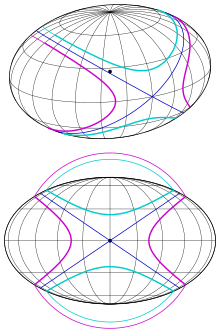



Using the above discussion let us investigate the qualitative behavior of a rigid body for a particular constant magnitude of the angular momentum sat $||\Pi||=h$. The figure below shows the intersection curves of different energy ellipsoids corresponding to different energy levels with angular momentum sphere $||\Pi||=h$. From this we see that the two relative equilibria corresponding to the body spinning along the major and minor principle axis are stable while the other relative equilibrium corresponding to the body spinning along the intermediate principle axis is unstable. All other trajectories except the four ones corresponding to the critical case are periodic trajectories in the body angular momentum space.

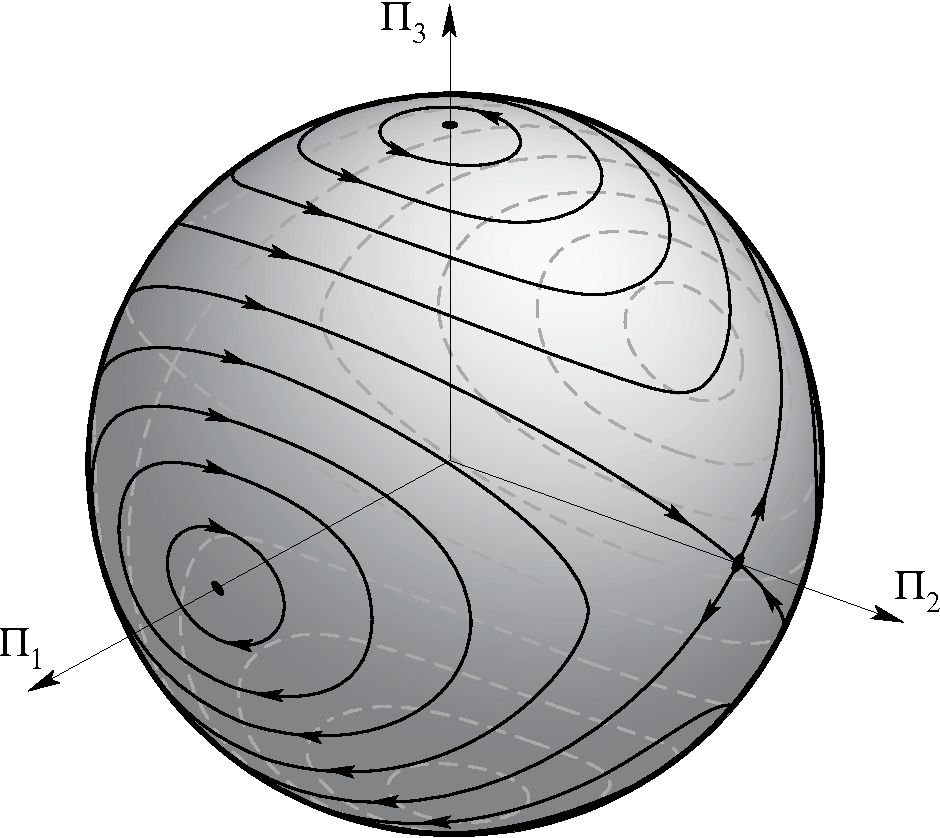


## Numerical Verification

### Defining the parameters

In [ ]:
M=10;l=2;w=1;h=4; II_1=M*(w**2+h**2)/12; II_2=M*(l**2+h**2)/12;II_3=M*(w**2+l**2)/12;
cubeDimensions={'l':l,'w':w,'h':h,'xp':l/2,'yp':w/2,'zp':h/2,};
parameters={'CM':np.array([l/2-cubeDimensions['xp'],w/2-cubeDimensions['yp'],h/2-cubeDimensions['zp']]), 'g':10, 'M':M, 'II':np.array([[II_1,0.,0.],[0.,II_2,0.],[0.,0.,II_3]])};

### Definig the initial conditions

In [ ]:
ICq=mr.q_from_axis_angles(0*np.pi/18,np.array([1,0,0])); ICR=mr.r_from_quaternions(ICq);
ICOmega=np.array([1.,1.,5.]); ICo=np.array([0.,0.,0.]); ICdoto=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],ICR@ICOmega,ICdoto,ICXC]

### Simulating the dynamics

#### Defining the force model

In [ ]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hat_matrix(R@CM) @ [0,0,1])-0*spi;
  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  tauu=np.array([0,0,0]);
  fu=np.array([0,0,0]);
  return [tauu,fu]

#### Simulating the dynamics

In [ ]:
dt=0.1; Tmax=10.;
aa4=mr.simulating_a_cube(dt, Tmax, cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Cube Pivoted at a point')

### Plotting the intersection of the Angular Momentum sphere with the Kinetic Energy ellipsoid

In [ ]:
II=parameters['II'];
magPi=linalg.norm(II@ICOmega);
KE=0.5*ICOmega.T@II@ICOmega;
spatialpi=ICR@II@ICOmega;

In [ ]:
dphi, dtheta = np.pi / 25.0, np.pi / 25.0
[phi, theta] = np.mgrid[0:np.pi + dphi * 1.5:dphi, 0:2 * np.pi +
                        dtheta * 1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r=magPi;  a=np.sqrt(2*KE*II[0,0]); b=np.sqrt(2*KE*II[1,1]); c=np.sqrt(2*KE*II[2,2]);# a=2.38047614284762; b=2.58198889747161; c=1.29099444873581; #
# Applying the parametric equation..
#r = (np.sin(m0 * phi) ** m1 + np.cos(m2 * phi) ** m3 + np.sin(m4 * theta) ** m5 + np.cos(m6 * theta) ** m7)
x1 = r * np.sin(phi) * np.cos(theta); z1 = r * np.cos(phi); y1 = r * np.sin(phi) * np.sin(theta)
x2 = a * np.sin(phi) * np.cos(theta); z2 = c * np.cos(phi); y2 = b * np.sin(phi) * np.sin(theta)


surface1 = go.Surface(x=x1, y=y1, z=z1, colorscale='Viridis')
surface2 = go.Surface(x=x2, y=y2, z=z2, colorscale='Viridis')
data = [surface1,surface2]
layout = go.Layout(
    title='Intersection of the angular momentum sphere and the Kinetic Energy Ellipsoid',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

### Plotting the nutation angle

In [ ]:
Xs=mr.runga_kutta_method(dt,Tmax,parameters,ICs);

In [ ]:
II=parameters['II'];

In [ ]:
alphat=[];
for X in Xs:
  R=X[0][0];
  Pi=R@II@R.T@X[1];
  alphat+=[round(math.acos(Pi[2]/linalg.norm(Pi)), 5)]
t=np.linspace(0,Tmax+dt,round(Tmax/dt)+2)

In [ ]:
fig = go.Figure(data=go.Scatter(x=t, y=alphat, mode='markers'))
fig.show()

## Analytical solutions of free rigid body motion

Let us first consider the more general asymmetric rigid body, $\mathbb{I}_1>\mathbb{I}_2>\mathbb{I}_3$.
From the two conservation laws (\ref{eq:KEConst0}) and (\ref{eq:PiConst0}) we have that
\begin{align*}
\Pi^2_1 &=\alpha_{21}-\beta_{21} \Pi^2_2,\\
\Pi^2_3 &=\alpha_{23}-\beta_{23} \Pi^2_2,
\end{align*}
where
\begin{align*}
\alpha_{21}=\frac{\mathbb{I}_1(h-2E\mathbb{I}_3)}{\mathbb{I}_1-\mathbb{I}_3},\:\:\:\:\alpha_{23}=\frac{\mathbb{I}_3(h-2E\mathbb{I}_1)}{\mathbb{I}_3-\mathbb{I}_1}
\end{align*}
and
\begin{align*}
\beta_{21}=\frac{\mathbb{I}_1(\mathbb{I}_2-\mathbb{I}_3)}{\mathbb{I}_2(\mathbb{I}_1-\mathbb{I}_3)},\:\:\:\:\beta_{23}=\frac{\mathbb{I}_3(\mathbb{I}_2-\mathbb{I}_1)}{\mathbb{I}_2(\mathbb{I}_3-\mathbb{I}_1)}.
\end{align*}
Let $2E\mathbb{I}_3<h<2E\mathbb{I}_1$. Then both $\alpha_{21}>0$ and $\alpha_{23}>0$.
Since without loss of generality we have assumed that $\mathbb{I}_1>\mathbb{I}_2>\mathbb{I}_3$ then $\beta_{21}>0$ and $\beta_{23}>0$.

Using these (\ref{eq:AxiSym2PiFree}) can be written as
\begin{align*}
\dot{\Pi}_2  =  \frac{(\mathbb{I}_1-\mathbb{I}_3)}{\mathbb{I}_1 \mathbb{I}_3}\sqrt{(\alpha_{21}-\beta_{21} \Pi^2_2)(\alpha_{23}-\beta_{23} \Pi^2_2)}.
\end{align*}
Using the variable transformation
\begin{align*}
u\triangleq \sqrt{\frac{\beta_{21}}{\alpha_{21}}}\,\Pi_2,
\end{align*}
\begin{align*}
\omega\triangleq \sqrt{\beta_{21}\alpha_{23}}\left(\frac{\mathbb{I}_1-\mathbb{I}_3}{\mathbb{I}_1\mathbb{I}_3}\right)=\sqrt{\frac{(\mathbb{I}_2-\mathbb{I}_3)(2E\mathbb{I}_1-h)}{\mathbb{I}_1\mathbb{I}_2\mathbb{I}_3}}
\end{align*}
and
\begin{align*}
k^2\triangleq \frac{\alpha_{21}\beta_{23}}{\alpha{23}\beta_{21}}=\frac{(\mathbb{I}_1-\mathbb{I}_2)(h-2E\mathbb{I}_3)}{(\mathbb{I}_2-\mathbb{I}_3)(2E\mathbb{I}_1-h)}
\end{align*}
this reduces to
\begin{align*}
\dot{u}  =  \omega\sqrt{(1-u^2)(1-k^2u^2)}.
\end{align*}
This can be explicitly integrated using quadrature as follows:
\begin{align*}
\int \frac{1}{\sqrt{(1-u^2)(1-k^2u^2)}}\,du =  \int \omega \,dt=\omega t +c.
\end{align*}
The left hand side of the above integral is the inverse of the Jacobi elliptic function $\mathrm{sn}$ of modulus $k$ where $0\leq k \leq 1$,
\begin{align*}
\mathrm{sn}^{-1}(u)=\int_0^u \frac{1}{\sqrt{(1-u^2)(1-k^2u^2)}}\,du.
\end{align*}
Thus we have
\begin{align*}
u(t)=\mathrm{sn}(\omega t +c),
\end{align*}
and hence
\begin{align*}
\Pi_2(t)&=\sqrt{\frac{\mathbb{I}_2(h-2E\mathbb{I}_3)}{(\mathbb{I}_2-\mathbb{I}_3)}}\;\mathrm{sn}(\omega t +c).
\end{align*}

Thus we have that
\begin{align*}
\Pi^2_1 &=\alpha_{21}(1-u^2)=\alpha_{21}(1-\mathrm{sn}^2(\omega t +c))=\alpha_{21}\mathrm{cn}^2(\omega t +c), \\
\Pi^2_3 &=\alpha_{23}(1-k^2u^2)=\alpha_{23}(1-k^2\mathrm{sn}^2(\omega t +c))=\alpha_{23}\mathrm{dn}^2(\omega t +c),
\end{align*}
and hence
\begin{align*}
\Pi_1(t) &=\sqrt{\frac{\mathbb{I}_1(h-2E\mathbb{I}_3)}{\mathbb{I}_1-\mathbb{I}_3}}\mathrm{cn}(\omega t +c), \\
\Pi_3(t) &=\sqrt{\frac{\mathbb{I}_3(2E\mathbb{I}_1-h)}{\mathbb{I}_1-\mathbb{I}_3}}\mathrm{dn}(\omega t +c).
\end{align*}

Jacobi Elliptic functions sn and cn are periodic functions of period $4K$ and dn is periodic of period $2K$,
where
\begin{align*}
K(k)=\mathrm{sn}^{-1}(1)=\int_0^1 \frac{1}{\sqrt{(1-u^2)(1-k^2u^2)}}\,du=\int_0^{\pi/2}
\frac{1}{\sqrt{1-k^2\sin^2{\psi}}}d\psi \approx \left(1+\frac{k^2}{4}\right)\frac{\pi}{2}.
\end{align*}
Thus $\Pi_1(t), \Pi_2(t), \Pi_3(t)$ are periodic of period
\begin{align*}
T=4K(k)/\omega =\frac{2\pi}{\omega}\left(1+\frac{k^2}{4}+H.O.T.\right) \approx 2\pi \sqrt{\frac{\mathbb{I}_1\mathbb{I}_2\mathbb{I}_3}{(2E\mathbb{I}_1-h)(\mathbb{I}_2-\mathbb{I}_3)}}\left( 1+\frac{(\mathbb{I}_1-\mathbb{I}_2)(h-2E\mathbb{I}_3)}{4(\mathbb{I}_2-\mathbb{I}_3)(2E\mathbb{I}_1-h)} \right).
\end{align*}
Thus confirming that $\Pi(t)$ is periodic of period $T$. However recall that the motion of the rigid body is not periodic!!!

The  nutation angle $\alpha(t)$
between the body fixed axis $\Upsilon=[0\:\:0\:\:1]^T$ and the constant spatial angular momentum $\pi$ is given by
\begin{align*}
\alpha(t)=\mathrm{cos}^{-1}\left(\frac{\Upsilon \cdot \Pi}{h}\right)=\mathrm{cos}^{-1}\left(\frac{\Pi_3}{h}\right)
=\mathrm{cos}^{-1}\left(\sqrt{\frac{\mathbb{I}_3(2E\mathbb{I}_1-h)}{h^2(\mathbb{I}_1-\mathbb{I}_3)}}\mathrm{dn}(\omega t +c)\right).
\end{align*}


### Special case of the axi-symmetric rigid body

For an axi-symmetric rigid body, $\mathbb{I}_1=\mathbb{I}_2>\mathbb{I}_3$. Then we see that $k=0$ and hence that the elliptic functions reduce to the trigonometric functions ($\mathrm{sn}\rightarrow \sin, \:\:\:\mathrm{cn}\rightarrow \cos,\:\:\: \mathrm{dn}\rightarrow
1$). Thus we have
\begin{align*}
\omega=\sqrt{\frac{(2E\mathbb{I}_1-h)(\mathbb{I}_2-\mathbb{I}_3)}{\mathbb{I}_1\mathbb{I}_2\mathbb{I}_3}},
\end{align*}
and
\begin{align*}
\Pi_1(t) &=&\sqrt{\frac{\mathbb{I}_1(h-2E\mathbb{I}_3)}{\mathbb{I}_1-\mathbb{I}_3}}\cos(\omega\, t +c), \\
\Pi_2(t) &=&\sqrt{\frac{\mathbb{I}_2(h-2E\mathbb{I}_3)}{(\mathbb{I}_2-\mathbb{I}_3)}}\;\sin(\omega\, t +c),\\
\Pi_3(t) &=&\sqrt{\frac{\mathbb{I}_3(2E\mathbb{I}_1-h)}{\mathbb{I}_1-\mathbb{I}_3}}=\mathrm{constant}.
\end{align*}
The body angular momentum $\Pi(t)$ is periodic of period
\begin{align*}
T=2\pi \sqrt{\frac{\mathbb{I}_1\mathbb{I}_2\mathbb{I}_3}{(2E\mathbb{I}_1-h)(\mathbb{I}_2-\mathbb{I}_3)}}.
\end{align*}
Consider the minor axis of symmetry of the body $\Upsilon=[0\:\:\:0\:\:\:1]^T$ (as represented in the body frame).
The angle between the body angular momentum and the minor axis of symmetry of the body (\textit{angle of nutation of the minor axis}) is given by,
\begin{align*}
\alpha=\mathrm{cos}^{-1}\left(\frac{\Upsilon \cdot \Pi}{h}\right)=\mathrm{cos}^{-1}\left(\frac{\Pi_3}{h}\right)
=\mathrm{cos}^{-1}\left(\sqrt{\frac{\mathbb{I}_3(2E\mathbb{I}_1-h)}{h^2(\mathbb{I}_1-\mathbb{I}_3)}}\right)=\mathrm{constant}
\end{align*}
and is a constant.
